# Protein Ligant Prediction

## Data Set - Link and Node apo CSV files with ground_truth

In [3]:
import numpy as np
import os
import pandas as pd
import random

def get_file_summary(file_path):
    data = pd.read_csv(file_path)
    summary = {
        "Number of Rows": len(data),
        "Number of Columns": len(data.columns)
    }
    return summary


apo_folder = 'apo'


node_files = [f for f in os.listdir(apo_folder) if f.endswith('_nodes.csv')]
link_files = [f for f in os.listdir(apo_folder) if f.endswith('_links.csv')]


if len(node_files) < 5 or len(link_files) < 5:
    print("Not enough files to select 5 pairs.")
else:
    
    selected_node_files = random.sample(node_files, 5)
    selected_link_files = [f.replace('_nodes.csv', '_links.csv') for f in selected_node_files]

    for node_file, link_file in zip(selected_node_files, selected_link_files):
        node_summary = get_file_summary(os.path.join(apo_folder, node_file))
        link_summary = get_file_summary(os.path.join(apo_folder, link_file))

        print(f"Node File: {node_file}, Summary: {node_summary}")
        print(f"Link File: {link_file}, Summary: {link_summary}")
        print("-" * 40)


Node File: 1KZ7_D_nodes.csv, Summary: {'Number of Rows': 1379, 'Number of Columns': 41}
Link File: 1KZ7_D_links.csv, Summary: {'Number of Rows': 9681, 'Number of Columns': 23}
----------------------------------------
Node File: 2BU8_A_nodes.csv, Summary: {'Number of Rows': 2820, 'Number of Columns': 41}
Link File: 2BU8_A_links.csv, Summary: {'Number of Rows': 20212, 'Number of Columns': 23}
----------------------------------------
Node File: 2ZKU_B_nodes.csv, Summary: {'Number of Rows': 4281, 'Number of Columns': 41}
Link File: 2ZKU_B_links.csv, Summary: {'Number of Rows': 31079, 'Number of Columns': 23}
----------------------------------------
Node File: 6HB0_A_nodes.csv, Summary: {'Number of Rows': 2266, 'Number of Columns': 41}
Link File: 6HB0_A_links.csv, Summary: {'Number of Rows': 16128, 'Number of Columns': 23}
----------------------------------------
Node File: 1FA9_A_nodes.csv, Summary: {'Number of Rows': 6422, 'Number of Columns': 41}
Link File: 1FA9_A_links.csv, Summary: {'N

## Processing of Data

- Removing of redundant columns
- Adding bidirectional and self links
- creating graph structures

In [13]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
import os

def load_and_process_data(prefix):
    node_file = f'apo/{prefix}_nodes.csv'
    link_file = f'apo/{prefix}_links.csv'

    node_data = pd.read_csv(node_file)
    link_data = pd.read_csv(link_file)


    labels = node_data['ground_truth'].values
    features = node_data.drop(columns=['ground_truth'])

    node_features = node_data[['atom_type', 'residue_type', 'center_x', 'center_y', 'center_z', 'radius', 'voromqa_sas_potential', 'residue_mean_sas_potential', 'residue_sum_sas_potential', 'residue_size', 'sas_area', 'solvdir_x', 'solvdir_y', 'solvdir_z', 'voromqa_sas_energy', 'voromqa_depth', 'voromqa_score_a', 'voromqa_score_r', 'volume', 'volume_vdw', 'ufsr_a1', 'ufsr_a2', 'ufsr_c2', 'ufsr_c3', 'ev28', 'ev56', 'ground_truth']]

    link_features = link_data[['atom_index1', 'atom_index2','area', 'boundary', 'distance', 'voromqa_energy', 'seq_sep_class', 'covalent_bond', 'hbond']]


    edge_index = torch.tensor(np.array([link_features['atom_index1'].values, link_features['atom_index2'].values]), dtype=torch.long)


    self_links = torch.arange(0, len(node_features))
    edge_index = torch.cat([edge_index, torch.stack([self_links, self_links])], dim=1)
    edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)  # Add reverse direction

    node_features_tensor = torch.tensor(node_features.values, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    # Create graph data object
    data = Data(x=node_features_tensor, edge_index=edge_index, y=labels_tensor)

    return data


candidate_pairs_file = 'apo/candidate_pairs.txt'
candidate_pairs = pd.read_csv(candidate_pairs_file, delim_whitespace=True)


graphs = {}
for index, row in candidate_pairs.iterrows():
    prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
    graphs[prefix] = load_and_process_data(prefix)



save_dir = 'saved_graphs'
os.makedirs(save_dir, exist_ok=True)


for prefix, graph in graphs.items():
    save_path = os.path.join(save_dir, f'{prefix}_graph.pt')
    torch.save(graph, save_path)

print(f"All graphs have been saved in the directory: {save_dir}")

All graphs have been saved in the directory: saved_graphs


# Representation of Created Graphs

In [1]:
import os
import torch
import random

def get_graph_summary(file_path):
    graph = torch.load(file_path)
    summary = {
        "Number of Nodes": graph.num_nodes,
        "Number of Edges": graph.num_edges,
        "Feature Vector Size per Node": graph.num_node_features
    }
    return summary


saved_graphs_folder = 'sh'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


if len(graph_files) < 5:
    print("Not enough files to select 5 graphs.")
else:
  
    selected_graph_files = random.sample(graph_files, 5)

    for graph_file in selected_graph_files:
        graph_summary = get_graph_summary(os.path.join(saved_graphs_folder, graph_file))
        print(f"Graph File: {graph_file}, Summary: {graph_summary}")
        print("-" * 40)


Graph File: 2AL4_F_graph.pt, Summary: {'Number of Nodes': 2018, 'Number of Edges': 32714, 'Feature Vector Size per Node': 20}
----------------------------------------
Graph File: 2OT1_D_graph.pt, Summary: {'Number of Nodes': 2666, 'Number of Edges': 43568, 'Feature Vector Size per Node': 20}
----------------------------------------
Graph File: 3CFN_B_graph.pt, Summary: {'Number of Nodes': 883, 'Number of Edges': 13866, 'Feature Vector Size per Node': 20}
----------------------------------------
Graph File: 5IGY_A_graph.pt, Summary: {'Number of Nodes': 2385, 'Number of Edges': 38680, 'Feature Vector Size per Node': 20}
----------------------------------------
Graph File: 1GRN_A_graph.pt, Summary: {'Number of Nodes': 1379, 'Number of Edges': 22080, 'Feature Vector Size per Node': 20}
----------------------------------------


# Visualization of a random created Protein Graph

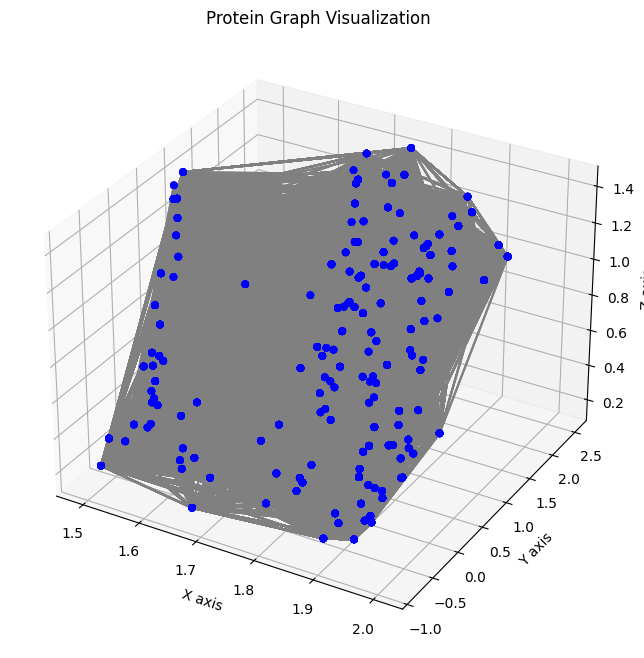

In [4]:
import os
import random
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_protein_graph(graph):
 
    pos = graph.x[:, 2:5]  


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=20, c='blue')


    for edge in graph.edge_index.t():
        start, end = edge[0].item(), edge[1].item()
        xs, ys, zs = zip(pos[start], pos[end])
        ax.plot(xs, ys, zs, color='gray')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.title("Protein Graph Visualization")
    plt.show()


saved_graphs_folder = 'sg'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


selected_graph_file = random.choice(graph_files)


graph_path = os.path.join(saved_graphs_folder, selected_graph_file)
graph = torch.load(graph_path)


plot_protein_graph(graph)


# Training with a basic GCN Model (0.8 train 0.2 test)

# Correlation Loss GCN

# Training with a GAT Model with MAE Loss

# GAT Model with Correlation Loss

# Equivariance Check on GAT

# Implementing GVP

# GVP With Correlation Loss

# Cross Validation GVP-RNN - K fold


/home/flahaari/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


Starting fold 3/5


Epochs:  50%|█████     | 10/20 [00:17<00:17,  1.72s/it]


Early stopping triggered.
Starting fold 4/5


Epochs:  50%|█████     | 10/20 [00:17<00:17,  1.70s/it]


Early stopping triggered.
Starting fold 5/5


Epochs:  50%|█████     | 10/20 [00:17<00:17,  1.71s/it]

Early stopping triggered.


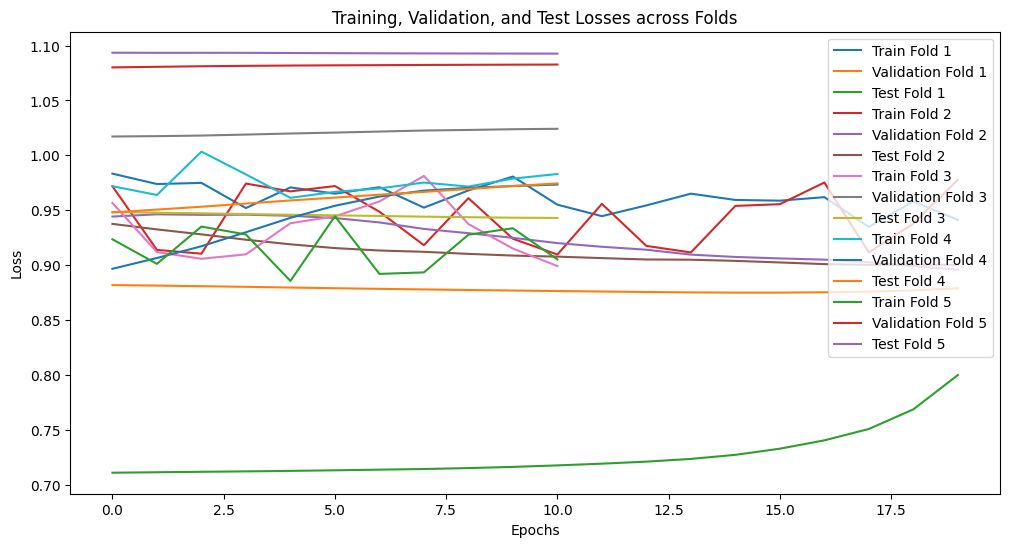

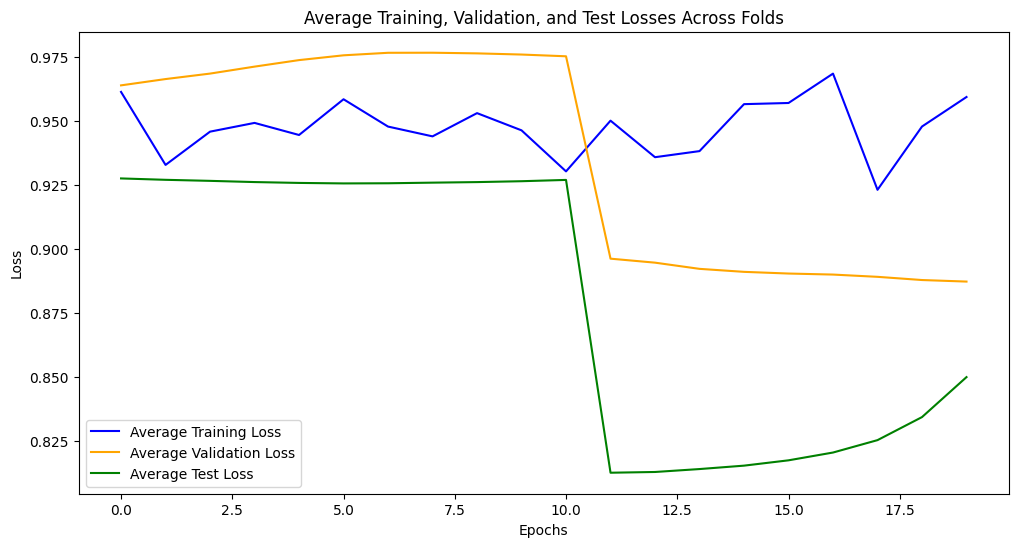

KeyError: 0

Running Fold 1/20


Training: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Running Fold 2/20


Training: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


Running Fold 3/20


Training: 100%|██████████| 50/50 [00:20<00:00,  2.40it/s]


Running Fold 4/20


Training: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


Running Fold 5/20


Training: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Running Fold 6/20


Training: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Running Fold 7/20


Training: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


Running Fold 8/20


Training: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


Running Fold 9/20


Training: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


Running Fold 10/20


Training: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Running Fold 11/20


Training: 100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Running Fold 12/20


Training: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Running Fold 13/20


Training: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]


Running Fold 14/20


Training: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Running Fold 15/20


Training: 100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Running Fold 16/20


Training: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


Running Fold 17/20


Training: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Running Fold 18/20


Training: 100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Running Fold 19/20


Training: 100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Running Fold 20/20


Training: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


Average Validation Loss: 0.0, Average Pearson Correlation: nan, Average Test Loss: 0.0


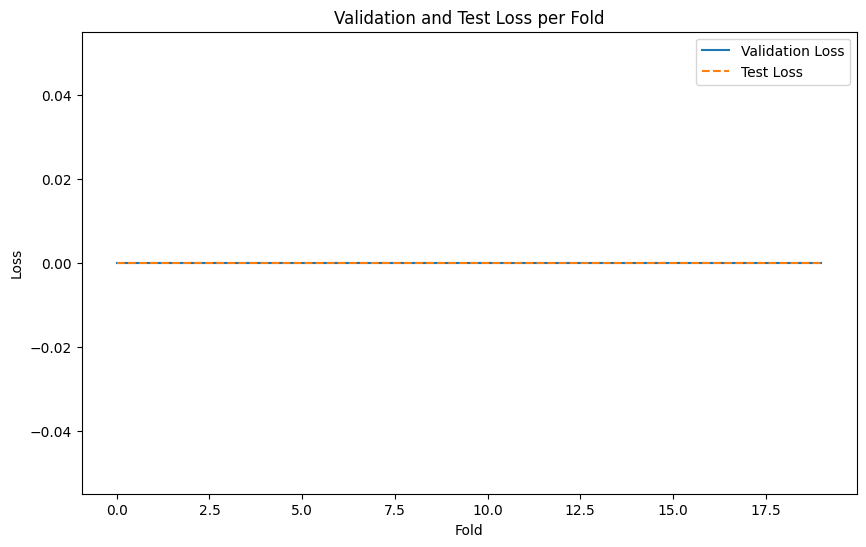

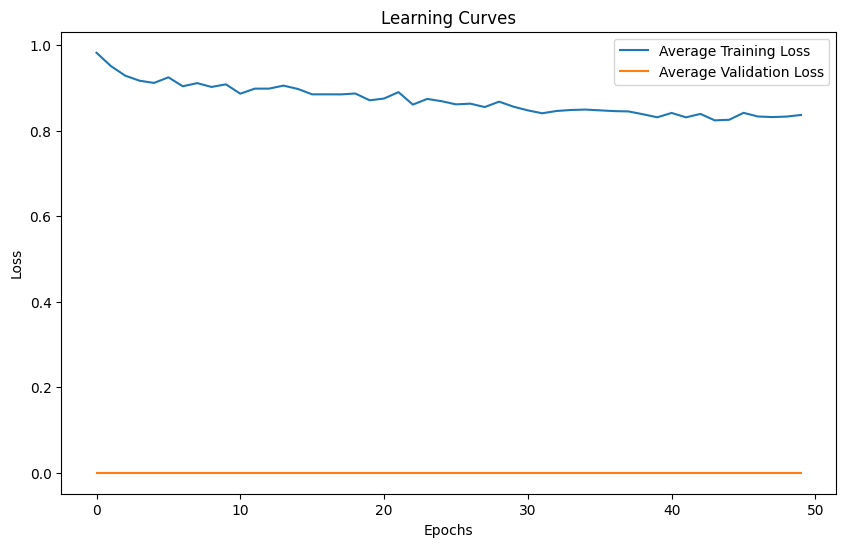

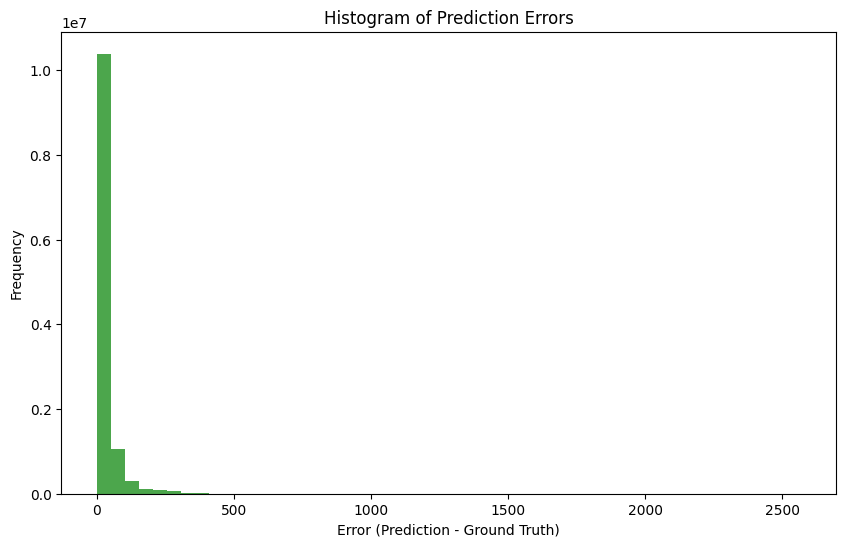

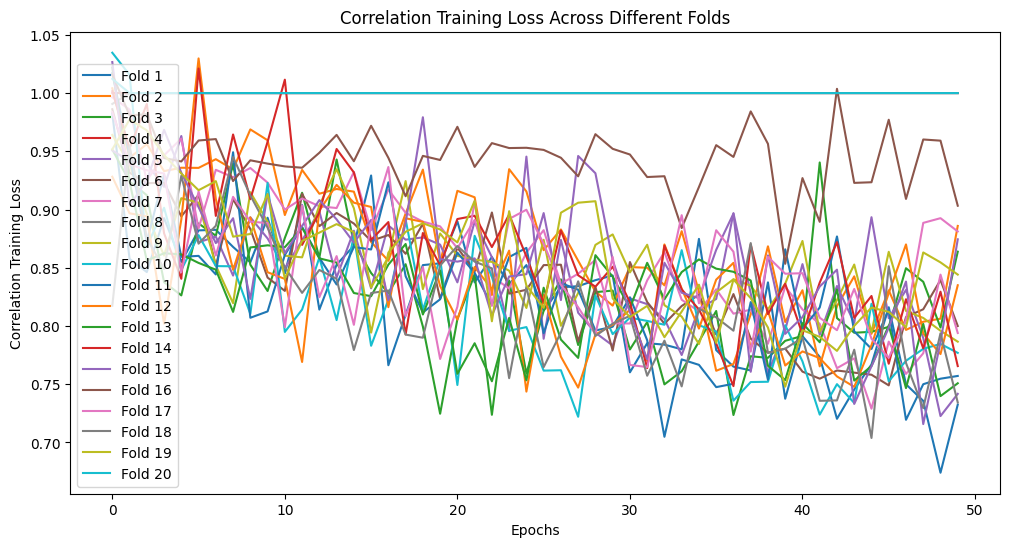

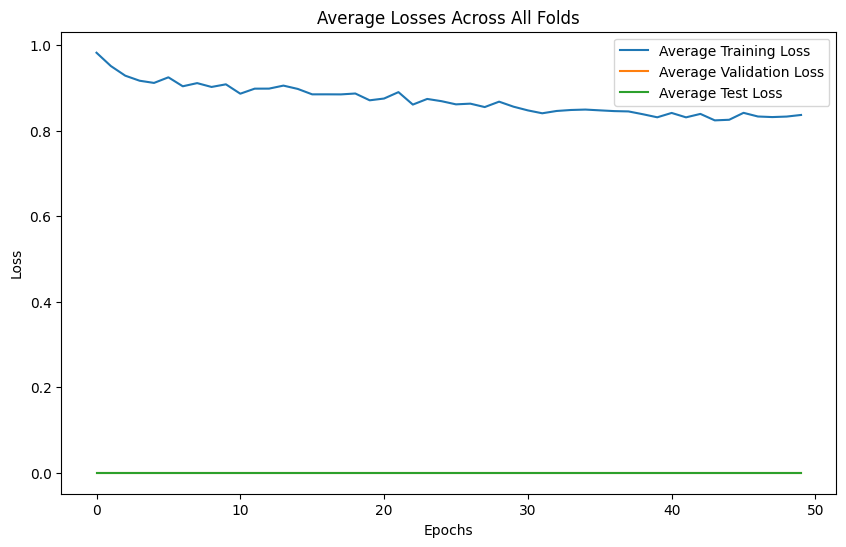

Epochs:   0%|                                   | 1/500 [00:00<02:39,  3.12it/s]

Epoch 0: Train Loss = 1.0058, Test Loss = 0.7488


Epochs:   0%|▏                                  | 2/500 [00:00<02:40,  3.10it/s]

Epoch 1: Train Loss = 0.9991, Test Loss = 0.7480


Epochs:   1%|▏                                  | 3/500 [00:00<02:45,  2.99it/s]

Epoch 2: Train Loss = 0.9794, Test Loss = 0.7458


Epochs:   1%|▎                                  | 4/500 [00:01<02:46,  2.98it/s]

Epoch 3: Train Loss = 0.9902, Test Loss = 0.7424


Epochs:   1%|▎                                  | 5/500 [00:01<02:50,  2.91it/s]

Epoch 4: Train Loss = 1.0006, Test Loss = 0.7394


Epochs:   1%|▍                                  | 6/500 [00:02<02:59,  2.76it/s]

Epoch 5: Train Loss = 0.9792, Test Loss = 0.7366


Epochs:   1%|▍                                  | 7/500 [00:02<02:58,  2.76it/s]

Epoch 6: Train Loss = 0.9583, Test Loss = 0.7351


Epochs:   2%|▌                                  | 8/500 [00:02<03:00,  2.72it/s]

Epoch 7: Train Loss = 0.9609, Test Loss = 0.7348


Epochs:   2%|▋                                  | 9/500 [00:03<03:12,  2.55it/s]

Epoch 8: Train Loss = 0.9542, Test Loss = 0.7362


Epochs:   2%|▋                                 | 10/500 [00:03<03:03,  2.67it/s]

Epoch 9: Train Loss = 0.9584, Test Loss = 0.8296


Epochs:   2%|▋                                 | 11/500 [00:03<02:59,  2.72it/s]

Epoch 10: Train Loss = 0.9580, Test Loss = 0.9339


Epochs:   2%|▊                                 | 12/500 [00:04<03:00,  2.70it/s]

Epoch 11: Train Loss = 0.9444, Test Loss = 0.7626


Epochs:   3%|▉                                 | 13/500 [00:04<02:55,  2.77it/s]

Epoch 12: Train Loss = 0.9575, Test Loss = 0.7465


Epochs:   3%|▉                                 | 14/500 [00:05<02:52,  2.82it/s]

Epoch 13: Train Loss = 0.9411, Test Loss = 0.7417


Epochs:   3%|█                                 | 15/500 [00:05<02:50,  2.85it/s]

Epoch 14: Train Loss = 0.9558, Test Loss = 0.7628


Epochs:   3%|█                                 | 16/500 [00:05<02:47,  2.89it/s]

Epoch 15: Train Loss = 0.9611, Test Loss = 0.8300


Epochs:   3%|█▏                                | 17/500 [00:06<02:46,  2.90it/s]

Epoch 16: Train Loss = 0.9399, Test Loss = 0.9140


Epochs:   4%|█▏                                | 18/500 [00:06<02:45,  2.92it/s]

Epoch 17: Train Loss = 0.9486, Test Loss = 0.8021


Epochs:   4%|█▎                                | 19/500 [00:06<02:44,  2.92it/s]

Epoch 18: Train Loss = 0.9296, Test Loss = 0.7509


Epochs:   4%|█▎                                | 20/500 [00:07<02:47,  2.87it/s]

Epoch 19: Train Loss = 0.9459, Test Loss = 0.7438


Epochs:   4%|█▍                                | 21/500 [00:07<02:45,  2.89it/s]

Epoch 20: Train Loss = 0.9611, Test Loss = 0.7544


Epochs:   4%|█▍                                | 22/500 [00:07<02:44,  2.90it/s]

Epoch 21: Train Loss = 0.9223, Test Loss = 0.7691


Epochs:   5%|█▌                                | 23/500 [00:08<02:47,  2.84it/s]

Epoch 22: Train Loss = 0.9305, Test Loss = 0.7423


Epochs:   5%|█▋                                | 24/500 [00:08<02:44,  2.89it/s]

Epoch 23: Train Loss = 0.9548, Test Loss = 0.7414


Epochs:   5%|█▋                                | 25/500 [00:08<02:43,  2.90it/s]

Epoch 24: Train Loss = 0.9525, Test Loss = 0.8244


Epochs:   5%|█▊                                | 26/500 [00:09<02:43,  2.89it/s]

Epoch 25: Train Loss = 0.9405, Test Loss = 0.9539


Epochs:   5%|█▊                                | 27/500 [00:09<02:43,  2.90it/s]

Epoch 26: Train Loss = 0.9301, Test Loss = 0.9551


Epochs:   6%|█▉                                | 28/500 [00:09<02:53,  2.72it/s]

Epoch 27: Train Loss = 0.9221, Test Loss = 0.9568


Epochs:   6%|█▉                                | 29/500 [00:10<02:51,  2.74it/s]

Epoch 28: Train Loss = 0.9443, Test Loss = 0.9611


Epochs:   6%|██                                | 30/500 [00:10<02:48,  2.78it/s]

Epoch 29: Train Loss = 0.9579, Test Loss = 0.9721


Epochs:   6%|██                                | 31/500 [00:10<02:46,  2.82it/s]

Epoch 30: Train Loss = 0.9326, Test Loss = 0.9830


Epochs:   6%|██▏                               | 32/500 [00:11<02:45,  2.82it/s]

Epoch 31: Train Loss = 0.9155, Test Loss = 0.9778


Epochs:   7%|██▏                               | 33/500 [00:11<02:53,  2.69it/s]

Epoch 32: Train Loss = 0.8630, Test Loss = 0.9759


Epochs:   7%|██▎                               | 34/500 [00:12<02:53,  2.69it/s]

Epoch 33: Train Loss = 0.8915, Test Loss = 1.0019


Epochs:   7%|██▍                               | 35/500 [00:12<02:51,  2.72it/s]

Epoch 34: Train Loss = 0.8529, Test Loss = 0.9907


Epochs:   7%|██▍                               | 36/500 [00:13<03:20,  2.31it/s]

Epoch 35: Train Loss = 0.8667, Test Loss = 0.9965


Epochs:   7%|██▌                               | 37/500 [00:13<04:18,  1.79it/s]

Epoch 36: Train Loss = 0.8807, Test Loss = 0.9820


Epochs:   8%|██▌                               | 38/500 [00:14<03:48,  2.02it/s]

Epoch 37: Train Loss = 0.8410, Test Loss = 0.9708


Epochs:   8%|██▋                               | 39/500 [00:14<03:28,  2.21it/s]

Epoch 38: Train Loss = 0.8148, Test Loss = 0.9672


Epochs:   8%|██▋                               | 40/500 [00:14<03:14,  2.36it/s]

Epoch 39: Train Loss = 0.8812, Test Loss = 0.9756


Epochs:   8%|██▊                               | 41/500 [00:15<03:10,  2.41it/s]

Epoch 40: Train Loss = 0.8357, Test Loss = 0.9705


Epochs:   8%|██▊                               | 42/500 [00:15<02:59,  2.55it/s]

Epoch 41: Train Loss = 0.8544, Test Loss = 0.9621


Epochs:   9%|██▉                               | 43/500 [00:16<02:54,  2.62it/s]

Epoch 42: Train Loss = 0.8331, Test Loss = 0.9542


Epochs:   9%|██▉                               | 44/500 [00:16<02:54,  2.61it/s]

Epoch 43: Train Loss = 0.8443, Test Loss = 0.9183


Epochs:   9%|███                               | 45/500 [00:16<02:54,  2.60it/s]

Epoch 44: Train Loss = 0.8563, Test Loss = 0.9593


Epochs:   9%|███▏                              | 46/500 [00:17<02:47,  2.71it/s]

Epoch 45: Train Loss = 0.8195, Test Loss = 0.9640


Epochs:   9%|███▏                              | 47/500 [00:17<02:45,  2.74it/s]

Epoch 46: Train Loss = 0.8448, Test Loss = 0.9579


Epochs:  10%|███▎                              | 48/500 [00:17<02:45,  2.72it/s]

Epoch 47: Train Loss = 0.8322, Test Loss = 0.9436


Epochs:  10%|███▎                              | 49/500 [00:18<02:41,  2.79it/s]

Epoch 48: Train Loss = 0.7995, Test Loss = 0.9197


Epochs:  10%|███▍                              | 50/500 [00:18<02:43,  2.76it/s]

Epoch 49: Train Loss = 0.7811, Test Loss = 0.9079


Epochs:  10%|███▍                              | 51/500 [00:18<02:44,  2.74it/s]

Epoch 50: Train Loss = 0.7864, Test Loss = 0.9028


Epochs:  10%|███▌                              | 52/500 [00:19<02:50,  2.63it/s]

Epoch 51: Train Loss = 0.8102, Test Loss = 0.9172


Epochs:  11%|███▌                              | 53/500 [00:19<02:52,  2.59it/s]

Epoch 52: Train Loss = 0.7711, Test Loss = 0.8843


Epochs:  11%|███▋                              | 54/500 [00:20<02:51,  2.60it/s]

Epoch 53: Train Loss = 0.7765, Test Loss = 0.8908


Epochs:  11%|███▋                              | 55/500 [00:20<02:46,  2.68it/s]

Epoch 54: Train Loss = 0.7727, Test Loss = 0.8968


Epochs:  11%|███▊                              | 56/500 [00:20<02:41,  2.75it/s]

Epoch 55: Train Loss = 0.7540, Test Loss = 0.8728


Epochs:  11%|███▉                              | 57/500 [00:21<02:39,  2.77it/s]

Epoch 56: Train Loss = 0.7511, Test Loss = 0.9140


Epochs:  12%|███▉                              | 58/500 [00:21<02:36,  2.83it/s]

Epoch 57: Train Loss = 0.7661, Test Loss = 0.8513


Epochs:  12%|████                              | 59/500 [00:21<02:40,  2.74it/s]

Epoch 58: Train Loss = 0.8133, Test Loss = 0.8141


Epochs:  12%|████                              | 60/500 [00:22<02:41,  2.72it/s]

Epoch 59: Train Loss = 0.7617, Test Loss = 0.7824


Epochs:  12%|████▏                             | 61/500 [00:22<02:38,  2.77it/s]

Epoch 60: Train Loss = 0.7876, Test Loss = 0.9196


Epochs:  12%|████▏                             | 62/500 [00:22<02:34,  2.83it/s]

Epoch 61: Train Loss = 0.7426, Test Loss = 0.8903


Epochs:  13%|████▎                             | 63/500 [00:23<02:37,  2.78it/s]

Epoch 62: Train Loss = 0.7746, Test Loss = 0.9509


Epochs:  13%|████▎                             | 64/500 [00:23<02:33,  2.84it/s]

Epoch 63: Train Loss = 0.7553, Test Loss = 0.9526


Epochs:  13%|████▍                             | 65/500 [00:24<02:31,  2.88it/s]

Epoch 64: Train Loss = 0.7591, Test Loss = 0.8742


Epochs:  13%|████▍                             | 66/500 [00:24<02:32,  2.85it/s]

Epoch 65: Train Loss = 0.8042, Test Loss = 0.9108


Epochs:  13%|████▌                             | 67/500 [00:24<02:31,  2.86it/s]

Epoch 66: Train Loss = 0.7375, Test Loss = 0.9241


Epochs:  14%|████▌                             | 68/500 [00:25<02:28,  2.92it/s]

Epoch 67: Train Loss = 0.7666, Test Loss = 0.9600


Epochs:  14%|████▋                             | 69/500 [00:25<02:23,  3.00it/s]

Epoch 68: Train Loss = 0.8475, Test Loss = 0.9601


Epochs:  14%|████▊                             | 70/500 [00:25<02:22,  3.02it/s]

Epoch 69: Train Loss = 0.7733, Test Loss = 0.9366


Epochs:  14%|████▊                             | 71/500 [00:26<02:22,  3.01it/s]

Epoch 70: Train Loss = 0.7623, Test Loss = 0.8889


Epochs:  14%|████▉                             | 72/500 [00:26<02:25,  2.94it/s]

Epoch 71: Train Loss = 0.7593, Test Loss = 0.8594


Epochs:  15%|████▉                             | 73/500 [00:26<02:25,  2.94it/s]

Epoch 72: Train Loss = 0.7471, Test Loss = 0.8969


Epochs:  15%|█████                             | 74/500 [00:27<02:24,  2.96it/s]

Epoch 73: Train Loss = 0.7426, Test Loss = 0.8684


Epochs:  15%|█████                             | 75/500 [00:27<02:24,  2.95it/s]

Epoch 74: Train Loss = 0.7580, Test Loss = 0.8449


Epochs:  15%|█████▏                            | 76/500 [00:27<02:27,  2.87it/s]

Epoch 75: Train Loss = 0.7688, Test Loss = 0.8493


Epochs:  15%|█████▏                            | 77/500 [00:28<02:28,  2.85it/s]

Epoch 76: Train Loss = 0.7542, Test Loss = 0.8606


Epochs:  16%|█████▎                            | 78/500 [00:28<02:30,  2.81it/s]

Epoch 77: Train Loss = 0.7485, Test Loss = 0.8429


Epochs:  16%|█████▎                            | 79/500 [00:28<02:30,  2.80it/s]

Epoch 78: Train Loss = 0.7072, Test Loss = 0.8577


Epochs:  16%|█████▍                            | 80/500 [00:29<02:27,  2.84it/s]

Epoch 79: Train Loss = 0.7294, Test Loss = 0.9044


Epochs:  16%|█████▌                            | 81/500 [00:29<02:23,  2.91it/s]

Epoch 80: Train Loss = 0.7491, Test Loss = 0.8704


Epochs:  16%|█████▌                            | 82/500 [00:29<02:26,  2.86it/s]

Epoch 81: Train Loss = 0.7341, Test Loss = 0.9021


Epochs:  17%|█████▋                            | 83/500 [00:30<02:27,  2.82it/s]

Epoch 82: Train Loss = 0.7420, Test Loss = 0.8763


Epochs:  17%|█████▋                            | 84/500 [00:30<02:25,  2.85it/s]

Epoch 83: Train Loss = 0.7400, Test Loss = 0.8619


Epochs:  17%|█████▊                            | 85/500 [00:30<02:25,  2.86it/s]

Epoch 84: Train Loss = 0.7142, Test Loss = 0.8556


Epochs:  17%|█████▊                            | 86/500 [00:31<02:27,  2.81it/s]

Epoch 85: Train Loss = 0.7007, Test Loss = 0.8671


Epochs:  17%|█████▉                            | 87/500 [00:31<02:32,  2.72it/s]

Epoch 86: Train Loss = 0.7168, Test Loss = 0.8631


Epochs:  18%|█████▉                            | 88/500 [00:32<02:30,  2.73it/s]

Epoch 87: Train Loss = 0.7341, Test Loss = 0.8775


Epochs:  18%|██████                            | 89/500 [00:32<02:32,  2.70it/s]

Epoch 88: Train Loss = 0.7308, Test Loss = 0.8625


Epochs:  18%|██████                            | 90/500 [00:32<02:30,  2.72it/s]

Epoch 89: Train Loss = 0.7072, Test Loss = 0.8442


Epochs:  18%|██████▏                           | 91/500 [00:33<02:29,  2.73it/s]

Epoch 90: Train Loss = 0.7166, Test Loss = 0.8360


Epochs:  18%|██████▎                           | 92/500 [00:33<02:32,  2.68it/s]

Epoch 91: Train Loss = 0.7391, Test Loss = 0.8644


Epochs:  19%|██████▎                           | 93/500 [00:33<02:29,  2.72it/s]

Epoch 92: Train Loss = 0.7246, Test Loss = 0.9292


Epochs:  19%|██████▍                           | 94/500 [00:34<02:27,  2.75it/s]

Epoch 93: Train Loss = 0.7518, Test Loss = 0.9162


Epochs:  19%|██████▍                           | 95/500 [00:34<02:27,  2.75it/s]

Epoch 94: Train Loss = 0.7075, Test Loss = 0.8592


Epochs:  19%|██████▌                           | 96/500 [00:34<02:26,  2.76it/s]

Epoch 95: Train Loss = 0.7397, Test Loss = 0.8529


Epochs:  19%|██████▌                           | 97/500 [00:35<02:26,  2.75it/s]

Epoch 96: Train Loss = 0.7562, Test Loss = 0.9150


Epochs:  20%|██████▋                           | 98/500 [00:35<02:22,  2.82it/s]

Epoch 97: Train Loss = 0.7219, Test Loss = 0.9147


Epochs:  20%|██████▋                           | 99/500 [00:36<02:21,  2.84it/s]

Epoch 98: Train Loss = 0.7811, Test Loss = 0.8790


Epochs:  20%|██████▌                          | 100/500 [00:36<02:23,  2.78it/s]

Epoch 99: Train Loss = 0.7282, Test Loss = 0.8548


Epochs:  20%|██████▋                          | 101/500 [00:36<02:24,  2.76it/s]

Epoch 100: Train Loss = 0.7186, Test Loss = 0.8644


Epochs:  20%|██████▋                          | 102/500 [00:37<02:21,  2.81it/s]

Epoch 101: Train Loss = 0.7249, Test Loss = 0.9136


Epochs:  21%|██████▊                          | 103/500 [00:37<02:18,  2.87it/s]

Epoch 102: Train Loss = 0.7457, Test Loss = 0.9061


Epochs:  21%|██████▊                          | 104/500 [00:37<02:18,  2.86it/s]

Epoch 103: Train Loss = 0.7205, Test Loss = 0.8550


Epochs:  21%|██████▉                          | 105/500 [00:38<02:21,  2.80it/s]

Epoch 104: Train Loss = 0.7445, Test Loss = 0.8401


Epochs:  21%|██████▉                          | 106/500 [00:38<02:24,  2.73it/s]

Epoch 105: Train Loss = 0.7103, Test Loss = 0.8478


Epochs:  21%|███████                          | 107/500 [00:38<02:21,  2.79it/s]

Epoch 106: Train Loss = 0.7075, Test Loss = 0.8456


Epochs:  22%|███████▏                         | 108/500 [00:39<02:19,  2.82it/s]

Epoch 107: Train Loss = 0.7445, Test Loss = 0.8471


Epochs:  22%|███████▏                         | 109/500 [00:39<02:20,  2.79it/s]

Epoch 108: Train Loss = 0.7347, Test Loss = 0.8442


Epochs:  22%|███████▎                         | 110/500 [00:39<02:18,  2.81it/s]

Epoch 109: Train Loss = 0.7168, Test Loss = 0.8503


Epochs:  22%|███████▎                         | 111/500 [00:40<02:18,  2.80it/s]

Epoch 110: Train Loss = 0.7294, Test Loss = 0.8359


Epochs:  22%|███████▍                         | 112/500 [00:40<02:19,  2.79it/s]

Epoch 111: Train Loss = 0.7254, Test Loss = 0.8406


Epochs:  23%|███████▍                         | 113/500 [00:41<02:19,  2.78it/s]

Epoch 112: Train Loss = 0.7237, Test Loss = 0.8478


Epochs:  23%|███████▌                         | 114/500 [00:41<02:18,  2.80it/s]

Epoch 113: Train Loss = 0.7236, Test Loss = 0.8690


Epochs:  23%|███████▌                         | 115/500 [00:41<02:18,  2.78it/s]

Epoch 114: Train Loss = 0.7448, Test Loss = 0.8453


Epochs:  23%|███████▋                         | 116/500 [00:42<02:17,  2.79it/s]

Epoch 115: Train Loss = 0.7235, Test Loss = 0.8399


Epochs:  23%|███████▋                         | 117/500 [00:42<02:18,  2.76it/s]

Epoch 116: Train Loss = 0.7000, Test Loss = 0.8490


Epochs:  24%|███████▊                         | 118/500 [00:42<02:16,  2.80it/s]

Epoch 117: Train Loss = 0.7001, Test Loss = 0.8620


Epochs:  24%|███████▊                         | 119/500 [00:43<02:16,  2.79it/s]

Epoch 118: Train Loss = 0.7297, Test Loss = 0.8341


Epochs:  24%|███████▉                         | 120/500 [00:43<02:19,  2.72it/s]

Epoch 119: Train Loss = 0.6996, Test Loss = 0.6943


Epochs:  24%|███████▉                         | 121/500 [00:43<02:19,  2.71it/s]

Epoch 120: Train Loss = 0.7150, Test Loss = 0.7331


Epochs:  24%|████████                         | 122/500 [00:44<02:19,  2.71it/s]

Epoch 121: Train Loss = 0.6819, Test Loss = 0.8210


Epochs:  25%|████████                         | 123/500 [00:44<02:18,  2.73it/s]

Epoch 122: Train Loss = 0.7166, Test Loss = 0.8306


Epochs:  25%|████████▏                        | 124/500 [00:45<02:27,  2.55it/s]

Epoch 123: Train Loss = 0.6777, Test Loss = 0.8389


Epochs:  25%|████████▎                        | 125/500 [00:45<02:23,  2.61it/s]

Epoch 124: Train Loss = 0.6919, Test Loss = 0.8466


Epochs:  25%|████████▎                        | 126/500 [00:45<02:22,  2.62it/s]

Epoch 125: Train Loss = 0.7149, Test Loss = 0.8287


Epochs:  25%|████████▍                        | 127/500 [00:46<02:19,  2.68it/s]

Epoch 126: Train Loss = 0.6794, Test Loss = 0.8373


Epochs:  26%|████████▍                        | 128/500 [00:46<02:17,  2.71it/s]

Epoch 127: Train Loss = 0.7180, Test Loss = 0.8349


Epochs:  26%|████████▌                        | 129/500 [00:46<02:15,  2.74it/s]

Epoch 128: Train Loss = 0.7417, Test Loss = 0.8373


Epochs:  26%|████████▌                        | 130/500 [00:47<02:15,  2.73it/s]

Epoch 129: Train Loss = 0.7043, Test Loss = 0.8400


Epochs:  26%|████████▋                        | 131/500 [00:47<02:16,  2.70it/s]

Epoch 130: Train Loss = 0.7034, Test Loss = 0.8791


Epochs:  26%|████████▋                        | 132/500 [00:48<02:33,  2.39it/s]

Epoch 131: Train Loss = 0.7209, Test Loss = 0.8523


Epochs:  27%|████████▊                        | 133/500 [00:48<02:44,  2.23it/s]

Epoch 132: Train Loss = 0.7447, Test Loss = 0.8324


Epochs:  27%|████████▊                        | 134/500 [00:49<02:33,  2.38it/s]

Epoch 133: Train Loss = 0.7494, Test Loss = 0.8446


Epochs:  27%|████████▉                        | 135/500 [00:49<02:26,  2.50it/s]

Epoch 134: Train Loss = 0.7260, Test Loss = 0.8665


Epochs:  27%|████████▉                        | 136/500 [00:49<02:22,  2.56it/s]

Epoch 135: Train Loss = 0.7231, Test Loss = 0.8346


Epochs:  27%|█████████                        | 137/500 [00:50<02:19,  2.60it/s]

Epoch 136: Train Loss = 0.6890, Test Loss = 0.8300


Epochs:  28%|█████████                        | 138/500 [00:50<02:15,  2.67it/s]

Epoch 137: Train Loss = 0.7143, Test Loss = 0.8383


Epochs:  28%|█████████▏                       | 139/500 [00:50<02:11,  2.75it/s]

Epoch 138: Train Loss = 0.7158, Test Loss = 0.8174


Epochs:  28%|█████████▏                       | 140/500 [00:51<02:13,  2.69it/s]

Epoch 139: Train Loss = 0.6693, Test Loss = 0.6685


Epochs:  28%|█████████▎                       | 141/500 [00:51<02:11,  2.72it/s]

Epoch 140: Train Loss = 0.7142, Test Loss = 0.7992


Epochs:  28%|█████████▎                       | 142/500 [00:51<02:10,  2.75it/s]

Epoch 141: Train Loss = 0.6731, Test Loss = 0.8236


Epochs:  29%|█████████▍                       | 143/500 [00:52<02:11,  2.71it/s]

Epoch 142: Train Loss = 0.7085, Test Loss = 0.8265


Epochs:  29%|█████████▌                       | 144/500 [00:52<02:13,  2.66it/s]

Epoch 143: Train Loss = 0.7196, Test Loss = 0.7383


Epochs:  29%|█████████▌                       | 145/500 [00:53<02:10,  2.73it/s]

Epoch 144: Train Loss = 0.7136, Test Loss = 0.8986


Epochs:  29%|█████████▋                       | 146/500 [00:53<02:09,  2.73it/s]

Epoch 145: Train Loss = 0.7210, Test Loss = 0.8694


Epochs:  29%|█████████▋                       | 147/500 [00:53<02:08,  2.75it/s]

Epoch 146: Train Loss = 0.6934, Test Loss = 0.8407


Epochs:  30%|█████████▊                       | 148/500 [00:54<02:08,  2.74it/s]

Epoch 147: Train Loss = 0.7089, Test Loss = 0.8410


Epochs:  30%|█████████▊                       | 149/500 [00:54<02:09,  2.70it/s]

Epoch 148: Train Loss = 0.7149, Test Loss = 0.8351


Epochs:  30%|█████████▉                       | 150/500 [00:54<02:08,  2.73it/s]

Epoch 149: Train Loss = 0.7009, Test Loss = 0.8388


Epochs:  30%|█████████▉                       | 151/500 [00:55<02:05,  2.77it/s]

Epoch 150: Train Loss = 0.7279, Test Loss = 0.9296


Epochs:  30%|██████████                       | 152/500 [00:55<02:02,  2.84it/s]

Epoch 151: Train Loss = 0.7597, Test Loss = 0.9357


Epochs:  31%|██████████                       | 153/500 [00:55<01:59,  2.91it/s]

Epoch 152: Train Loss = 0.7391, Test Loss = 0.9388


Epochs:  31%|██████████▏                      | 154/500 [00:56<01:57,  2.95it/s]

Epoch 153: Train Loss = 0.7488, Test Loss = 0.9443


Epochs:  31%|██████████▏                      | 155/500 [00:56<01:58,  2.91it/s]

Epoch 154: Train Loss = 0.7167, Test Loss = 0.9200


Epochs:  31%|██████████▎                      | 156/500 [00:56<01:58,  2.90it/s]

Epoch 155: Train Loss = 0.7049, Test Loss = 0.8773


Epochs:  31%|██████████▎                      | 157/500 [00:57<01:59,  2.86it/s]

Epoch 156: Train Loss = 0.7027, Test Loss = 0.8420


Epochs:  32%|██████████▍                      | 158/500 [00:57<02:01,  2.82it/s]

Epoch 157: Train Loss = 0.6902, Test Loss = 0.6765


Epochs:  32%|██████████▍                      | 159/500 [00:58<02:00,  2.82it/s]

Epoch 158: Train Loss = 0.6897, Test Loss = 0.7252


Epochs:  32%|██████████▌                      | 160/500 [00:58<02:02,  2.78it/s]

Epoch 159: Train Loss = 0.6877, Test Loss = 0.8319


Epochs:  32%|██████████▋                      | 161/500 [00:58<02:01,  2.79it/s]

Epoch 160: Train Loss = 0.6800, Test Loss = 0.9017


Epochs:  32%|██████████▋                      | 162/500 [00:59<01:58,  2.85it/s]

Epoch 161: Train Loss = 0.7376, Test Loss = 0.8981


Epochs:  33%|██████████▊                      | 163/500 [00:59<01:59,  2.82it/s]

Epoch 162: Train Loss = 0.7156, Test Loss = 0.8631


Epochs:  33%|██████████▊                      | 164/500 [00:59<01:58,  2.83it/s]

Epoch 163: Train Loss = 0.7160, Test Loss = 0.8420


Epochs:  33%|██████████▉                      | 165/500 [01:00<01:58,  2.83it/s]

Epoch 164: Train Loss = 0.6875, Test Loss = 0.8318


Epochs:  33%|██████████▉                      | 166/500 [01:00<01:58,  2.83it/s]

Epoch 165: Train Loss = 0.7001, Test Loss = 0.8252


Epochs:  33%|███████████                      | 167/500 [01:00<01:58,  2.80it/s]

Epoch 166: Train Loss = 0.7128, Test Loss = 0.8295


Epochs:  34%|███████████                      | 168/500 [01:01<01:57,  2.84it/s]

Epoch 167: Train Loss = 0.6952, Test Loss = 0.8292


Epochs:  34%|███████████▏                     | 169/500 [01:01<01:56,  2.85it/s]

Epoch 168: Train Loss = 0.6880, Test Loss = 0.8339


Epochs:  34%|███████████▏                     | 170/500 [01:01<01:54,  2.89it/s]

Epoch 169: Train Loss = 0.7188, Test Loss = 0.8345


Epochs:  34%|███████████▎                     | 171/500 [01:02<01:55,  2.85it/s]

Epoch 170: Train Loss = 0.6786, Test Loss = 0.8393


Epochs:  34%|███████████▎                     | 172/500 [01:02<01:56,  2.82it/s]

Epoch 171: Train Loss = 0.7009, Test Loss = 0.8064


Epochs:  35%|███████████▍                     | 173/500 [01:03<01:55,  2.83it/s]

Epoch 172: Train Loss = 0.6667, Test Loss = 0.8265


Epochs:  35%|███████████▍                     | 174/500 [01:03<01:58,  2.75it/s]

Epoch 173: Train Loss = 0.6895, Test Loss = 0.8238


Epochs:  35%|███████████▌                     | 175/500 [01:03<01:58,  2.74it/s]

Epoch 174: Train Loss = 0.6870, Test Loss = 0.8224


Epochs:  35%|███████████▌                     | 176/500 [01:04<01:57,  2.75it/s]

Epoch 175: Train Loss = 0.6989, Test Loss = 0.8222


Epochs:  35%|███████████▋                     | 177/500 [01:04<01:57,  2.75it/s]

Epoch 176: Train Loss = 0.7215, Test Loss = 0.7613


Epochs:  36%|███████████▋                     | 178/500 [01:04<01:57,  2.75it/s]

Epoch 177: Train Loss = 0.6656, Test Loss = 0.8287


Epochs:  36%|███████████▊                     | 179/500 [01:05<01:54,  2.79it/s]

Epoch 178: Train Loss = 0.6750, Test Loss = 0.8239


Epochs:  36%|███████████▉                     | 180/500 [01:05<01:55,  2.77it/s]

Epoch 179: Train Loss = 0.6794, Test Loss = 0.8196


Epochs:  36%|███████████▉                     | 181/500 [01:05<01:57,  2.72it/s]

Epoch 180: Train Loss = 0.7000, Test Loss = 0.8492


Epochs:  36%|████████████                     | 182/500 [01:06<02:02,  2.60it/s]

Epoch 181: Train Loss = 0.7085, Test Loss = 0.8691


Epochs:  37%|████████████                     | 183/500 [01:06<01:59,  2.66it/s]

Epoch 182: Train Loss = 0.6981, Test Loss = 0.8354


Epochs:  37%|████████████▏                    | 184/500 [01:07<01:57,  2.69it/s]

Epoch 183: Train Loss = 0.6687, Test Loss = 0.8458


Epochs:  37%|████████████▏                    | 185/500 [01:07<01:58,  2.67it/s]

Epoch 184: Train Loss = 0.7034, Test Loss = 0.8536


Epochs:  37%|████████████▎                    | 186/500 [01:07<01:55,  2.71it/s]

Epoch 185: Train Loss = 0.6982, Test Loss = 0.8387


Epochs:  37%|████████████▎                    | 187/500 [01:08<01:54,  2.72it/s]

Epoch 186: Train Loss = 0.6885, Test Loss = 0.8206


Epochs:  38%|████████████▍                    | 188/500 [01:08<01:56,  2.68it/s]

Epoch 187: Train Loss = 0.6837, Test Loss = 0.8297


Epochs:  38%|████████████▍                    | 189/500 [01:08<01:53,  2.73it/s]

Epoch 188: Train Loss = 0.6612, Test Loss = 0.8472


Epochs:  38%|████████████▌                    | 190/500 [01:09<01:52,  2.75it/s]

Epoch 189: Train Loss = 0.6875, Test Loss = 0.8371


Epochs:  38%|████████████▌                    | 191/500 [01:09<01:53,  2.72it/s]

Epoch 190: Train Loss = 0.6913, Test Loss = 0.8059


Epochs:  38%|████████████▋                    | 192/500 [01:10<01:52,  2.73it/s]

Epoch 191: Train Loss = 0.6608, Test Loss = 0.7477


Epochs:  39%|████████████▋                    | 193/500 [01:10<01:52,  2.73it/s]

Epoch 192: Train Loss = 0.6937, Test Loss = 0.8203


Epochs:  39%|████████████▊                    | 194/500 [01:10<01:50,  2.76it/s]

Epoch 193: Train Loss = 0.7045, Test Loss = 0.8315


Epochs:  39%|████████████▊                    | 195/500 [01:11<01:48,  2.81it/s]

Epoch 194: Train Loss = 0.6724, Test Loss = 0.8396


Epochs:  39%|████████████▉                    | 196/500 [01:11<01:48,  2.81it/s]

Epoch 195: Train Loss = 0.6866, Test Loss = 0.8296


Epochs:  39%|█████████████                    | 197/500 [01:11<01:51,  2.72it/s]

Epoch 196: Train Loss = 0.6740, Test Loss = 0.8216


Epochs:  40%|█████████████                    | 198/500 [01:12<01:52,  2.69it/s]

Epoch 197: Train Loss = 0.6953, Test Loss = 0.8249


Epochs:  40%|█████████████▏                   | 199/500 [01:12<01:56,  2.59it/s]

Epoch 198: Train Loss = 0.6776, Test Loss = 0.7221


Epochs:  40%|█████████████▏                   | 200/500 [01:13<01:54,  2.62it/s]

Epoch 199: Train Loss = 0.6764, Test Loss = 0.8175


Epochs:  40%|█████████████▎                   | 201/500 [01:13<01:51,  2.67it/s]

Epoch 200: Train Loss = 0.6764, Test Loss = 0.8177


Epochs:  40%|█████████████▎                   | 202/500 [01:13<01:53,  2.63it/s]

Epoch 201: Train Loss = 0.6795, Test Loss = 0.8205


Epochs:  41%|█████████████▍                   | 203/500 [01:14<01:50,  2.69it/s]

Epoch 202: Train Loss = 0.6690, Test Loss = 0.8233


Epochs:  41%|█████████████▍                   | 204/500 [01:14<01:49,  2.70it/s]

Epoch 203: Train Loss = 0.6833, Test Loss = 0.8289


Epochs:  41%|█████████████▌                   | 205/500 [01:14<01:53,  2.60it/s]

Epoch 204: Train Loss = 0.6708, Test Loss = 0.8246


Epochs:  41%|█████████████▌                   | 206/500 [01:15<01:55,  2.55it/s]

Epoch 205: Train Loss = 0.6744, Test Loss = 0.8289


Epochs:  41%|█████████████▋                   | 207/500 [01:15<01:54,  2.57it/s]

Epoch 206: Train Loss = 0.7232, Test Loss = 0.8189


Epochs:  42%|█████████████▋                   | 208/500 [01:16<01:53,  2.57it/s]

Epoch 207: Train Loss = 0.7495, Test Loss = 0.7892


Epochs:  42%|█████████████▊                   | 209/500 [01:16<01:57,  2.47it/s]

Epoch 208: Train Loss = 0.6900, Test Loss = 0.8586


Epochs:  42%|█████████████▊                   | 210/500 [01:16<02:03,  2.36it/s]

Epoch 209: Train Loss = 0.6734, Test Loss = 0.8488


Epochs:  42%|█████████████▉                   | 211/500 [01:17<01:57,  2.46it/s]

Epoch 210: Train Loss = 0.7188, Test Loss = 0.8307


Epochs:  42%|█████████████▉                   | 212/500 [01:17<02:00,  2.40it/s]

Epoch 211: Train Loss = 0.7355, Test Loss = 0.8285


Epochs:  43%|██████████████                   | 213/500 [01:18<01:55,  2.48it/s]

Epoch 212: Train Loss = 0.6685, Test Loss = 0.8441


Epochs:  43%|██████████████                   | 214/500 [01:18<01:54,  2.51it/s]

Epoch 213: Train Loss = 0.6946, Test Loss = 0.8171


Epochs:  43%|██████████████▏                  | 215/500 [01:18<01:48,  2.62it/s]

Epoch 214: Train Loss = 0.6865, Test Loss = 0.7888


Epochs:  43%|██████████████▎                  | 216/500 [01:19<01:48,  2.62it/s]

Epoch 215: Train Loss = 0.6667, Test Loss = 0.6722


Epochs:  43%|██████████████▎                  | 217/500 [01:19<01:48,  2.62it/s]

Epoch 216: Train Loss = 0.6792, Test Loss = 0.8377


Epochs:  44%|██████████████▍                  | 218/500 [01:20<01:44,  2.71it/s]

Epoch 217: Train Loss = 0.6910, Test Loss = 0.9232


Epochs:  44%|██████████████▍                  | 219/500 [01:20<01:40,  2.79it/s]

Epoch 218: Train Loss = 0.7568, Test Loss = 0.9333


Epochs:  44%|██████████████▌                  | 220/500 [01:20<01:38,  2.85it/s]

Epoch 219: Train Loss = 0.7599, Test Loss = 0.9323


Epochs:  44%|██████████████▌                  | 221/500 [01:21<01:36,  2.89it/s]

Epoch 220: Train Loss = 0.6994, Test Loss = 0.9142


Epochs:  44%|██████████████▋                  | 222/500 [01:21<01:36,  2.87it/s]

Epoch 221: Train Loss = 0.6967, Test Loss = 0.8724


Epochs:  45%|██████████████▋                  | 223/500 [01:21<01:37,  2.84it/s]

Epoch 222: Train Loss = 0.7418, Test Loss = 0.6803


Epochs:  45%|██████████████▊                  | 224/500 [01:22<01:37,  2.84it/s]

Epoch 223: Train Loss = 0.6939, Test Loss = 0.6529


Epochs:  45%|██████████████▊                  | 225/500 [01:22<01:46,  2.59it/s]

Epoch 224: Train Loss = 0.7294, Test Loss = 0.6574


Epochs:  45%|██████████████▉                  | 226/500 [01:22<01:44,  2.63it/s]

Epoch 225: Train Loss = 0.6895, Test Loss = 0.8183


Epochs:  45%|██████████████▉                  | 227/500 [01:23<01:41,  2.69it/s]

Epoch 226: Train Loss = 0.7261, Test Loss = 0.8673


Epochs:  46%|███████████████                  | 228/500 [01:23<01:41,  2.69it/s]

Epoch 227: Train Loss = 0.6849, Test Loss = 0.8556


Epochs:  46%|███████████████                  | 229/500 [01:23<01:39,  2.72it/s]

Epoch 228: Train Loss = 0.6934, Test Loss = 0.8342


Epochs:  46%|███████████████▏                 | 230/500 [01:24<01:38,  2.74it/s]

Epoch 229: Train Loss = 0.6831, Test Loss = 0.8217


Epochs:  46%|███████████████▏                 | 231/500 [01:24<01:38,  2.73it/s]

Epoch 230: Train Loss = 0.7178, Test Loss = 0.8188


Epochs:  46%|███████████████▎                 | 232/500 [01:25<01:37,  2.76it/s]

Epoch 231: Train Loss = 0.6960, Test Loss = 0.8176


Epochs:  47%|███████████████▍                 | 233/500 [01:25<01:35,  2.79it/s]

Epoch 232: Train Loss = 0.6867, Test Loss = 0.8148


Epochs:  47%|███████████████▍                 | 234/500 [01:25<01:35,  2.77it/s]

Epoch 233: Train Loss = 0.6754, Test Loss = 0.8160


Epochs:  47%|███████████████▌                 | 235/500 [01:26<01:34,  2.81it/s]

Epoch 234: Train Loss = 0.7204, Test Loss = 0.8237


Epochs:  47%|███████████████▌                 | 236/500 [01:26<01:34,  2.79it/s]

Epoch 235: Train Loss = 0.6892, Test Loss = 0.7707


Epochs:  47%|███████████████▋                 | 237/500 [01:26<01:34,  2.78it/s]

Epoch 236: Train Loss = 0.6767, Test Loss = 0.6722


Epochs:  48%|███████████████▋                 | 238/500 [01:27<01:34,  2.77it/s]

Epoch 237: Train Loss = 0.6839, Test Loss = 0.8272


Epochs:  48%|███████████████▊                 | 239/500 [01:27<01:35,  2.74it/s]

Epoch 238: Train Loss = 0.7013, Test Loss = 0.8657


Epochs:  48%|███████████████▊                 | 240/500 [01:27<01:32,  2.80it/s]

Epoch 239: Train Loss = 0.7142, Test Loss = 0.8317


Epochs:  48%|███████████████▉                 | 241/500 [01:28<01:32,  2.80it/s]

Epoch 240: Train Loss = 0.6739, Test Loss = 0.8152


Epochs:  48%|███████████████▉                 | 242/500 [01:28<01:34,  2.73it/s]

Epoch 241: Train Loss = 0.7128, Test Loss = 0.8190


Epochs:  49%|████████████████                 | 243/500 [01:29<01:34,  2.73it/s]

Epoch 242: Train Loss = 0.6847, Test Loss = 0.8309


Epochs:  49%|████████████████                 | 244/500 [01:29<01:32,  2.78it/s]

Epoch 243: Train Loss = 0.6707, Test Loss = 0.8560


Epochs:  49%|████████████████▏                | 245/500 [01:29<01:31,  2.79it/s]

Epoch 244: Train Loss = 0.6978, Test Loss = 0.8326


Epochs:  49%|████████████████▏                | 246/500 [01:30<01:30,  2.81it/s]

Epoch 245: Train Loss = 0.6989, Test Loss = 0.8209


Epochs:  49%|████████████████▎                | 247/500 [01:30<01:31,  2.78it/s]

Epoch 246: Train Loss = 0.7168, Test Loss = 0.8280


Epochs:  50%|████████████████▎                | 248/500 [01:30<01:32,  2.74it/s]

Epoch 247: Train Loss = 0.6825, Test Loss = 0.8245


Epochs:  50%|████████████████▍                | 249/500 [01:31<01:30,  2.76it/s]

Epoch 248: Train Loss = 0.6755, Test Loss = 0.8155


Epochs:  50%|████████████████▌                | 250/500 [01:31<01:31,  2.74it/s]

Epoch 249: Train Loss = 0.6799, Test Loss = 0.8223


Epochs:  50%|████████████████▌                | 251/500 [01:31<01:30,  2.76it/s]

Epoch 250: Train Loss = 0.7072, Test Loss = 0.8265


Epochs:  50%|████████████████▋                | 252/500 [01:32<01:30,  2.76it/s]

Epoch 251: Train Loss = 0.6885, Test Loss = 0.8170


Epochs:  51%|████████████████▋                | 253/500 [01:32<01:32,  2.66it/s]

Epoch 252: Train Loss = 0.6814, Test Loss = 0.8169


Epochs:  51%|████████████████▊                | 254/500 [01:33<01:31,  2.68it/s]

Epoch 253: Train Loss = 0.6905, Test Loss = 0.8172


Epochs:  51%|████████████████▊                | 255/500 [01:33<01:29,  2.72it/s]

Epoch 254: Train Loss = 0.6680, Test Loss = 0.8154


Epochs:  51%|████████████████▉                | 256/500 [01:33<01:31,  2.68it/s]

Epoch 255: Train Loss = 0.7032, Test Loss = 0.8465


Epochs:  51%|████████████████▉                | 257/500 [01:34<01:31,  2.67it/s]

Epoch 256: Train Loss = 0.6830, Test Loss = 0.8265


Epochs:  52%|█████████████████                | 258/500 [01:34<01:33,  2.59it/s]

Epoch 257: Train Loss = 0.7255, Test Loss = 0.8236


Epochs:  52%|█████████████████                | 259/500 [01:34<01:30,  2.67it/s]

Epoch 258: Train Loss = 0.6962, Test Loss = 0.9188


Epochs:  52%|█████████████████▏               | 260/500 [01:35<01:26,  2.78it/s]

Epoch 259: Train Loss = 0.7761, Test Loss = 0.9333


Epochs:  52%|█████████████████▏               | 261/500 [01:35<01:24,  2.81it/s]

Epoch 260: Train Loss = 0.7508, Test Loss = 0.9333


Epochs:  52%|█████████████████▎               | 262/500 [01:35<01:22,  2.88it/s]

Epoch 261: Train Loss = 0.7444, Test Loss = 0.9283


Epochs:  53%|█████████████████▎               | 263/500 [01:36<01:21,  2.89it/s]

Epoch 262: Train Loss = 0.7202, Test Loss = 0.9097


Epochs:  53%|█████████████████▍               | 264/500 [01:36<01:22,  2.85it/s]

Epoch 263: Train Loss = 0.7271, Test Loss = 0.8696


Epochs:  53%|█████████████████▍               | 265/500 [01:36<01:22,  2.85it/s]

Epoch 264: Train Loss = 0.7211, Test Loss = 0.7269


Epochs:  53%|█████████████████▌               | 266/500 [01:37<01:22,  2.84it/s]

Epoch 265: Train Loss = 0.7219, Test Loss = 0.6596


Epochs:  53%|█████████████████▌               | 267/500 [01:37<01:22,  2.82it/s]

Epoch 266: Train Loss = 0.6983, Test Loss = 0.6963


Epochs:  54%|█████████████████▋               | 268/500 [01:38<01:21,  2.83it/s]

Epoch 267: Train Loss = 0.6781, Test Loss = 0.7086


Epochs:  54%|█████████████████▊               | 269/500 [01:38<01:21,  2.83it/s]

Epoch 268: Train Loss = 0.6783, Test Loss = 0.8251


Epochs:  54%|█████████████████▊               | 270/500 [01:38<01:22,  2.77it/s]

Epoch 269: Train Loss = 0.6995, Test Loss = 0.8242


Epochs:  54%|█████████████████▉               | 271/500 [01:39<01:21,  2.79it/s]

Epoch 270: Train Loss = 0.7066, Test Loss = 0.8245


Epochs:  54%|█████████████████▉               | 272/500 [01:39<01:22,  2.78it/s]

Epoch 271: Train Loss = 0.6610, Test Loss = 0.8335


Epochs:  55%|██████████████████               | 273/500 [01:39<01:22,  2.76it/s]

Epoch 272: Train Loss = 0.7178, Test Loss = 0.7693


Epochs:  55%|██████████████████               | 274/500 [01:40<01:27,  2.60it/s]

Epoch 273: Train Loss = 0.7680, Test Loss = 0.8630


Epochs:  55%|██████████████████▏              | 275/500 [01:40<01:25,  2.65it/s]

Epoch 274: Train Loss = 0.6806, Test Loss = 0.8263


Epochs:  55%|██████████████████▏              | 276/500 [01:41<01:23,  2.69it/s]

Epoch 275: Train Loss = 0.6763, Test Loss = 0.8221


Epochs:  55%|██████████████████▎              | 277/500 [01:41<01:21,  2.74it/s]

Epoch 276: Train Loss = 0.6700, Test Loss = 0.8387


Epochs:  56%|██████████████████▎              | 278/500 [01:41<01:20,  2.74it/s]

Epoch 277: Train Loss = 0.6529, Test Loss = 0.8463


Epochs:  56%|██████████████████▍              | 279/500 [01:42<01:20,  2.74it/s]

Epoch 278: Train Loss = 0.6918, Test Loss = 0.8203


Epochs:  56%|██████████████████▍              | 280/500 [01:42<01:20,  2.73it/s]

Epoch 279: Train Loss = 0.6700, Test Loss = 0.8241


Epochs:  56%|██████████████████▌              | 281/500 [01:42<01:20,  2.72it/s]

Epoch 280: Train Loss = 0.6641, Test Loss = 0.8120


Epochs:  56%|██████████████████▌              | 282/500 [01:43<01:19,  2.74it/s]

Epoch 281: Train Loss = 0.6693, Test Loss = 0.8109


Epochs:  57%|██████████████████▋              | 283/500 [01:43<01:22,  2.64it/s]

Epoch 282: Train Loss = 0.6861, Test Loss = 0.6774


Epochs:  57%|██████████████████▋              | 284/500 [01:43<01:20,  2.68it/s]

Epoch 283: Train Loss = 0.6634, Test Loss = 0.6839


Epochs:  57%|██████████████████▊              | 285/500 [01:44<01:19,  2.71it/s]

Epoch 284: Train Loss = 0.6612, Test Loss = 0.8097


Epochs:  57%|██████████████████▉              | 286/500 [01:44<01:19,  2.69it/s]

Epoch 285: Train Loss = 0.6821, Test Loss = 0.8218


Epochs:  57%|██████████████████▉              | 287/500 [01:45<01:18,  2.70it/s]

Epoch 286: Train Loss = 0.6632, Test Loss = 0.8246


Epochs:  58%|███████████████████              | 288/500 [01:45<01:18,  2.69it/s]

Epoch 287: Train Loss = 0.6619, Test Loss = 0.7160


Epochs:  58%|███████████████████              | 289/500 [01:45<01:19,  2.64it/s]

Epoch 288: Train Loss = 0.6628, Test Loss = 0.7823


Epochs:  58%|███████████████████▏             | 290/500 [01:46<01:18,  2.68it/s]

Epoch 289: Train Loss = 0.6951, Test Loss = 0.7808


Epochs:  58%|███████████████████▏             | 291/500 [01:46<01:18,  2.66it/s]

Epoch 290: Train Loss = 0.6650, Test Loss = 0.7767


Epochs:  58%|███████████████████▎             | 292/500 [01:46<01:19,  2.63it/s]

Epoch 291: Train Loss = 0.6632, Test Loss = 0.8041


Epochs:  59%|███████████████████▎             | 293/500 [01:47<01:18,  2.63it/s]

Epoch 292: Train Loss = 0.6984, Test Loss = 0.6911


Epochs:  59%|███████████████████▍             | 294/500 [01:47<01:17,  2.64it/s]

Epoch 293: Train Loss = 0.6702, Test Loss = 0.6676


Epochs:  59%|███████████████████▍             | 295/500 [01:48<01:16,  2.67it/s]

Epoch 294: Train Loss = 0.6760, Test Loss = 0.6966


Epochs:  59%|███████████████████▌             | 296/500 [01:48<01:16,  2.66it/s]

Epoch 295: Train Loss = 0.6778, Test Loss = 0.7332


Epochs:  59%|███████████████████▌             | 297/500 [01:48<01:16,  2.65it/s]

Epoch 296: Train Loss = 0.6675, Test Loss = 0.8344


Epochs:  60%|███████████████████▋             | 298/500 [01:49<01:14,  2.70it/s]

Epoch 297: Train Loss = 0.6585, Test Loss = 0.8179


Epochs:  60%|███████████████████▋             | 299/500 [01:49<01:14,  2.69it/s]

Epoch 298: Train Loss = 0.6658, Test Loss = 0.8174


Epochs:  60%|███████████████████▊             | 300/500 [01:49<01:14,  2.68it/s]

Epoch 299: Train Loss = 0.6820, Test Loss = 0.7620


Epochs:  60%|███████████████████▊             | 301/500 [01:50<01:13,  2.70it/s]

Epoch 300: Train Loss = 0.6894, Test Loss = 0.8115


Epochs:  60%|███████████████████▉             | 302/500 [01:50<01:13,  2.70it/s]

Epoch 301: Train Loss = 0.6759, Test Loss = 0.8122


Epochs:  61%|███████████████████▉             | 303/500 [01:51<01:13,  2.69it/s]

Epoch 302: Train Loss = 0.6804, Test Loss = 0.7057


Epochs:  61%|████████████████████             | 304/500 [01:51<01:12,  2.70it/s]

Epoch 303: Train Loss = 0.6973, Test Loss = 0.6871


Epochs:  61%|████████████████████▏            | 305/500 [01:51<01:12,  2.69it/s]

Epoch 304: Train Loss = 0.6796, Test Loss = 0.8170


Epochs:  61%|████████████████████▏            | 306/500 [01:52<01:13,  2.64it/s]

Epoch 305: Train Loss = 0.6485, Test Loss = 0.8271


Epochs:  61%|████████████████████▎            | 307/500 [01:52<01:12,  2.66it/s]

Epoch 306: Train Loss = 0.6641, Test Loss = 0.7947


Epochs:  62%|████████████████████▎            | 308/500 [01:52<01:11,  2.68it/s]

Epoch 307: Train Loss = 0.6706, Test Loss = 0.8081


Epochs:  62%|████████████████████▍            | 309/500 [01:53<01:10,  2.70it/s]

Epoch 308: Train Loss = 0.6739, Test Loss = 0.7404


Epochs:  62%|████████████████████▍            | 310/500 [01:53<01:12,  2.63it/s]

Epoch 309: Train Loss = 0.6443, Test Loss = 0.8247


Epochs:  62%|████████████████████▌            | 311/500 [01:54<01:11,  2.66it/s]

Epoch 310: Train Loss = 0.6833, Test Loss = 0.8193


Epochs:  62%|████████████████████▌            | 312/500 [01:54<01:09,  2.69it/s]

Epoch 311: Train Loss = 0.6776, Test Loss = 0.8146


Epochs:  63%|████████████████████▋            | 313/500 [01:54<01:10,  2.66it/s]

Epoch 312: Train Loss = 0.6769, Test Loss = 0.8355


Epochs:  63%|████████████████████▋            | 314/500 [01:55<01:08,  2.71it/s]

Epoch 313: Train Loss = 0.6616, Test Loss = 0.8536


Epochs:  63%|████████████████████▊            | 315/500 [01:55<01:08,  2.72it/s]

Epoch 314: Train Loss = 0.6743, Test Loss = 0.8273


Epochs:  63%|████████████████████▊            | 316/500 [01:55<01:08,  2.68it/s]

Epoch 315: Train Loss = 0.6638, Test Loss = 0.8184


Epochs:  63%|████████████████████▉            | 317/500 [01:56<01:08,  2.69it/s]

Epoch 316: Train Loss = 0.6772, Test Loss = 0.7731


Epochs:  64%|████████████████████▉            | 318/500 [01:56<01:07,  2.70it/s]

Epoch 317: Train Loss = 0.6820, Test Loss = 0.8307


Epochs:  64%|█████████████████████            | 319/500 [01:57<01:06,  2.72it/s]

Epoch 318: Train Loss = 0.6778, Test Loss = 0.8165


Epochs:  64%|█████████████████████            | 320/500 [01:57<01:05,  2.74it/s]

Epoch 319: Train Loss = 0.6593, Test Loss = 0.8185


Epochs:  64%|█████████████████████▏           | 321/500 [01:57<01:10,  2.55it/s]

Epoch 320: Train Loss = 0.6709, Test Loss = 0.6735


Epochs:  64%|█████████████████████▎           | 322/500 [01:58<01:08,  2.58it/s]

Epoch 321: Train Loss = 0.6681, Test Loss = 0.8148


Epochs:  65%|█████████████████████▎           | 323/500 [01:58<01:09,  2.56it/s]

Epoch 322: Train Loss = 0.6678, Test Loss = 0.8180


Epochs:  65%|█████████████████████▍           | 324/500 [01:59<01:08,  2.59it/s]

Epoch 323: Train Loss = 0.6978, Test Loss = 0.7299


Epochs:  65%|█████████████████████▍           | 325/500 [01:59<01:06,  2.62it/s]

Epoch 324: Train Loss = 0.6814, Test Loss = 0.7953


Epochs:  65%|█████████████████████▌           | 326/500 [01:59<01:06,  2.60it/s]

Epoch 325: Train Loss = 0.6887, Test Loss = 0.6807


Epochs:  65%|█████████████████████▌           | 327/500 [02:00<01:06,  2.61it/s]

Epoch 326: Train Loss = 0.6781, Test Loss = 0.8267


Epochs:  66%|█████████████████████▋           | 328/500 [02:00<01:05,  2.64it/s]

Epoch 327: Train Loss = 0.6802, Test Loss = 0.8259


Epochs:  66%|█████████████████████▋           | 329/500 [02:00<01:05,  2.62it/s]

Epoch 328: Train Loss = 0.7055, Test Loss = 0.8242


Epochs:  66%|█████████████████████▊           | 330/500 [02:01<01:04,  2.65it/s]

Epoch 329: Train Loss = 0.6683, Test Loss = 0.8111


Epochs:  66%|█████████████████████▊           | 331/500 [02:01<01:03,  2.65it/s]

Epoch 330: Train Loss = 0.6822, Test Loss = 0.8201


Epochs:  66%|█████████████████████▉           | 332/500 [02:02<01:02,  2.67it/s]

Epoch 331: Train Loss = 0.6842, Test Loss = 0.8159


Epochs:  67%|█████████████████████▉           | 333/500 [02:02<01:03,  2.64it/s]

Epoch 332: Train Loss = 0.6682, Test Loss = 0.8225


Epochs:  67%|██████████████████████           | 334/500 [02:02<01:04,  2.58it/s]

Epoch 333: Train Loss = 0.6535, Test Loss = 0.8221


Epochs:  67%|██████████████████████           | 335/500 [02:03<01:04,  2.57it/s]

Epoch 334: Train Loss = 0.6545, Test Loss = 0.7229


Epochs:  67%|██████████████████████▏          | 336/500 [02:03<01:03,  2.58it/s]

Epoch 335: Train Loss = 0.6520, Test Loss = 0.7965


Epochs:  67%|██████████████████████▏          | 337/500 [02:03<01:03,  2.56it/s]

Epoch 336: Train Loss = 0.6740, Test Loss = 0.8143


Epochs:  68%|██████████████████████▎          | 338/500 [02:04<01:02,  2.59it/s]

Epoch 337: Train Loss = 0.6655, Test Loss = 0.7865


Epochs:  68%|██████████████████████▎          | 339/500 [02:04<01:06,  2.43it/s]

Epoch 338: Train Loss = 0.6620, Test Loss = 0.8572


Epochs:  68%|██████████████████████▍          | 340/500 [02:05<01:03,  2.50it/s]

Epoch 339: Train Loss = 0.6585, Test Loss = 0.8268


Epochs:  68%|██████████████████████▌          | 341/500 [02:05<01:03,  2.52it/s]

Epoch 340: Train Loss = 0.6653, Test Loss = 0.8144


Epochs:  68%|██████████████████████▌          | 342/500 [02:05<01:02,  2.53it/s]

Epoch 341: Train Loss = 0.6861, Test Loss = 0.6733


Epochs:  69%|██████████████████████▋          | 343/500 [02:06<01:00,  2.60it/s]

Epoch 342: Train Loss = 0.6956, Test Loss = 0.8149


Epochs:  69%|██████████████████████▋          | 344/500 [02:06<01:01,  2.54it/s]

Epoch 343: Train Loss = 0.6920, Test Loss = 0.8156


Epochs:  69%|██████████████████████▊          | 345/500 [02:07<01:00,  2.58it/s]

Epoch 344: Train Loss = 0.6967, Test Loss = 0.7120


Epochs:  69%|██████████████████████▊          | 346/500 [02:07<00:59,  2.59it/s]

Epoch 345: Train Loss = 0.6528, Test Loss = 0.7516


Epochs:  69%|██████████████████████▉          | 347/500 [02:07<00:58,  2.60it/s]

Epoch 346: Train Loss = 0.6619, Test Loss = 0.8186


Epochs:  70%|██████████████████████▉          | 348/500 [02:08<00:58,  2.62it/s]

Epoch 347: Train Loss = 0.6516, Test Loss = 0.8219


Epochs:  70%|███████████████████████          | 349/500 [02:08<00:57,  2.60it/s]

Epoch 348: Train Loss = 0.6681, Test Loss = 0.7965


Epochs:  70%|███████████████████████          | 350/500 [02:09<00:58,  2.57it/s]

Epoch 349: Train Loss = 0.6565, Test Loss = 0.7290


Epochs:  70%|███████████████████████▏         | 351/500 [02:09<00:56,  2.62it/s]

Epoch 350: Train Loss = 0.6471, Test Loss = 0.8254


Epochs:  70%|███████████████████████▏         | 352/500 [02:09<00:56,  2.61it/s]

Epoch 351: Train Loss = 0.6668, Test Loss = 0.8221


Epochs:  71%|███████████████████████▎         | 353/500 [02:10<00:56,  2.60it/s]

Epoch 352: Train Loss = 0.6780, Test Loss = 0.7865


Epochs:  71%|███████████████████████▎         | 354/500 [02:10<00:56,  2.60it/s]

Epoch 353: Train Loss = 0.6713, Test Loss = 0.7889


Epochs:  71%|███████████████████████▍         | 355/500 [02:10<00:55,  2.61it/s]

Epoch 354: Train Loss = 0.6812, Test Loss = 0.7214


Epochs:  71%|███████████████████████▍         | 356/500 [02:11<00:53,  2.69it/s]

Epoch 355: Train Loss = 0.7138, Test Loss = 0.8706


Epochs:  71%|███████████████████████▌         | 357/500 [02:11<00:52,  2.72it/s]

Epoch 356: Train Loss = 0.7133, Test Loss = 0.8415


Epochs:  72%|███████████████████████▋         | 358/500 [02:12<00:52,  2.73it/s]

Epoch 357: Train Loss = 0.6570, Test Loss = 0.8329


Epochs:  72%|███████████████████████▋         | 359/500 [02:12<00:52,  2.66it/s]

Epoch 358: Train Loss = 0.6954, Test Loss = 0.8349


Epochs:  72%|███████████████████████▊         | 360/500 [02:12<00:52,  2.65it/s]

Epoch 359: Train Loss = 0.6968, Test Loss = 0.8208


Epochs:  72%|███████████████████████▊         | 361/500 [02:13<00:52,  2.64it/s]

Epoch 360: Train Loss = 0.6542, Test Loss = 0.8072


Epochs:  72%|███████████████████████▉         | 362/500 [02:13<00:53,  2.59it/s]

Epoch 361: Train Loss = 0.6806, Test Loss = 0.6673


Epochs:  73%|███████████████████████▉         | 363/500 [02:14<01:21,  1.67it/s]

Epoch 362: Train Loss = 0.6634, Test Loss = 0.6804


Epochs:  73%|████████████████████████         | 364/500 [02:15<01:17,  1.76it/s]

Epoch 363: Train Loss = 0.6823, Test Loss = 0.8309


Epochs:  73%|████████████████████████         | 365/500 [02:15<01:09,  1.94it/s]

Epoch 364: Train Loss = 0.6611, Test Loss = 0.8397


Epochs:  73%|████████████████████████▏        | 366/500 [02:15<01:04,  2.09it/s]

Epoch 365: Train Loss = 0.6901, Test Loss = 0.8458


Epochs:  73%|████████████████████████▏        | 367/500 [02:16<00:58,  2.27it/s]

Epoch 366: Train Loss = 0.6583, Test Loss = 0.8632


Epochs:  74%|████████████████████████▎        | 368/500 [02:16<00:55,  2.38it/s]

Epoch 367: Train Loss = 0.6895, Test Loss = 0.8388


Epochs:  74%|████████████████████████▎        | 369/500 [02:17<00:53,  2.44it/s]

Epoch 368: Train Loss = 0.6821, Test Loss = 0.7398


Epochs:  74%|████████████████████████▍        | 370/500 [02:17<00:52,  2.49it/s]

Epoch 369: Train Loss = 0.6684, Test Loss = 0.6630


Epochs:  74%|████████████████████████▍        | 371/500 [02:17<00:50,  2.56it/s]

Epoch 370: Train Loss = 0.6663, Test Loss = 0.6983


Epochs:  74%|████████████████████████▌        | 372/500 [02:18<00:49,  2.59it/s]

Epoch 371: Train Loss = 0.6869, Test Loss = 0.7120


Epochs:  75%|████████████████████████▌        | 373/500 [02:18<00:49,  2.58it/s]

Epoch 372: Train Loss = 0.6664, Test Loss = 0.8089


Epochs:  75%|████████████████████████▋        | 374/500 [02:18<00:49,  2.57it/s]

Epoch 373: Train Loss = 0.6703, Test Loss = 0.6865


Epochs:  75%|████████████████████████▊        | 375/500 [02:19<00:48,  2.58it/s]

Epoch 374: Train Loss = 0.6632, Test Loss = 0.6955


Epochs:  75%|████████████████████████▊        | 376/500 [02:19<00:47,  2.59it/s]

Epoch 375: Train Loss = 0.6550, Test Loss = 0.7048


Epochs:  75%|████████████████████████▉        | 377/500 [02:20<00:47,  2.61it/s]

Epoch 376: Train Loss = 0.6379, Test Loss = 0.7278


Epochs:  76%|████████████████████████▉        | 378/500 [02:20<00:46,  2.61it/s]

Epoch 377: Train Loss = 0.6618, Test Loss = 0.7857


Epochs:  76%|█████████████████████████        | 379/500 [02:20<00:46,  2.61it/s]

Epoch 378: Train Loss = 0.6822, Test Loss = 0.7768


Epochs:  76%|█████████████████████████        | 380/500 [02:21<00:45,  2.64it/s]

Epoch 379: Train Loss = 0.6731, Test Loss = 0.7930


Epochs:  76%|█████████████████████████▏       | 381/500 [02:21<00:45,  2.64it/s]

Epoch 380: Train Loss = 0.6445, Test Loss = 0.7615


Epochs:  76%|█████████████████████████▏       | 382/500 [02:22<00:44,  2.62it/s]

Epoch 381: Train Loss = 0.6707, Test Loss = 0.6740


Epochs:  77%|█████████████████████████▎       | 383/500 [02:22<00:45,  2.60it/s]

Epoch 382: Train Loss = 0.6385, Test Loss = 0.7091


Epochs:  77%|█████████████████████████▎       | 384/500 [02:22<00:44,  2.60it/s]

Epoch 383: Train Loss = 0.6464, Test Loss = 0.8223


Epochs:  77%|█████████████████████████▍       | 385/500 [02:23<00:43,  2.63it/s]

Epoch 384: Train Loss = 0.6395, Test Loss = 0.8217


Epochs:  77%|█████████████████████████▍       | 386/500 [02:23<00:43,  2.63it/s]

Epoch 385: Train Loss = 0.6457, Test Loss = 0.7845


Epochs:  77%|█████████████████████████▌       | 387/500 [02:23<00:43,  2.58it/s]

Epoch 386: Train Loss = 0.6585, Test Loss = 0.8170


Epochs:  78%|█████████████████████████▌       | 388/500 [02:24<00:42,  2.62it/s]

Epoch 387: Train Loss = 0.6934, Test Loss = 0.8227


Epochs:  78%|█████████████████████████▋       | 389/500 [02:24<00:41,  2.67it/s]

Epoch 388: Train Loss = 0.6514, Test Loss = 0.8491


Epochs:  78%|█████████████████████████▋       | 390/500 [02:25<00:41,  2.66it/s]

Epoch 389: Train Loss = 0.6740, Test Loss = 0.8259


Epochs:  78%|█████████████████████████▊       | 391/500 [02:25<00:41,  2.63it/s]

Epoch 390: Train Loss = 0.6773, Test Loss = 0.8168


Epochs:  78%|█████████████████████████▊       | 392/500 [02:25<00:41,  2.60it/s]

Epoch 391: Train Loss = 0.6949, Test Loss = 0.8223


Epochs:  79%|█████████████████████████▉       | 393/500 [02:26<00:41,  2.58it/s]

Epoch 392: Train Loss = 0.6595, Test Loss = 0.7510


Epochs:  79%|██████████████████████████       | 394/500 [02:26<00:40,  2.59it/s]

Epoch 393: Train Loss = 0.6963, Test Loss = 0.7768


Epochs:  79%|██████████████████████████       | 395/500 [02:27<00:40,  2.59it/s]

Epoch 394: Train Loss = 0.6633, Test Loss = 0.7752


Epochs:  79%|██████████████████████████▏      | 396/500 [02:27<00:39,  2.61it/s]

Epoch 395: Train Loss = 0.6513, Test Loss = 0.8086


Epochs:  79%|██████████████████████████▏      | 397/500 [02:27<00:39,  2.60it/s]

Epoch 396: Train Loss = 0.6732, Test Loss = 0.8296


Epochs:  80%|██████████████████████████▎      | 398/500 [02:28<00:39,  2.59it/s]

Epoch 397: Train Loss = 0.6593, Test Loss = 0.8250


Epochs:  80%|██████████████████████████▎      | 399/500 [02:28<00:39,  2.55it/s]

Epoch 398: Train Loss = 0.6731, Test Loss = 0.8203


Epochs:  80%|██████████████████████████▍      | 400/500 [02:28<00:39,  2.54it/s]

Epoch 399: Train Loss = 0.6607, Test Loss = 0.7275


Epochs:  80%|██████████████████████████▍      | 401/500 [02:29<00:38,  2.57it/s]

Epoch 400: Train Loss = 0.6515, Test Loss = 0.8092


Epochs:  80%|██████████████████████████▌      | 402/500 [02:29<00:38,  2.58it/s]

Epoch 401: Train Loss = 0.6535, Test Loss = 0.8195


Epochs:  81%|██████████████████████████▌      | 403/500 [02:30<00:37,  2.59it/s]

Epoch 402: Train Loss = 0.6509, Test Loss = 0.6760


Epochs:  81%|██████████████████████████▋      | 404/500 [02:30<00:37,  2.59it/s]

Epoch 403: Train Loss = 0.6691, Test Loss = 0.6647


Epochs:  81%|██████████████████████████▋      | 405/500 [02:30<00:37,  2.56it/s]

Epoch 404: Train Loss = 0.6432, Test Loss = 0.8076


Epochs:  81%|██████████████████████████▊      | 406/500 [02:31<00:36,  2.57it/s]

Epoch 405: Train Loss = 0.6658, Test Loss = 0.8267


Epochs:  81%|██████████████████████████▊      | 407/500 [02:31<00:39,  2.37it/s]

Epoch 406: Train Loss = 0.6653, Test Loss = 0.8403


Epochs:  82%|██████████████████████████▉      | 408/500 [02:32<00:38,  2.42it/s]

Epoch 407: Train Loss = 0.6574, Test Loss = 0.8297


Epochs:  82%|██████████████████████████▉      | 409/500 [02:32<00:36,  2.48it/s]

Epoch 408: Train Loss = 0.6530, Test Loss = 0.8194


Epochs:  82%|███████████████████████████      | 410/500 [02:32<00:35,  2.52it/s]

Epoch 409: Train Loss = 0.6644, Test Loss = 0.8210


Epochs:  82%|███████████████████████████▏     | 411/500 [02:33<00:34,  2.59it/s]

Epoch 410: Train Loss = 0.6819, Test Loss = 0.8242


Epochs:  82%|███████████████████████████▏     | 412/500 [02:33<00:33,  2.63it/s]

Epoch 411: Train Loss = 0.6871, Test Loss = 0.8246


Epochs:  83%|███████████████████████████▎     | 413/500 [02:34<00:33,  2.60it/s]

Epoch 412: Train Loss = 0.6755, Test Loss = 0.8449


Epochs:  83%|███████████████████████████▎     | 414/500 [02:34<00:32,  2.66it/s]

Epoch 413: Train Loss = 0.6706, Test Loss = 0.8557


Epochs:  83%|███████████████████████████▍     | 415/500 [02:34<00:32,  2.64it/s]

Epoch 414: Train Loss = 0.6753, Test Loss = 0.8301


Epochs:  83%|███████████████████████████▍     | 416/500 [02:35<00:32,  2.57it/s]

Epoch 415: Train Loss = 0.6539, Test Loss = 0.8086


Epochs:  83%|███████████████████████████▌     | 417/500 [02:35<00:32,  2.56it/s]

Epoch 416: Train Loss = 0.6556, Test Loss = 0.7779


Epochs:  84%|███████████████████████████▌     | 418/500 [02:35<00:31,  2.61it/s]

Epoch 417: Train Loss = 0.6738, Test Loss = 0.8108


Epochs:  84%|███████████████████████████▋     | 419/500 [02:36<00:30,  2.66it/s]

Epoch 418: Train Loss = 0.6518, Test Loss = 0.7451


Epochs:  84%|███████████████████████████▋     | 420/500 [02:36<00:29,  2.68it/s]

Epoch 419: Train Loss = 0.6552, Test Loss = 0.7710


Epochs:  84%|███████████████████████████▊     | 421/500 [02:37<00:29,  2.68it/s]

Epoch 420: Train Loss = 0.6746, Test Loss = 0.8289


Epochs:  84%|███████████████████████████▊     | 422/500 [02:37<00:28,  2.72it/s]

Epoch 421: Train Loss = 0.6540, Test Loss = 0.8418


Epochs:  85%|███████████████████████████▉     | 423/500 [02:37<00:28,  2.73it/s]

Epoch 422: Train Loss = 0.6375, Test Loss = 0.8213


Epochs:  85%|███████████████████████████▉     | 424/500 [02:38<00:27,  2.74it/s]

Epoch 423: Train Loss = 0.6826, Test Loss = 0.6858


Epochs:  85%|████████████████████████████     | 425/500 [02:38<00:27,  2.73it/s]

Epoch 424: Train Loss = 0.7034, Test Loss = 0.7201


Epochs:  85%|████████████████████████████     | 426/500 [02:38<00:27,  2.69it/s]

Epoch 425: Train Loss = 0.6592, Test Loss = 0.8302


Epochs:  85%|████████████████████████████▏    | 427/500 [02:39<00:27,  2.65it/s]

Epoch 426: Train Loss = 0.6830, Test Loss = 0.8371


Epochs:  86%|████████████████████████████▏    | 428/500 [02:39<00:27,  2.62it/s]

Epoch 427: Train Loss = 0.6722, Test Loss = 0.8970


Epochs:  86%|████████████████████████████▎    | 429/500 [02:40<00:26,  2.65it/s]

Epoch 428: Train Loss = 0.7032, Test Loss = 0.8979


Epochs:  86%|████████████████████████████▍    | 430/500 [02:40<00:25,  2.71it/s]

Epoch 429: Train Loss = 0.6881, Test Loss = 0.8596


Epochs:  86%|████████████████████████████▍    | 431/500 [02:40<00:25,  2.70it/s]

Epoch 430: Train Loss = 0.7155, Test Loss = 0.8267


Epochs:  86%|████████████████████████████▌    | 432/500 [02:41<00:26,  2.62it/s]

Epoch 431: Train Loss = 0.6866, Test Loss = 0.8173


Epochs:  87%|████████████████████████████▌    | 433/500 [02:41<00:26,  2.50it/s]

Epoch 432: Train Loss = 0.6514, Test Loss = 0.8001


Epochs:  87%|████████████████████████████▋    | 434/500 [02:42<00:25,  2.54it/s]

Epoch 433: Train Loss = 0.6481, Test Loss = 0.8119


Epochs:  87%|████████████████████████████▋    | 435/500 [02:42<00:25,  2.54it/s]

Epoch 434: Train Loss = 0.6541, Test Loss = 0.7665


Epochs:  87%|████████████████████████████▊    | 436/500 [02:42<00:25,  2.56it/s]

Epoch 435: Train Loss = 0.6432, Test Loss = 0.7265


Epochs:  87%|████████████████████████████▊    | 437/500 [02:43<00:24,  2.55it/s]

Epoch 436: Train Loss = 0.6685, Test Loss = 0.8213


Epochs:  88%|████████████████████████████▉    | 438/500 [02:43<00:24,  2.51it/s]

Epoch 437: Train Loss = 0.7073, Test Loss = 0.8191


Epochs:  88%|████████████████████████████▉    | 439/500 [02:44<00:24,  2.50it/s]

Epoch 438: Train Loss = 0.6410, Test Loss = 0.8445


Epochs:  88%|█████████████████████████████    | 440/500 [02:44<00:23,  2.55it/s]

Epoch 439: Train Loss = 0.6492, Test Loss = 0.8249


Epochs:  88%|█████████████████████████████    | 441/500 [02:44<00:23,  2.55it/s]

Epoch 440: Train Loss = 0.6702, Test Loss = 0.8188


Epochs:  88%|█████████████████████████████▏   | 442/500 [02:45<00:23,  2.52it/s]

Epoch 441: Train Loss = 0.6565, Test Loss = 0.7597


Epochs:  89%|█████████████████████████████▏   | 443/500 [02:45<00:22,  2.51it/s]

Epoch 442: Train Loss = 0.6498, Test Loss = 0.7015


Epochs:  89%|█████████████████████████████▎   | 444/500 [02:45<00:22,  2.52it/s]

Epoch 443: Train Loss = 0.6431, Test Loss = 0.8154


Epochs:  89%|█████████████████████████████▎   | 445/500 [02:46<00:21,  2.56it/s]

Epoch 444: Train Loss = 0.6603, Test Loss = 0.8396


Epochs:  89%|█████████████████████████████▍   | 446/500 [02:46<00:20,  2.62it/s]

Epoch 445: Train Loss = 0.6531, Test Loss = 0.8212


Epochs:  89%|█████████████████████████████▌   | 447/500 [02:47<00:21,  2.41it/s]

Epoch 446: Train Loss = 0.6478, Test Loss = 0.7126


Epochs:  90%|█████████████████████████████▌   | 448/500 [02:47<00:21,  2.43it/s]

Epoch 447: Train Loss = 0.6320, Test Loss = 0.7672


Epochs:  90%|█████████████████████████████▋   | 449/500 [02:47<00:20,  2.48it/s]

Epoch 448: Train Loss = 0.6552, Test Loss = 0.8170


Epochs:  90%|█████████████████████████████▋   | 450/500 [02:48<00:19,  2.53it/s]

Epoch 449: Train Loss = 0.6904, Test Loss = 0.8244


Epochs:  90%|█████████████████████████████▊   | 451/500 [02:48<00:19,  2.57it/s]

Epoch 450: Train Loss = 0.6653, Test Loss = 0.8987


Epochs:  90%|█████████████████████████████▊   | 452/500 [02:49<00:18,  2.63it/s]

Epoch 451: Train Loss = 0.6847, Test Loss = 0.8935


Epochs:  91%|█████████████████████████████▉   | 453/500 [02:49<00:17,  2.70it/s]

Epoch 452: Train Loss = 0.6718, Test Loss = 0.8635


Epochs:  91%|█████████████████████████████▉   | 454/500 [02:49<00:17,  2.68it/s]

Epoch 453: Train Loss = 0.6641, Test Loss = 0.8361


Epochs:  91%|██████████████████████████████   | 455/500 [02:50<00:17,  2.65it/s]

Epoch 454: Train Loss = 0.6509, Test Loss = 0.7037


Epochs:  91%|██████████████████████████████   | 456/500 [02:50<00:16,  2.59it/s]

Epoch 455: Train Loss = 0.6691, Test Loss = 0.6698


Epochs:  91%|██████████████████████████████▏  | 457/500 [02:51<00:16,  2.55it/s]

Epoch 456: Train Loss = 0.6929, Test Loss = 0.7348


Epochs:  92%|██████████████████████████████▏  | 458/500 [02:51<00:16,  2.59it/s]

Epoch 457: Train Loss = 0.6661, Test Loss = 0.8124


Epochs:  92%|██████████████████████████████▎  | 459/500 [02:51<00:15,  2.60it/s]

Epoch 458: Train Loss = 0.6900, Test Loss = 0.8553


Epochs:  92%|██████████████████████████████▎  | 460/500 [02:52<00:15,  2.65it/s]

Epoch 459: Train Loss = 0.6514, Test Loss = 0.8229


Epochs:  92%|██████████████████████████████▍  | 461/500 [02:52<00:14,  2.63it/s]

Epoch 460: Train Loss = 0.6676, Test Loss = 0.8222


Epochs:  92%|██████████████████████████████▍  | 462/500 [02:52<00:14,  2.62it/s]

Epoch 461: Train Loss = 0.6748, Test Loss = 0.8220


Epochs:  93%|██████████████████████████████▌  | 463/500 [02:53<00:14,  2.62it/s]

Epoch 462: Train Loss = 0.6549, Test Loss = 0.8233


Epochs:  93%|██████████████████████████████▌  | 464/500 [02:53<00:13,  2.61it/s]

Epoch 463: Train Loss = 0.6478, Test Loss = 0.8266


Epochs:  93%|██████████████████████████████▋  | 465/500 [02:54<00:13,  2.59it/s]

Epoch 464: Train Loss = 0.6400, Test Loss = 0.8333


Epochs:  93%|██████████████████████████████▊  | 466/500 [02:54<00:12,  2.64it/s]

Epoch 465: Train Loss = 0.6604, Test Loss = 0.8177


Epochs:  93%|██████████████████████████████▊  | 467/500 [02:54<00:12,  2.67it/s]

Epoch 466: Train Loss = 0.6619, Test Loss = 0.6607


Epochs:  94%|██████████████████████████████▉  | 468/500 [02:55<00:12,  2.66it/s]

Epoch 467: Train Loss = 0.6784, Test Loss = 0.6709


Epochs:  94%|██████████████████████████████▉  | 469/500 [02:55<00:11,  2.63it/s]

Epoch 468: Train Loss = 0.6449, Test Loss = 0.7215


Epochs:  94%|███████████████████████████████  | 470/500 [02:55<00:11,  2.64it/s]

Epoch 469: Train Loss = 0.6557, Test Loss = 0.7947


Epochs:  94%|███████████████████████████████  | 471/500 [02:56<00:10,  2.67it/s]

Epoch 470: Train Loss = 0.6507, Test Loss = 0.8293


Epochs:  94%|███████████████████████████████▏ | 472/500 [02:56<00:10,  2.67it/s]

Epoch 471: Train Loss = 0.6751, Test Loss = 0.8266


Epochs:  95%|███████████████████████████████▏ | 473/500 [02:57<00:10,  2.67it/s]

Epoch 472: Train Loss = 0.6357, Test Loss = 0.8222


Epochs:  95%|███████████████████████████████▎ | 474/500 [02:57<00:09,  2.64it/s]

Epoch 473: Train Loss = 0.6903, Test Loss = 0.8312


Epochs:  95%|███████████████████████████████▎ | 475/500 [02:57<00:09,  2.66it/s]

Epoch 474: Train Loss = 0.6838, Test Loss = 0.6851


Epochs:  95%|███████████████████████████████▍ | 476/500 [02:58<00:09,  2.64it/s]

Epoch 475: Train Loss = 0.7175, Test Loss = 0.6675


Epochs:  95%|███████████████████████████████▍ | 477/500 [02:58<00:08,  2.65it/s]

Epoch 476: Train Loss = 0.6470, Test Loss = 0.7401


Epochs:  96%|███████████████████████████████▌ | 478/500 [02:58<00:08,  2.71it/s]

Epoch 477: Train Loss = 0.6727, Test Loss = 0.8550


Epochs:  96%|███████████████████████████████▌ | 479/500 [02:59<00:07,  2.67it/s]

Epoch 478: Train Loss = 0.6445, Test Loss = 0.8274


Epochs:  96%|███████████████████████████████▋ | 480/500 [02:59<00:07,  2.56it/s]

Epoch 479: Train Loss = 0.6759, Test Loss = 0.8236


Epochs:  96%|███████████████████████████████▋ | 481/500 [03:00<00:07,  2.58it/s]

Epoch 480: Train Loss = 0.6495, Test Loss = 0.8469


Epochs:  96%|███████████████████████████████▊ | 482/500 [03:00<00:06,  2.59it/s]

Epoch 481: Train Loss = 0.6639, Test Loss = 0.8304


Epochs:  97%|███████████████████████████████▉ | 483/500 [03:00<00:06,  2.62it/s]

Epoch 482: Train Loss = 0.6389, Test Loss = 0.8202


Epochs:  97%|███████████████████████████████▉ | 484/500 [03:01<00:06,  2.63it/s]

Epoch 483: Train Loss = 0.6373, Test Loss = 0.8212


Epochs:  97%|████████████████████████████████ | 485/500 [03:01<00:05,  2.66it/s]

Epoch 484: Train Loss = 0.6291, Test Loss = 0.7076


Epochs:  97%|████████████████████████████████ | 486/500 [03:02<00:05,  2.64it/s]

Epoch 485: Train Loss = 0.6484, Test Loss = 0.7291


Epochs:  97%|████████████████████████████████▏| 487/500 [03:02<00:05,  2.46it/s]

Epoch 486: Train Loss = 0.6476, Test Loss = 0.7968


Epochs:  98%|████████████████████████████████▏| 488/500 [03:02<00:04,  2.53it/s]

Epoch 487: Train Loss = 0.6355, Test Loss = 0.7717


Epochs:  98%|████████████████████████████████▎| 489/500 [03:03<00:04,  2.53it/s]

Epoch 488: Train Loss = 0.6592, Test Loss = 0.8193


Epochs:  98%|████████████████████████████████▎| 490/500 [03:03<00:03,  2.58it/s]

Epoch 489: Train Loss = 0.6794, Test Loss = 0.8294


Epochs:  98%|████████████████████████████████▍| 491/500 [03:03<00:03,  2.61it/s]

Epoch 490: Train Loss = 0.6316, Test Loss = 0.8113


Epochs:  98%|████████████████████████████████▍| 492/500 [03:04<00:03,  2.61it/s]

Epoch 491: Train Loss = 0.6354, Test Loss = 0.8144


Epochs:  99%|████████████████████████████████▌| 493/500 [03:04<00:02,  2.65it/s]

Epoch 492: Train Loss = 0.6433, Test Loss = 0.8194


Epochs:  99%|████████████████████████████████▌| 494/500 [03:05<00:02,  2.63it/s]

Epoch 493: Train Loss = 0.6902, Test Loss = 0.8504


Epochs:  99%|████████████████████████████████▋| 495/500 [03:05<00:01,  2.65it/s]

Epoch 494: Train Loss = 0.6705, Test Loss = 0.8199


Epochs:  99%|████████████████████████████████▋| 496/500 [03:05<00:01,  2.64it/s]

Epoch 495: Train Loss = 0.6458, Test Loss = 0.8238


Epochs:  99%|████████████████████████████████▊| 497/500 [03:06<00:01,  2.65it/s]

Epoch 496: Train Loss = 0.6921, Test Loss = 0.7702


Epochs: 100%|████████████████████████████████▊| 498/500 [03:06<00:00,  2.70it/s]

Epoch 497: Train Loss = 0.6910, Test Loss = 0.9121


Epochs: 100%|████████████████████████████████▉| 499/500 [03:06<00:00,  2.74it/s]

Epoch 498: Train Loss = 0.7296, Test Loss = 0.8934


Epochs: 100%|█████████████████████████████████| 500/500 [03:07<00:00,  2.67it/s]

Epoch 499: Train Loss = 0.6832, Test Loss = 0.8556


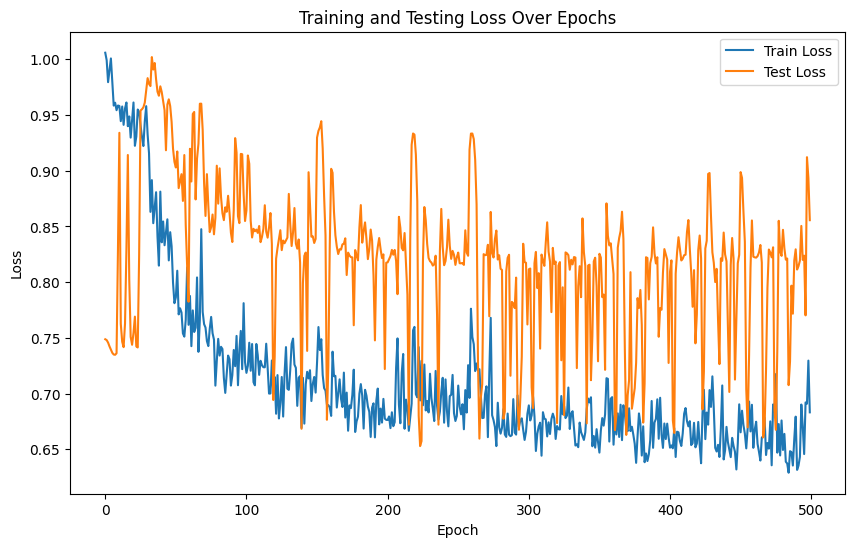

# Checking for Equivariance 

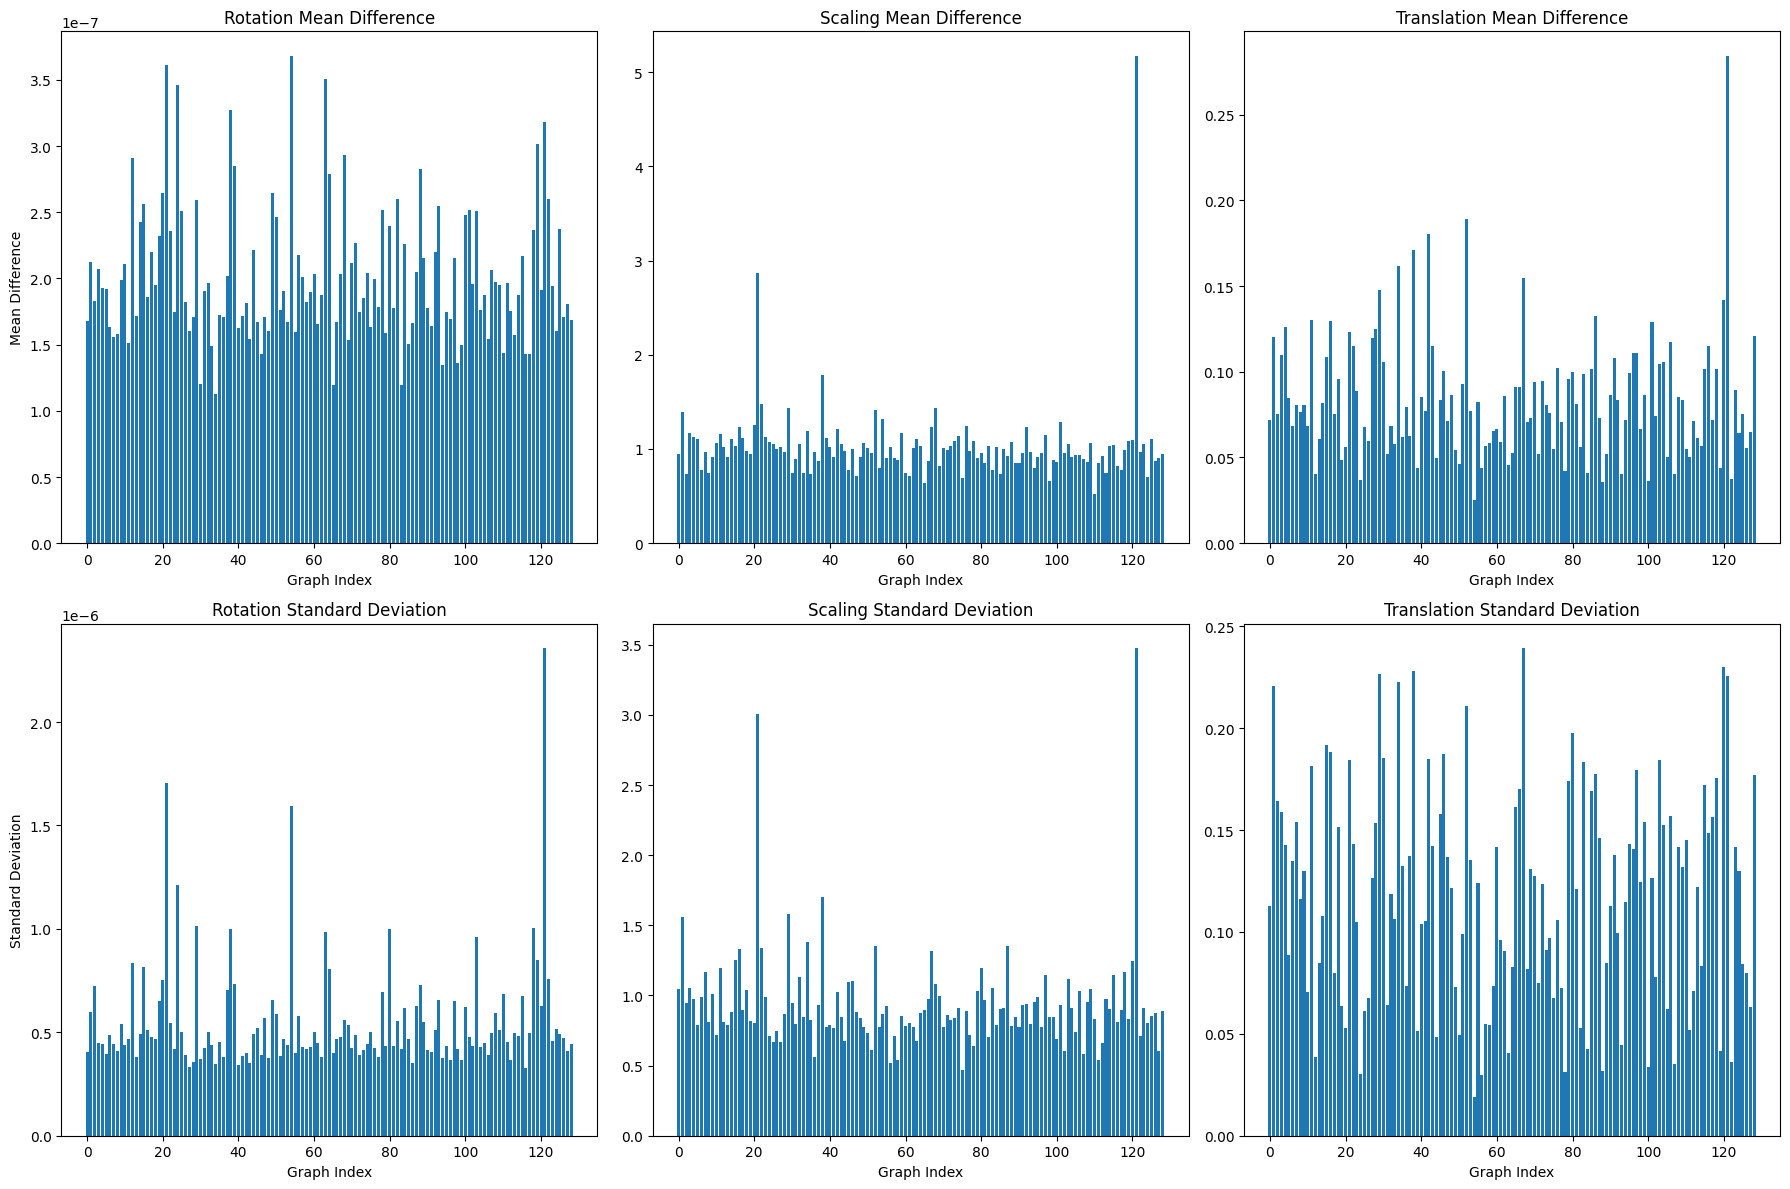

# Random Ablation Study GVP

Processing set 1 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 15, 16, 17, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 1 of 1000
Processing set 2 of 1000: Scalar Indices = (0, 1, 5, 6, 15, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 2 of 1000
Processing set 3 of 1000: Scalar Indices = (0, 5, 14, 15, 17, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.94it/s]


Completed set 3 of 1000
Processing set 4 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 17, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


Completed set 4 of 1000
Processing set 5 of 1000: Scalar Indices = (5, 6, 7, 8, 15, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 5 of 1000
Processing set 6 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 15, 16, 17, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 6 of 1000
Processing set 7 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 16, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.77it/s]


Completed set 7 of 1000
Processing set 8 of 1000: Scalar Indices = (0, 5, 6, 7, 14, 15, 17, 18, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 8 of 1000
Processing set 9 of 1000: Scalar Indices = (0, 6, 9, 10, 17, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 9 of 1000
Processing set 10 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 14, 15, 16, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 10 of 1000
Processing set 11 of 1000: Scalar Indices = (1, 6, 7, 10, 17, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


Completed set 11 of 1000
Processing set 12 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 15, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 12 of 1000
Processing set 13 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 13 of 1000
Processing set 14 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 14, 15, 16, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 14 of 1000
Processing set 15 of 1000: Scalar Indices = (0, 6, 8, 9, 14, 15, 16, 17, 18, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 15 of 1000
Processing set 16 of 1000: Scalar Indices = (1, 6, 9, 15, 16, 17, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 16 of 1000
Processing set 17 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 16, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 17 of 1000
Processing set 18 of 1000: Scalar Indices = (1, 5, 6, 14, 15, 17, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 18 of 1000
Processing set 19 of 1000: Scalar Indices = (0, 7, 9, 10, 14, 16, 18, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 19 of 1000
Processing set 20 of 1000: Scalar Indices = (5, 7, 8, 9, 14, 15, 16, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 20 of 1000
Processing set 21 of 1000: Scalar Indices = (6, 7, 9, 14, 15, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 21 of 1000
Processing set 22 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 15, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


Completed set 22 of 1000
Processing set 23 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 16, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


Completed set 23 of 1000
Processing set 24 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 14, 15, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 24 of 1000
Processing set 25 of 1000: Scalar Indices = (5, 6, 8, 9, 10, 14, 15, 16, 18, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 25 of 1000
Processing set 26 of 1000: Scalar Indices = (0, 5, 10, 14, 17, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 26 of 1000
Processing set 27 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 16, 17, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 27 of 1000
Processing set 28 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 15, 16, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 28 of 1000
Processing set 29 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 15, 19, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 29 of 1000
Processing set 30 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 14, 16, 17, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 30 of 1000
Processing set 31 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 17, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 31 of 1000
Processing set 32 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 10, 14, 15, 17, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 32 of 1000
Processing set 33 of 1000: Scalar Indices = (1, 5, 9, 10, 15, 17, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 33 of 1000
Processing set 34 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 15, 16, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 34 of 1000
Processing set 35 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 35 of 1000
Processing set 36 of 1000: Scalar Indices = (1, 5, 8, 9, 14, 16, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 36 of 1000
Processing set 37 of 1000: Scalar Indices = (0, 6, 7, 8, 15, 17, 18, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 37 of 1000
Processing set 38 of 1000: Scalar Indices = (5, 7, 8, 10, 14, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 38 of 1000
Processing set 39 of 1000: Scalar Indices = (0, 1, 6, 14, 15, 17, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.03it/s]


Completed set 39 of 1000
Processing set 40 of 1000: Scalar Indices = (1, 5, 6, 10, 14, 16, 17, 18, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 40 of 1000
Processing set 41 of 1000: Scalar Indices = (1, 5, 6, 8, 16, 17, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 41 of 1000
Processing set 42 of 1000: Scalar Indices = (0, 6, 9, 10, 14, 16, 18, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 42 of 1000
Processing set 43 of 1000: Scalar Indices = (5, 7, 9, 10, 14, 15, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 43 of 1000
Processing set 44 of 1000: Scalar Indices = (0, 1, 5, 10, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.81it/s]


Completed set 44 of 1000
Processing set 45 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 15, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.72it/s]


Completed set 45 of 1000
Processing set 46 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 14, 16, 17, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 46 of 1000
Processing set 47 of 1000: Scalar Indices = (5, 6, 8, 14, 15, 16, 18, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 47 of 1000
Processing set 48 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 16, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 48 of 1000
Processing set 49 of 1000: Scalar Indices = (0, 5, 8, 10, 15, 16, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 49 of 1000
Processing set 50 of 1000: Scalar Indices = (5, 7, 8, 10, 15, 16, 17, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 50 of 1000
Processing set 51 of 1000: Scalar Indices = (0, 5, 6, 8, 10, 14, 16, 17, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]


Completed set 51 of 1000
Processing set 52 of 1000: Scalar Indices = (1, 6, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 52 of 1000
Processing set 53 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 14, 15, 16, 17, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 53 of 1000
Processing set 54 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 17, 18, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 54 of 1000
Processing set 55 of 1000: Scalar Indices = (5, 6, 10, 15, 16, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 55 of 1000
Processing set 56 of 1000: Scalar Indices = (0, 1, 5, 6, 14, 15, 16, 17, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 56 of 1000
Processing set 57 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 16, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 57 of 1000
Processing set 58 of 1000: Scalar Indices = (1, 5, 6, 8, 15, 17, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 58 of 1000
Processing set 59 of 1000: Scalar Indices = (0, 5, 6, 7, 10, 14, 16, 17, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 59 of 1000
Processing set 60 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 14, 16, 18, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 60 of 1000
Processing set 61 of 1000: Scalar Indices = (1, 8, 9, 10, 14, 16, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 61 of 1000
Processing set 62 of 1000: Scalar Indices = (5, 8, 10, 14, 15, 17, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 62 of 1000
Processing set 63 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 15, 16, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 63 of 1000
Processing set 64 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 64 of 1000
Processing set 65 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 14, 15, 17, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 65 of 1000
Processing set 66 of 1000: Scalar Indices = (1, 6, 14, 15, 16, 17, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 66 of 1000
Processing set 67 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 15, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 67 of 1000
Processing set 68 of 1000: Scalar Indices = (5, 8, 10, 15, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 68 of 1000
Processing set 69 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 69 of 1000
Processing set 70 of 1000: Scalar Indices = (5, 7, 14, 15, 16, 17, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 70 of 1000
Processing set 71 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 16, 18, 19, 20)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 71 of 1000
Processing set 72 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 15, 17, 18, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 72 of 1000
Processing set 73 of 1000: Scalar Indices = (7, 9, 10, 14, 15, 16, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 73 of 1000
Processing set 74 of 1000: Scalar Indices = (5, 7, 8, 10, 15, 16, 18, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 74 of 1000
Processing set 75 of 1000: Scalar Indices = (7, 8, 9, 14, 15, 16, 17, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 75 of 1000
Processing set 76 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 15, 16, 18, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 76 of 1000
Processing set 77 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 17, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 77 of 1000
Processing set 78 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 15, 16, 17, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 78 of 1000
Processing set 79 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 14, 15, 16, 17, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 79 of 1000
Processing set 80 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 14, 15, 16, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 80 of 1000
Processing set 81 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 15, 16, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 81 of 1000
Processing set 82 of 1000: Scalar Indices = (1, 5, 9, 14, 15, 16, 17, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 82 of 1000
Processing set 83 of 1000: Scalar Indices = (0, 1, 7, 10, 16, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 83 of 1000
Processing set 84 of 1000: Scalar Indices = (0, 1, 8, 10, 15, 16, 17, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 84 of 1000
Processing set 85 of 1000: Scalar Indices = (1, 7, 8, 9, 10, 14, 16, 17, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


Completed set 85 of 1000
Processing set 86 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 86 of 1000
Processing set 87 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 15, 16, 18, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.72it/s]


Completed set 87 of 1000
Processing set 88 of 1000: Scalar Indices = (5, 6, 7, 10, 14, 15, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.75it/s]


Completed set 88 of 1000
Processing set 89 of 1000: Scalar Indices = (1, 6, 7, 8, 14, 15, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 89 of 1000
Processing set 90 of 1000: Scalar Indices = (0, 1, 9, 14, 16, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 90 of 1000
Processing set 91 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 15, 16, 17, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 91 of 1000
Processing set 92 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 16, 17, 18, 19)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 92 of 1000
Processing set 93 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 14, 15, 17, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 93 of 1000
Processing set 94 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 14, 15, 16, 17, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.66it/s]


Completed set 94 of 1000
Processing set 95 of 1000: Scalar Indices = (0, 1, 10, 14, 15, 17, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 95 of 1000
Processing set 96 of 1000: Scalar Indices = (1, 5, 10, 14, 15, 16, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 96 of 1000
Processing set 97 of 1000: Scalar Indices = (5, 7, 8, 10, 14, 15, 16, 18, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 97 of 1000
Processing set 98 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 14, 15, 16, 17, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 98 of 1000
Processing set 99 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 14, 15, 17, 18, 19)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 99 of 1000
Processing set 100 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 15, 16, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 100 of 1000
Processing set 101 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 14, 16, 17, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 101 of 1000
Processing set 102 of 1000: Scalar Indices = (0, 5, 6, 7, 14, 16, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 102 of 1000
Processing set 103 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 14, 15, 16, 17, 18)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 103 of 1000
Processing set 104 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 14, 15, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 104 of 1000
Processing set 105 of 1000: Scalar Indices = (1, 5, 6, 9, 14, 15, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 105 of 1000
Processing set 106 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 15, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 106 of 1000
Processing set 107 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 15, 17, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


Completed set 107 of 1000
Processing set 108 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 16, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 108 of 1000
Processing set 109 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 109 of 1000
Processing set 110 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 15, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 110 of 1000
Processing set 111 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 14, 16, 18, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 111 of 1000
Processing set 112 of 1000: Scalar Indices = (1, 7, 15, 16, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.12it/s]


Completed set 112 of 1000
Processing set 113 of 1000: Scalar Indices = (0, 5, 6, 10, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.69it/s]


Completed set 113 of 1000
Processing set 114 of 1000: Scalar Indices = (1, 7, 8, 9, 16, 17, 18, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.73it/s]


Completed set 114 of 1000
Processing set 115 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 115 of 1000
Processing set 116 of 1000: Scalar Indices = (1, 8, 9, 10, 14, 15, 16, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 116 of 1000
Processing set 117 of 1000: Scalar Indices = (0, 6, 7, 14, 16, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 117 of 1000
Processing set 118 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 14, 16, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 118 of 1000
Processing set 119 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 15, 16, 17, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 119 of 1000
Processing set 120 of 1000: Scalar Indices = (8, 9, 10, 14, 16, 17, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 120 of 1000
Processing set 121 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 14, 16, 18, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 121 of 1000
Processing set 122 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 122 of 1000
Processing set 123 of 1000: Scalar Indices = (0, 5, 6, 8, 10, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 123 of 1000
Processing set 124 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 15, 16, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 124 of 1000
Processing set 125 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 16, 17, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 125 of 1000
Processing set 126 of 1000: Scalar Indices = (0, 5, 8, 10, 14, 15, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.71it/s]


Completed set 126 of 1000
Processing set 127 of 1000: Scalar Indices = (0, 5, 10, 15, 16, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 127 of 1000
Processing set 128 of 1000: Scalar Indices = (5, 7, 9, 10, 14, 18, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 128 of 1000
Processing set 129 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 17, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 129 of 1000
Processing set 130 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 14, 15, 17, 18, 19, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 130 of 1000
Processing set 131 of 1000: Scalar Indices = (0, 1, 6, 9, 16, 17, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 131 of 1000
Processing set 132 of 1000: Scalar Indices = (6, 8, 9, 10, 15, 16, 17, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 132 of 1000
Processing set 133 of 1000: Scalar Indices = (5, 6, 8, 10, 14, 15, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 133 of 1000
Processing set 134 of 1000: Scalar Indices = (0, 1, 10, 14, 15, 16, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 134 of 1000
Processing set 135 of 1000: Scalar Indices = (5, 6, 9, 10, 14, 15, 16, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 135 of 1000
Processing set 136 of 1000: Scalar Indices = (0, 6, 7, 10, 14, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 136 of 1000
Processing set 137 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 14, 17, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 137 of 1000
Processing set 138 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 16, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 138 of 1000
Processing set 139 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 139 of 1000
Processing set 140 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 14, 15, 17, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 140 of 1000
Processing set 141 of 1000: Scalar Indices = (5, 6, 7, 8, 10, 16, 18, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 141 of 1000
Processing set 142 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 17, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.66it/s]


Completed set 142 of 1000
Processing set 143 of 1000: Scalar Indices = (0, 1, 10, 14, 16, 17, 18, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 143 of 1000
Processing set 144 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 144 of 1000
Processing set 145 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 14, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 145 of 1000
Processing set 146 of 1000: Scalar Indices = (0, 6, 7, 8, 14, 15, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 146 of 1000
Processing set 147 of 1000: Scalar Indices = (5, 7, 8, 15, 16, 17, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 147 of 1000
Processing set 148 of 1000: Scalar Indices = (0, 8, 9, 14, 16, 18, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 148 of 1000
Processing set 149 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 15, 16, 17, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 149 of 1000
Processing set 150 of 1000: Scalar Indices = (0, 1, 7, 9, 14, 16, 17, 18, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 150 of 1000
Processing set 151 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 17, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 151 of 1000
Processing set 152 of 1000: Scalar Indices = (0, 7, 9, 10, 14, 16, 17, 18, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.71it/s]


Completed set 152 of 1000
Processing set 153 of 1000: Scalar Indices = (1, 5, 7, 15, 17, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.66it/s]


Completed set 153 of 1000
Processing set 154 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 17, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 154 of 1000
Processing set 155 of 1000: Scalar Indices = (0, 6, 7, 9, 14, 15, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 155 of 1000
Processing set 156 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 10, 14, 16, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 156 of 1000
Processing set 157 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 17, 19, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 157 of 1000
Processing set 158 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 14, 15, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 158 of 1000
Processing set 159 of 1000: Scalar Indices = (5, 6, 8, 10, 14, 15, 16, 17, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 159 of 1000
Processing set 160 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 16, 17, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 160 of 1000
Processing set 161 of 1000: Scalar Indices = (7, 8, 14, 17, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 161 of 1000
Processing set 162 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 15, 17, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 162 of 1000
Processing set 163 of 1000: Scalar Indices = (7, 8, 9, 14, 15, 18, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.68it/s]


Completed set 163 of 1000
Processing set 164 of 1000: Scalar Indices = (0, 5, 7, 8, 17, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 164 of 1000
Processing set 165 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 16, 17, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 165 of 1000
Processing set 166 of 1000: Scalar Indices = (6, 8, 9, 10, 15, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 166 of 1000
Processing set 167 of 1000: Scalar Indices = (0, 1, 6, 8, 9, 14, 17, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 167 of 1000
Processing set 168 of 1000: Scalar Indices = (5, 6, 8, 14, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 168 of 1000
Processing set 169 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 14, 16, 17, 18, 19, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 169 of 1000
Processing set 170 of 1000: Scalar Indices = (1, 5, 6, 10, 14, 16, 17, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 170 of 1000
Processing set 171 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 14, 16, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 171 of 1000
Processing set 172 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 14, 16, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 172 of 1000
Processing set 173 of 1000: Scalar Indices = (0, 5, 6, 14, 15, 17, 18, 19, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 173 of 1000
Processing set 174 of 1000: Scalar Indices = (0, 1, 10, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 174 of 1000
Processing set 175 of 1000: Scalar Indices = (0, 5, 10, 15, 16, 17, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 175 of 1000
Processing set 176 of 1000: Scalar Indices = (1, 6, 7, 9, 14, 15, 17, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 176 of 1000
Processing set 177 of 1000: Scalar Indices = (7, 8, 9, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 177 of 1000
Processing set 178 of 1000: Scalar Indices = (1, 6, 7, 14, 15, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 178 of 1000
Processing set 179 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 16, 17, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 179 of 1000
Processing set 180 of 1000: Scalar Indices = (1, 6, 7, 8, 14, 15, 16, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 180 of 1000
Processing set 181 of 1000: Scalar Indices = (0, 5, 6, 7, 15, 16, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 181 of 1000
Processing set 182 of 1000: Scalar Indices = (0, 1, 8, 9, 15, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 182 of 1000
Processing set 183 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 183 of 1000
Processing set 184 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 184 of 1000
Processing set 185 of 1000: Scalar Indices = (0, 1, 8, 10, 14, 15, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 185 of 1000
Processing set 186 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 14, 18, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 186 of 1000
Processing set 187 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 15, 16, 17, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 187 of 1000
Processing set 188 of 1000: Scalar Indices = (0, 1, 6, 7, 15, 17, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 188 of 1000
Processing set 189 of 1000: Scalar Indices = (1, 6, 8, 10, 14, 15, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 189 of 1000
Processing set 190 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 14, 16, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 190 of 1000
Processing set 191 of 1000: Scalar Indices = (0, 1, 7, 10, 14, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 191 of 1000
Processing set 192 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 15, 16, 17, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 192 of 1000
Processing set 193 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 14, 15, 16, 17, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 193 of 1000
Processing set 194 of 1000: Scalar Indices = (0, 5, 7, 9, 14, 15, 16, 18, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 194 of 1000
Processing set 195 of 1000: Scalar Indices = (7, 8, 10, 14, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 195 of 1000
Processing set 196 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 16, 18, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 196 of 1000
Processing set 197 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 14, 16, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 197 of 1000
Processing set 198 of 1000: Scalar Indices = (0, 5, 8, 9, 14, 15, 17, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 198 of 1000
Processing set 199 of 1000: Scalar Indices = (1, 5, 9, 10, 14, 16, 17, 18, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 199 of 1000
Processing set 200 of 1000: Scalar Indices = (1, 5, 6, 7, 17, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 200 of 1000
Processing set 201 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 14, 17, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 201 of 1000
Processing set 202 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 15, 16, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 202 of 1000
Processing set 203 of 1000: Scalar Indices = (0, 5, 7, 9, 14, 15, 16, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 203 of 1000
Processing set 204 of 1000: Scalar Indices = (6, 7, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 204 of 1000
Processing set 205 of 1000: Scalar Indices = (0, 5, 7, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 205 of 1000
Processing set 206 of 1000: Scalar Indices = (5, 7, 8, 9, 14, 15, 17, 19, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 206 of 1000
Processing set 207 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 17, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 207 of 1000
Processing set 208 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 15, 16, 17, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 208 of 1000
Processing set 209 of 1000: Scalar Indices = (0, 1, 5, 10, 14, 15, 16, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 209 of 1000
Processing set 210 of 1000: Scalar Indices = (0, 1, 6, 10, 14, 15, 16, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 210 of 1000
Processing set 211 of 1000: Scalar Indices = (0, 5, 7, 10, 16, 17, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 211 of 1000
Processing set 212 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 15, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 212 of 1000
Processing set 213 of 1000: Scalar Indices = (5, 7, 9, 10, 14, 15, 16, 17, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


Completed set 213 of 1000
Processing set 214 of 1000: Scalar Indices = (0, 5, 8, 10, 15, 16, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 214 of 1000
Processing set 215 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 15, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.78it/s]


Completed set 215 of 1000
Processing set 216 of 1000: Scalar Indices = (0, 5, 6, 10, 14, 15, 16, 17, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 216 of 1000
Processing set 217 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 15, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 217 of 1000
Processing set 218 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.68it/s]


Completed set 218 of 1000
Processing set 219 of 1000: Scalar Indices = (0, 1, 8, 16, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 219 of 1000
Processing set 220 of 1000: Scalar Indices = (5, 6, 7, 8, 10, 15, 16, 17, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 220 of 1000
Processing set 221 of 1000: Scalar Indices = (0, 5, 6, 7, 16, 17, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 221 of 1000
Processing set 222 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 15, 16, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 222 of 1000
Processing set 223 of 1000: Scalar Indices = (0, 1, 8, 9, 14, 15, 16, 17, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 223 of 1000
Processing set 224 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 224 of 1000
Processing set 225 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 225 of 1000
Processing set 226 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 15, 17, 18, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 226 of 1000
Processing set 227 of 1000: Scalar Indices = (1, 6, 9, 10, 14, 15, 16, 17, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 227 of 1000
Processing set 228 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 228 of 1000
Processing set 229 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 16, 17, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 229 of 1000
Processing set 230 of 1000: Scalar Indices = (1, 7, 8, 14, 16, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 230 of 1000
Processing set 231 of 1000: Scalar Indices = (5, 6, 8, 14, 15, 18, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 231 of 1000
Processing set 232 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 15, 16, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 232 of 1000
Processing set 233 of 1000: Scalar Indices = (8, 9, 10, 14, 15, 17, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 233 of 1000
Processing set 234 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 15, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 234 of 1000
Processing set 235 of 1000: Scalar Indices = (7, 9, 15, 17, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 235 of 1000
Processing set 236 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 14, 17, 18, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 236 of 1000
Processing set 237 of 1000: Scalar Indices = (0, 1, 9, 10, 16, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 237 of 1000
Processing set 238 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 15, 16, 17, 18, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 238 of 1000
Processing set 239 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 239 of 1000
Processing set 240 of 1000: Scalar Indices = (0, 6, 7, 10, 14, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.65it/s]


Completed set 240 of 1000
Processing set 241 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 15, 17, 18, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 241 of 1000
Processing set 242 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 15, 16, 18, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 242 of 1000
Processing set 243 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 14, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 243 of 1000
Processing set 244 of 1000: Scalar Indices = (0, 1, 6, 7, 10, 14, 16, 17, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 244 of 1000
Processing set 245 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 16, 18, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 245 of 1000
Processing set 246 of 1000: Scalar Indices = (0, 5, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 246 of 1000
Processing set 247 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 15, 16, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 247 of 1000
Processing set 248 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 14, 15, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 248 of 1000
Processing set 249 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 16, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 249 of 1000
Processing set 250 of 1000: Scalar Indices = (0, 1, 5, 10, 14, 15, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 250 of 1000
Processing set 251 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 16, 17, 18, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 251 of 1000
Processing set 252 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 10, 16, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


Completed set 252 of 1000
Processing set 253 of 1000: Scalar Indices = (7, 9, 10, 15, 16, 17, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 253 of 1000
Processing set 254 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 14, 17, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 254 of 1000
Processing set 255 of 1000: Scalar Indices = (0, 1, 7, 10, 16, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 255 of 1000
Processing set 256 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 256 of 1000
Processing set 257 of 1000: Scalar Indices = (5, 7, 14, 15, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 257 of 1000
Processing set 258 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 15, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 258 of 1000
Processing set 259 of 1000: Scalar Indices = (0, 5, 9, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 259 of 1000
Processing set 260 of 1000: Scalar Indices = (0, 5, 7, 10, 16, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 260 of 1000
Processing set 261 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 15, 16, 18, 19, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 261 of 1000
Processing set 262 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 15, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 262 of 1000
Processing set 263 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 15, 16, 17, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 263 of 1000
Processing set 264 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 264 of 1000
Processing set 265 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 15, 16, 18, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 265 of 1000
Processing set 266 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 14, 17, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 266 of 1000
Processing set 267 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 14, 15, 16, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 267 of 1000
Processing set 268 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 268 of 1000
Processing set 269 of 1000: Scalar Indices = (1, 6, 10, 14, 15, 16, 18, 19, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 269 of 1000
Processing set 270 of 1000: Scalar Indices = (1, 6, 7, 9, 14, 16, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 270 of 1000
Processing set 271 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 18, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 271 of 1000
Processing set 272 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 14, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 272 of 1000
Processing set 273 of 1000: Scalar Indices = (1, 6, 8, 9, 14, 15, 16, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 273 of 1000
Processing set 274 of 1000: Scalar Indices = (1, 6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 274 of 1000
Processing set 275 of 1000: Scalar Indices = (0, 5, 7, 14, 15, 16, 17, 18, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 275 of 1000
Processing set 276 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 276 of 1000
Processing set 277 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 14, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 277 of 1000
Processing set 278 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 16, 17, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 278 of 1000
Processing set 279 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 14, 15, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 279 of 1000
Processing set 280 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 14, 16, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 280 of 1000
Processing set 281 of 1000: Scalar Indices = (1, 6, 7, 8, 10, 14, 15, 17, 18, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 281 of 1000
Processing set 282 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 16, 17, 18, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 282 of 1000
Processing set 283 of 1000: Scalar Indices = (0, 1, 7, 8, 16, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 283 of 1000
Processing set 284 of 1000: Scalar Indices = (1, 5, 7, 10, 14, 15, 17, 18, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 284 of 1000
Processing set 285 of 1000: Scalar Indices = (1, 5, 6, 9, 14, 15, 17, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 285 of 1000
Processing set 286 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 15, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 286 of 1000
Processing set 287 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 287 of 1000
Processing set 288 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 288 of 1000
Processing set 289 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 289 of 1000
Processing set 290 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 16, 17, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 290 of 1000
Processing set 291 of 1000: Scalar Indices = (5, 7, 8, 9, 15, 16, 17, 18, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 291 of 1000
Processing set 292 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 15, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 292 of 1000
Processing set 293 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 293 of 1000
Processing set 294 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 15, 17, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 294 of 1000
Processing set 295 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 15, 16, 17, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 295 of 1000
Processing set 296 of 1000: Scalar Indices = (7, 8, 10, 15, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 296 of 1000
Processing set 297 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 17, 18, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 297 of 1000
Processing set 298 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 15, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 298 of 1000
Processing set 299 of 1000: Scalar Indices = (0, 6, 9, 16, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.03it/s]


Completed set 299 of 1000
Processing set 300 of 1000: Scalar Indices = (0, 1, 7, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 300 of 1000
Processing set 301 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 15, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 301 of 1000
Processing set 302 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 15, 16, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 302 of 1000
Processing set 303 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 17, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.94it/s]


Completed set 303 of 1000
Processing set 304 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 16, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 304 of 1000
Processing set 305 of 1000: Scalar Indices = (0, 7, 10, 14, 16, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 305 of 1000
Processing set 306 of 1000: Scalar Indices = (0, 1, 7, 16, 17, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 306 of 1000
Processing set 307 of 1000: Scalar Indices = (1, 6, 7, 9, 15, 17, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 307 of 1000
Processing set 308 of 1000: Scalar Indices = (1, 5, 8, 9, 16, 17, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 308 of 1000
Processing set 309 of 1000: Scalar Indices = (1, 9, 10, 14, 15, 16, 17, 18, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 309 of 1000
Processing set 310 of 1000: Scalar Indices = (5, 6, 9, 14, 17, 18, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 310 of 1000
Processing set 311 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 15, 16, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 311 of 1000
Processing set 312 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 10, 16, 17, 18, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 312 of 1000
Processing set 313 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 16, 18, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 313 of 1000
Processing set 314 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 17, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 314 of 1000
Processing set 315 of 1000: Scalar Indices = (0, 7, 8, 10, 15, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 315 of 1000
Processing set 316 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 316 of 1000
Processing set 317 of 1000: Scalar Indices = (6, 7, 8, 15, 17, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 317 of 1000
Processing set 318 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 17, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 318 of 1000
Processing set 319 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 14, 15, 17, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 319 of 1000
Processing set 320 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 14, 15, 17, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 320 of 1000
Processing set 321 of 1000: Scalar Indices = (0, 1, 6, 7, 15, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 321 of 1000
Processing set 322 of 1000: Scalar Indices = (0, 1, 6, 10, 16, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 322 of 1000
Processing set 323 of 1000: Scalar Indices = (6, 7, 9, 10, 14, 15, 16, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 323 of 1000
Processing set 324 of 1000: Scalar Indices = (1, 5, 6, 7, 14, 16, 17, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 324 of 1000
Processing set 325 of 1000: Scalar Indices = (5, 7, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 325 of 1000
Processing set 326 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 16, 17, 18, 19, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 326 of 1000
Processing set 327 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 16, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 327 of 1000
Processing set 328 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 328 of 1000
Processing set 329 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 15, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.55it/s]


Completed set 329 of 1000
Processing set 330 of 1000: Scalar Indices = (1, 5, 6, 9, 15, 16, 17, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 330 of 1000
Processing set 331 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 16, 17, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 331 of 1000
Processing set 332 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 14, 16, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 332 of 1000
Processing set 333 of 1000: Scalar Indices = (1, 5, 7, 14, 17, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 333 of 1000
Processing set 334 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 14, 15, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Completed set 334 of 1000
Processing set 335 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 15, 16, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 335 of 1000
Processing set 336 of 1000: Scalar Indices = (6, 9, 10, 14, 15, 17, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


Completed set 336 of 1000
Processing set 337 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 16, 17, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 337 of 1000
Processing set 338 of 1000: Scalar Indices = (0, 7, 9, 17, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 338 of 1000
Processing set 339 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 15, 16, 17, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]


Completed set 339 of 1000
Processing set 340 of 1000: Scalar Indices = (1, 5, 6, 9, 14, 16, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 340 of 1000
Processing set 341 of 1000: Scalar Indices = (5, 6, 7, 9, 10, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 341 of 1000
Processing set 342 of 1000: Scalar Indices = (0, 1, 6, 10, 17, 18, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 342 of 1000
Processing set 343 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 14, 15, 16, 17, 18, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 343 of 1000
Processing set 344 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 15, 16, 18, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 344 of 1000
Processing set 345 of 1000: Scalar Indices = (6, 9, 15, 16, 17, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 345 of 1000
Processing set 346 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 14, 16, 17, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 346 of 1000
Processing set 347 of 1000: Scalar Indices = (6, 9, 10, 14, 15, 16, 17, 18, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 347 of 1000
Processing set 348 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 14, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 348 of 1000
Processing set 349 of 1000: Scalar Indices = (0, 6, 7, 10, 14, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 349 of 1000
Processing set 350 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 15, 16, 17, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 350 of 1000
Processing set 351 of 1000: Scalar Indices = (0, 1, 7, 8, 10, 14, 15, 17, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 351 of 1000
Processing set 352 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 14, 15, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 352 of 1000
Processing set 353 of 1000: Scalar Indices = (1, 5, 10, 15, 16, 17, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 353 of 1000
Processing set 354 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 15, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 354 of 1000
Processing set 355 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 15, 16, 17, 18, 19)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 355 of 1000
Processing set 356 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 14, 16, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 356 of 1000
Processing set 357 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 14, 15, 17, 18, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 357 of 1000
Processing set 358 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 358 of 1000
Processing set 359 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 14, 15, 16, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 359 of 1000
Processing set 360 of 1000: Scalar Indices = (0, 5, 8, 9, 10, 15, 17, 19, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 360 of 1000
Processing set 361 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 15, 16, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 361 of 1000
Processing set 362 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 14, 16, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 362 of 1000
Processing set 363 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 15, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 363 of 1000
Processing set 364 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 16, 18, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 364 of 1000
Processing set 365 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 15, 16, 17, 19, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 365 of 1000
Processing set 366 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 14, 17, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 366 of 1000
Processing set 367 of 1000: Scalar Indices = (6, 9, 10, 14, 15, 16, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.67it/s]


Completed set 367 of 1000
Processing set 368 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 16, 17, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Completed set 368 of 1000
Processing set 369 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 369 of 1000
Processing set 370 of 1000: Scalar Indices = (0, 5, 6, 8, 10, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 370 of 1000
Processing set 371 of 1000: Scalar Indices = (0, 6, 8, 14, 15, 17, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 371 of 1000
Processing set 372 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 16, 17, 18, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 372 of 1000
Processing set 373 of 1000: Scalar Indices = (5, 8, 10, 14, 15, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 373 of 1000
Processing set 374 of 1000: Scalar Indices = (0, 6, 7, 8, 15, 17, 18, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 374 of 1000
Processing set 375 of 1000: Scalar Indices = (0, 7, 9, 10, 15, 16, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 375 of 1000
Processing set 376 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 15, 17, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 376 of 1000
Processing set 377 of 1000: Scalar Indices = (1, 6, 8, 14, 15, 17, 18, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 377 of 1000
Processing set 378 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 15, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 378 of 1000
Processing set 379 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 16, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 379 of 1000
Processing set 380 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 16, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


Completed set 380 of 1000
Processing set 381 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 381 of 1000
Processing set 382 of 1000: Scalar Indices = (0, 5, 7, 8, 16, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 382 of 1000
Processing set 383 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 14, 15, 16, 17, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 383 of 1000
Processing set 384 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 14, 15, 16, 18, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 384 of 1000
Processing set 385 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 15, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 385 of 1000
Processing set 386 of 1000: Scalar Indices = (5, 6, 8, 9, 14, 16, 17, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 386 of 1000
Processing set 387 of 1000: Scalar Indices = (0, 5, 6, 9, 14, 15, 16, 17, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 387 of 1000
Processing set 388 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 16, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 388 of 1000
Processing set 389 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 15, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 389 of 1000
Processing set 390 of 1000: Scalar Indices = (1, 5, 6, 8, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 390 of 1000
Processing set 391 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 18, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 391 of 1000
Processing set 392 of 1000: Scalar Indices = (1, 5, 8, 9, 14, 15, 16, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 392 of 1000
Processing set 393 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 16, 17, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 393 of 1000
Processing set 394 of 1000: Scalar Indices = (0, 1, 5, 7, 14, 17, 18, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 394 of 1000
Processing set 395 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 15, 16, 17, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 395 of 1000
Processing set 396 of 1000: Scalar Indices = (0, 1, 8, 9, 10, 14, 15, 16, 17, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 396 of 1000
Processing set 397 of 1000: Scalar Indices = (1, 6, 7, 8, 15, 16, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 397 of 1000
Processing set 398 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 398 of 1000
Processing set 399 of 1000: Scalar Indices = (0, 8, 9, 10, 16, 17, 18, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 399 of 1000
Processing set 400 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 15, 16, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 400 of 1000
Processing set 401 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 14, 16, 18, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 401 of 1000
Processing set 402 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 402 of 1000
Processing set 403 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 14, 15, 16, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 403 of 1000
Processing set 404 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 15, 17, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 404 of 1000
Processing set 405 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 15, 17, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 405 of 1000
Processing set 406 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 406 of 1000
Processing set 407 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 16, 18, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 407 of 1000
Processing set 408 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 16, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 408 of 1000
Processing set 409 of 1000: Scalar Indices = (1, 7, 9, 10, 16, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 409 of 1000
Processing set 410 of 1000: Scalar Indices = (5, 7, 9, 16, 17, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 410 of 1000
Processing set 411 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 16, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 411 of 1000
Processing set 412 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 14, 16, 18, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 412 of 1000
Processing set 413 of 1000: Scalar Indices = (0, 5, 6, 8, 16, 17, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 413 of 1000
Processing set 414 of 1000: Scalar Indices = (0, 1, 5, 9, 14, 16, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 414 of 1000
Processing set 415 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 15, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 415 of 1000
Processing set 416 of 1000: Scalar Indices = (1, 6, 8, 14, 15, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 416 of 1000
Processing set 417 of 1000: Scalar Indices = (7, 8, 9, 14, 15, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 417 of 1000
Processing set 418 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 15, 18, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 418 of 1000
Processing set 419 of 1000: Scalar Indices = (1, 5, 8, 9, 15, 16, 17, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 419 of 1000
Processing set 420 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 17, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 420 of 1000
Processing set 421 of 1000: Scalar Indices = (6, 9, 10, 14, 15, 17, 18, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 421 of 1000
Processing set 422 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 16, 17, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 422 of 1000
Processing set 423 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 16, 17, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 423 of 1000
Processing set 424 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 15, 16, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 424 of 1000
Processing set 425 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 15, 16, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 425 of 1000
Processing set 426 of 1000: Scalar Indices = (5, 6, 8, 10, 15, 18, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 426 of 1000
Processing set 427 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 17, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 427 of 1000
Processing set 428 of 1000: Scalar Indices = (0, 5, 6, 8, 10, 14, 16, 17, 18, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 428 of 1000
Processing set 429 of 1000: Scalar Indices = (0, 5, 7, 10, 15, 16, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 429 of 1000
Processing set 430 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 15, 16, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 430 of 1000
Processing set 431 of 1000: Scalar Indices = (9, 10, 14, 15, 16, 17, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 431 of 1000
Processing set 432 of 1000: Scalar Indices = (0, 5, 7, 9, 10, 14, 15, 17, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 432 of 1000
Processing set 433 of 1000: Scalar Indices = (0, 5, 8, 9, 14, 16, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 433 of 1000
Processing set 434 of 1000: Scalar Indices = (1, 7, 8, 9, 10, 14, 15, 16, 17, 19, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 434 of 1000
Processing set 435 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 14, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 435 of 1000
Processing set 436 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 17, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 436 of 1000
Processing set 437 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 14, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 437 of 1000
Processing set 438 of 1000: Scalar Indices = (1, 6, 8, 10, 15, 17, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 438 of 1000
Processing set 439 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 16, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 439 of 1000
Processing set 440 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 16, 17, 19, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 440 of 1000
Processing set 441 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 15, 16, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 441 of 1000
Processing set 442 of 1000: Scalar Indices = (9, 10, 15, 17, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 442 of 1000
Processing set 443 of 1000: Scalar Indices = (0, 1, 6, 9, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 443 of 1000
Processing set 444 of 1000: Scalar Indices = (6, 7, 10, 14, 15, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 444 of 1000
Processing set 445 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 16, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 445 of 1000
Processing set 446 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 10, 14, 16, 17, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.71it/s]


Completed set 446 of 1000
Processing set 447 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 15, 18, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 447 of 1000
Processing set 448 of 1000: Scalar Indices = (0, 6, 7, 9, 10, 14, 16, 17, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 448 of 1000
Processing set 449 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 15, 16, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 449 of 1000
Processing set 450 of 1000: Scalar Indices = (1, 6, 9, 10, 14, 17, 18, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 450 of 1000
Processing set 451 of 1000: Scalar Indices = (0, 1, 6, 8, 15, 17, 18, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 451 of 1000
Processing set 452 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 14, 15, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 452 of 1000
Processing set 453 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 15, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 453 of 1000
Processing set 454 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 18, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 454 of 1000
Processing set 455 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Completed set 455 of 1000
Processing set 456 of 1000: Scalar Indices = (1, 5, 9, 10, 14, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 456 of 1000
Processing set 457 of 1000: Scalar Indices = (5, 6, 7, 9, 10, 17, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


Completed set 457 of 1000
Processing set 458 of 1000: Scalar Indices = (0, 6, 7, 9, 14, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 458 of 1000
Processing set 459 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 14, 16, 17, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 459 of 1000
Processing set 460 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 460 of 1000
Processing set 461 of 1000: Scalar Indices = (0, 5, 6, 7, 10, 14, 15, 16, 17, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 461 of 1000
Processing set 462 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 16, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 462 of 1000
Processing set 463 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 16, 18, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 463 of 1000
Processing set 464 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 464 of 1000
Processing set 465 of 1000: Scalar Indices = (1, 5, 6, 14, 17, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


Completed set 465 of 1000
Processing set 466 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 466 of 1000
Processing set 467 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 15, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 467 of 1000
Processing set 468 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 14, 15, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 468 of 1000
Processing set 469 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 14, 15, 18, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 469 of 1000
Processing set 470 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 15, 16, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 470 of 1000
Processing set 471 of 1000: Scalar Indices = (0, 7, 9, 14, 17, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 471 of 1000
Processing set 472 of 1000: Scalar Indices = (0, 1, 9, 14, 15, 16, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 472 of 1000
Processing set 473 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 15, 16, 17, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 473 of 1000
Processing set 474 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 14, 15, 17, 19, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.94it/s]


Completed set 474 of 1000
Processing set 475 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 14, 17, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 475 of 1000
Processing set 476 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 15, 17, 18, 20)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 476 of 1000
Processing set 477 of 1000: Scalar Indices = (1, 5, 6, 9, 14, 16, 18, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 477 of 1000
Processing set 478 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 15, 17, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 478 of 1000
Processing set 479 of 1000: Scalar Indices = (1, 5, 6, 8, 14, 17, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 479 of 1000
Processing set 480 of 1000: Scalar Indices = (1, 6, 9, 14, 15, 16, 17, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 480 of 1000
Processing set 481 of 1000: Scalar Indices = (0, 1, 6, 7, 14, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 481 of 1000
Processing set 482 of 1000: Scalar Indices = (6, 7, 8, 9, 15, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Completed set 482 of 1000
Processing set 483 of 1000: Scalar Indices = (5, 6, 8, 10, 14, 16, 17, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 483 of 1000
Processing set 484 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 16, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.71it/s]


Completed set 484 of 1000
Processing set 485 of 1000: Scalar Indices = (0, 9, 10, 14, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 485 of 1000
Processing set 486 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 486 of 1000
Processing set 487 of 1000: Scalar Indices = (0, 1, 14, 15, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 487 of 1000
Processing set 488 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 17, 18, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 488 of 1000
Processing set 489 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 15, 16, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 489 of 1000
Processing set 490 of 1000: Scalar Indices = (5, 7, 8, 9, 14, 15, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 490 of 1000
Processing set 491 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 17, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 491 of 1000
Processing set 492 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 16, 17, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 492 of 1000
Processing set 493 of 1000: Scalar Indices = (0, 6, 8, 14, 16, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 493 of 1000
Processing set 494 of 1000: Scalar Indices = (1, 5, 7, 9, 14, 15, 16, 18, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 494 of 1000
Processing set 495 of 1000: Scalar Indices = (8, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 495 of 1000
Processing set 496 of 1000: Scalar Indices = (0, 1, 8, 9, 16, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 496 of 1000
Processing set 497 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 14, 15, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 497 of 1000
Processing set 498 of 1000: Scalar Indices = (0, 7, 10, 14, 18, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 498 of 1000
Processing set 499 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 499 of 1000
Processing set 500 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 15, 16, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 500 of 1000
Processing set 501 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 16, 17, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 501 of 1000
Processing set 502 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 14, 15, 16, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 502 of 1000
Processing set 503 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 503 of 1000
Processing set 504 of 1000: Scalar Indices = (0, 5, 8, 9, 10, 15, 16, 17, 18, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 504 of 1000
Processing set 505 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 14, 16, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 505 of 1000
Processing set 506 of 1000: Scalar Indices = (0, 5, 6, 8, 16, 17, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 506 of 1000
Processing set 507 of 1000: Scalar Indices = (6, 8, 10, 15, 17, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 507 of 1000
Processing set 508 of 1000: Scalar Indices = (7, 9, 10, 14, 15, 16, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 508 of 1000
Processing set 509 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 15, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 509 of 1000
Processing set 510 of 1000: Scalar Indices = (1, 5, 7, 8, 16, 17, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 510 of 1000
Processing set 511 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 15, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 511 of 1000
Processing set 512 of 1000: Scalar Indices = (7, 8, 9, 10, 16, 17, 18, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 512 of 1000
Processing set 513 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 15, 16, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 513 of 1000
Processing set 514 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 15, 17, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 514 of 1000
Processing set 515 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 16, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 515 of 1000
Processing set 516 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 516 of 1000
Processing set 517 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 15, 16, 17, 18, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 517 of 1000
Processing set 518 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 16, 17, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 518 of 1000
Processing set 519 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 15, 16, 17, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 519 of 1000
Processing set 520 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 15, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


Completed set 520 of 1000
Processing set 521 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 14, 15, 17, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 521 of 1000
Processing set 522 of 1000: Scalar Indices = (1, 5, 6, 10, 14, 18, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 522 of 1000
Processing set 523 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 17, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 523 of 1000
Processing set 524 of 1000: Scalar Indices = (5, 7, 9, 10, 14, 16, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 524 of 1000
Processing set 525 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 14, 15, 16, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 525 of 1000
Processing set 526 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 14, 15, 16, 17, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 526 of 1000
Processing set 527 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 527 of 1000
Processing set 528 of 1000: Scalar Indices = (0, 1, 7, 8, 10, 16, 17, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 528 of 1000
Processing set 529 of 1000: Scalar Indices = (5, 6, 8, 14, 15, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 529 of 1000
Processing set 530 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 15, 16, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 530 of 1000
Processing set 531 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 17, 18, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 531 of 1000
Processing set 532 of 1000: Scalar Indices = (1, 5, 7, 14, 15, 17, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 532 of 1000
Processing set 533 of 1000: Scalar Indices = (5, 6, 7, 10, 14, 15, 17, 18, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 533 of 1000
Processing set 534 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 15, 16, 17, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 534 of 1000
Processing set 535 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 15, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 535 of 1000
Processing set 536 of 1000: Scalar Indices = (0, 7, 10, 15, 17, 18, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 536 of 1000
Processing set 537 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 17, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 537 of 1000
Processing set 538 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 16, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 538 of 1000
Processing set 539 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.13it/s]


Completed set 539 of 1000
Processing set 540 of 1000: Scalar Indices = (0, 1, 5, 10, 14, 15, 16, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 540 of 1000
Processing set 541 of 1000: Scalar Indices = (0, 5, 8, 9, 10, 15, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 541 of 1000
Processing set 542 of 1000: Scalar Indices = (1, 7, 9, 14, 16, 17, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 542 of 1000
Processing set 543 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 15, 16, 17, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 543 of 1000
Processing set 544 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 544 of 1000
Processing set 545 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 15, 16, 17, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 545 of 1000
Processing set 546 of 1000: Scalar Indices = (0, 6, 8, 10, 15, 16, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 546 of 1000
Processing set 547 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 15, 16, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 547 of 1000
Processing set 548 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 16, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 548 of 1000
Processing set 549 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 15, 16, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 549 of 1000
Processing set 550 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 10, 17, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 550 of 1000
Processing set 551 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 14, 15, 17, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 551 of 1000
Processing set 552 of 1000: Scalar Indices = (0, 1, 7, 9, 14, 15, 16, 17, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 552 of 1000
Processing set 553 of 1000: Scalar Indices = (0, 7, 8, 10, 15, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 553 of 1000
Processing set 554 of 1000: Scalar Indices = (5, 8, 9, 10, 14, 15, 16, 17, 18, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 554 of 1000
Processing set 555 of 1000: Scalar Indices = (0, 1, 7, 8, 14, 16, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 555 of 1000
Processing set 556 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 17, 18, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 556 of 1000
Processing set 557 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 16, 17, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 557 of 1000
Processing set 558 of 1000: Scalar Indices = (1, 6, 8, 9, 14, 15, 17, 18, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 558 of 1000
Processing set 559 of 1000: Scalar Indices = (1, 5, 9, 14, 17, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 559 of 1000
Processing set 560 of 1000: Scalar Indices = (1, 5, 6, 7, 14, 17, 18, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 560 of 1000
Processing set 561 of 1000: Scalar Indices = (5, 7, 8, 9, 15, 16, 18, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 561 of 1000
Processing set 562 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 562 of 1000
Processing set 563 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 14, 16, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 563 of 1000
Processing set 564 of 1000: Scalar Indices = (6, 8, 9, 14, 15, 16, 18, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 564 of 1000
Processing set 565 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 15, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 565 of 1000
Processing set 566 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 566 of 1000
Processing set 567 of 1000: Scalar Indices = (0, 9, 10, 14, 15, 16, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 567 of 1000
Processing set 568 of 1000: Scalar Indices = (1, 6, 7, 8, 10, 17, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 568 of 1000
Processing set 569 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 15, 16, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 569 of 1000
Processing set 570 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 570 of 1000
Processing set 571 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 15, 17, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


Completed set 571 of 1000
Processing set 572 of 1000: Scalar Indices = (5, 6, 7, 15, 17, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 572 of 1000
Processing set 573 of 1000: Scalar Indices = (0, 6, 7, 9, 10, 15, 17, 18, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 573 of 1000
Processing set 574 of 1000: Scalar Indices = (1, 6, 7, 14, 15, 16, 17, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 574 of 1000
Processing set 575 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 17, 18, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 575 of 1000
Processing set 576 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 15, 16, 18, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 576 of 1000
Processing set 577 of 1000: Scalar Indices = (0, 1, 6, 8, 9, 10, 14, 15, 17, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 577 of 1000
Processing set 578 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 16, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 578 of 1000
Processing set 579 of 1000: Scalar Indices = (0, 5, 10, 14, 15, 16, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 579 of 1000
Processing set 580 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 14, 15, 17, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 580 of 1000
Processing set 581 of 1000: Scalar Indices = (0, 5, 7, 16, 17, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 581 of 1000
Processing set 582 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 582 of 1000
Processing set 583 of 1000: Scalar Indices = (0, 1, 6, 8, 14, 15, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 583 of 1000
Processing set 584 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 15, 16, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 584 of 1000
Processing set 585 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 16, 17, 18, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 585 of 1000
Processing set 586 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 586 of 1000
Processing set 587 of 1000: Scalar Indices = (5, 7, 9, 10, 16, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 587 of 1000
Processing set 588 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 588 of 1000
Processing set 589 of 1000: Scalar Indices = (0, 1, 6, 14, 17, 18, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 589 of 1000
Processing set 590 of 1000: Scalar Indices = (6, 7, 8, 10, 14, 15, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 590 of 1000
Processing set 591 of 1000: Scalar Indices = (5, 6, 8, 9, 16, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 591 of 1000
Processing set 592 of 1000: Scalar Indices = (5, 6, 7, 8, 10, 15, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 592 of 1000
Processing set 593 of 1000: Scalar Indices = (6, 7, 8, 14, 15, 16, 17, 18, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 593 of 1000
Processing set 594 of 1000: Scalar Indices = (0, 6, 8, 9, 15, 17, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 594 of 1000
Processing set 595 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 14, 16, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 595 of 1000
Processing set 596 of 1000: Scalar Indices = (5, 6, 7, 8, 15, 16, 17, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 596 of 1000
Processing set 597 of 1000: Scalar Indices = (1, 6, 8, 16, 17, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 597 of 1000
Processing set 598 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 15, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 598 of 1000
Processing set 599 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 15, 18, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 599 of 1000
Processing set 600 of 1000: Scalar Indices = (0, 5, 10, 14, 15, 16, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 600 of 1000
Processing set 601 of 1000: Scalar Indices = (6, 7, 8, 14, 15, 16, 17, 19, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.63it/s]


Completed set 601 of 1000
Processing set 602 of 1000: Scalar Indices = (0, 6, 8, 9, 15, 16, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 602 of 1000
Processing set 603 of 1000: Scalar Indices = (0, 5, 7, 9, 15, 16, 17, 18, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 603 of 1000
Processing set 604 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 14, 15, 17, 18, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 604 of 1000
Processing set 605 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 14, 15, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 605 of 1000
Processing set 606 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 14, 16, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 606 of 1000
Processing set 607 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


Completed set 607 of 1000
Processing set 608 of 1000: Scalar Indices = (5, 6, 7, 9, 10, 14, 15, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 608 of 1000
Processing set 609 of 1000: Scalar Indices = (0, 1, 6, 8, 15, 17, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 609 of 1000
Processing set 610 of 1000: Scalar Indices = (1, 5, 8, 15, 16, 18, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 610 of 1000
Processing set 611 of 1000: Scalar Indices = (0, 1, 14, 15, 17, 18, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 611 of 1000
Processing set 612 of 1000: Scalar Indices = (0, 5, 6, 7, 14, 15, 17, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 612 of 1000
Processing set 613 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 16, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 613 of 1000
Processing set 614 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 14, 18, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 614 of 1000
Processing set 615 of 1000: Scalar Indices = (0, 1, 5, 9, 16, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 615 of 1000
Processing set 616 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 16, 17, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 616 of 1000
Processing set 617 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 14, 16, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 617 of 1000
Processing set 618 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 15, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 618 of 1000
Processing set 619 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 15, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 619 of 1000
Processing set 620 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 15, 16, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 620 of 1000
Processing set 621 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 17, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 621 of 1000
Processing set 622 of 1000: Scalar Indices = (5, 6, 8, 9, 16, 18, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 622 of 1000
Processing set 623 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 15, 16, 17, 18, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.62it/s]


Completed set 623 of 1000
Processing set 624 of 1000: Scalar Indices = (5, 7, 9, 14, 16, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 624 of 1000
Processing set 625 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 17, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 625 of 1000
Processing set 626 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 14, 15, 17, 18, 19, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 626 of 1000
Processing set 627 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 627 of 1000
Processing set 628 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 15, 17, 18, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 628 of 1000
Processing set 629 of 1000: Scalar Indices = (0, 1, 5, 7, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 629 of 1000
Processing set 630 of 1000: Scalar Indices = (0, 7, 9, 15, 16, 17, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 630 of 1000
Processing set 631 of 1000: Scalar Indices = (0, 1, 5, 10, 14, 15, 16, 18, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 631 of 1000
Processing set 632 of 1000: Scalar Indices = (1, 6, 9, 16, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 632 of 1000
Processing set 633 of 1000: Scalar Indices = (7, 8, 15, 16, 17, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 633 of 1000
Processing set 634 of 1000: Scalar Indices = (0, 7, 8, 9, 14, 15, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 634 of 1000
Processing set 635 of 1000: Scalar Indices = (0, 1, 5, 15, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.81it/s]


Completed set 635 of 1000
Processing set 636 of 1000: Scalar Indices = (0, 5, 9, 10, 15, 17, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 636 of 1000
Processing set 637 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 16, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 637 of 1000
Processing set 638 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 15, 16, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


Completed set 638 of 1000
Processing set 639 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 16, 17, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 639 of 1000
Processing set 640 of 1000: Scalar Indices = (0, 1, 5, 8, 15, 16, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 640 of 1000
Processing set 641 of 1000: Scalar Indices = (1, 5, 6, 9, 16, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 641 of 1000
Processing set 642 of 1000: Scalar Indices = (0, 1, 5, 14, 15, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 642 of 1000
Processing set 643 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 16, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 643 of 1000
Processing set 644 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 16, 18, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 644 of 1000
Processing set 645 of 1000: Scalar Indices = (0, 1, 5, 9, 14, 16, 17, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 645 of 1000
Processing set 646 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 15, 17, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 646 of 1000
Processing set 647 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 647 of 1000
Processing set 648 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 15, 17, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.03it/s]


Completed set 648 of 1000
Processing set 649 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 18, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 649 of 1000
Processing set 650 of 1000: Scalar Indices = (7, 9, 10, 14, 15, 17, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 650 of 1000
Processing set 651 of 1000: Scalar Indices = (0, 5, 6, 7, 18, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 651 of 1000
Processing set 652 of 1000: Scalar Indices = (0, 5, 8, 15, 17, 18, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.60it/s]


Completed set 652 of 1000
Processing set 653 of 1000: Scalar Indices = (8, 10, 15, 16, 17, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 653 of 1000
Processing set 654 of 1000: Scalar Indices = (0, 7, 8, 14, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 654 of 1000
Processing set 655 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 15, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 655 of 1000
Processing set 656 of 1000: Scalar Indices = (6, 7, 8, 9, 16, 18, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 656 of 1000
Processing set 657 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 14, 16, 17, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 657 of 1000
Processing set 658 of 1000: Scalar Indices = (6, 7, 9, 14, 16, 17, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 658 of 1000
Processing set 659 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 15, 16, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 659 of 1000
Processing set 660 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 14, 16, 17)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 660 of 1000
Processing set 661 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 15, 16, 17, 18, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 661 of 1000
Processing set 662 of 1000: Scalar Indices = (7, 10, 14, 15, 16, 17, 18, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 662 of 1000
Processing set 663 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 10, 16, 17, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 663 of 1000
Processing set 664 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


Completed set 664 of 1000
Processing set 665 of 1000: Scalar Indices = (5, 6, 14, 16, 17, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 665 of 1000
Processing set 666 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.61it/s]


Completed set 666 of 1000
Processing set 667 of 1000: Scalar Indices = (0, 6, 8, 9, 14, 16, 17, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 667 of 1000
Processing set 668 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 668 of 1000
Processing set 669 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 15, 16, 17, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 669 of 1000
Processing set 670 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 17, 18, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 670 of 1000
Processing set 671 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 16, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 671 of 1000
Processing set 672 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 16, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 672 of 1000
Processing set 673 of 1000: Scalar Indices = (5, 6, 8, 9, 15, 16, 17, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 673 of 1000
Processing set 674 of 1000: Scalar Indices = (0, 5, 6, 9, 14, 15, 17, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 674 of 1000
Processing set 675 of 1000: Scalar Indices = (0, 6, 10, 14, 15, 16, 17, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 675 of 1000
Processing set 676 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 9, 10, 15, 16, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 676 of 1000
Processing set 677 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 16, 18, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 677 of 1000
Processing set 678 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 10, 17, 18, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 678 of 1000
Processing set 679 of 1000: Scalar Indices = (1, 7, 8, 9, 10, 16, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 679 of 1000
Processing set 680 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 15, 17, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 680 of 1000
Processing set 681 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 16, 17, 18, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


Completed set 681 of 1000
Processing set 682 of 1000: Scalar Indices = (0, 1, 5, 7, 14, 16, 17, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 682 of 1000
Processing set 683 of 1000: Scalar Indices = (6, 8, 10, 15, 16, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 683 of 1000
Processing set 684 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 15, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 684 of 1000
Processing set 685 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 16, 17, 18, 19, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 685 of 1000
Processing set 686 of 1000: Scalar Indices = (0, 5, 7, 10, 14, 15, 17, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.64it/s]


Completed set 686 of 1000
Processing set 687 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 14, 15, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 687 of 1000
Processing set 688 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 15, 17, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 688 of 1000
Processing set 689 of 1000: Scalar Indices = (1, 6, 9, 14, 17, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 689 of 1000
Processing set 690 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 16, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 690 of 1000
Processing set 691 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 15, 16, 17, 18, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 691 of 1000
Processing set 692 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 16, 18, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 692 of 1000
Processing set 693 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 16, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 693 of 1000
Processing set 694 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 14, 16, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 694 of 1000
Processing set 695 of 1000: Scalar Indices = (6, 7, 8, 14, 15, 16, 17, 18, 19, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 695 of 1000
Processing set 696 of 1000: Scalar Indices = (0, 6, 7, 9, 10, 14, 18, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 696 of 1000
Processing set 697 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 14, 15, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 697 of 1000
Processing set 698 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 698 of 1000
Processing set 699 of 1000: Scalar Indices = (8, 9, 10, 14, 16, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 699 of 1000
Processing set 700 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 14, 15, 17, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 700 of 1000
Processing set 701 of 1000: Scalar Indices = (5, 6, 7, 8, 15, 16, 18, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.08it/s]


Completed set 701 of 1000
Processing set 702 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 15, 16, 17, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 702 of 1000
Processing set 703 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 17, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 703 of 1000
Processing set 704 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 14, 16, 17, 18, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 704 of 1000
Processing set 705 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 18, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 705 of 1000
Processing set 706 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 15, 16, 18, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 706 of 1000
Processing set 707 of 1000: Scalar Indices = (6, 8, 9, 16, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 707 of 1000
Processing set 708 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 15, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 708 of 1000
Processing set 709 of 1000: Scalar Indices = (0, 1, 7, 15, 16, 17, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.72it/s]


Completed set 709 of 1000
Processing set 710 of 1000: Scalar Indices = (1, 6, 10, 15, 17, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 710 of 1000
Processing set 711 of 1000: Scalar Indices = (0, 1, 7, 8, 14, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.70it/s]


Completed set 711 of 1000
Processing set 712 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 16, 17, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 712 of 1000
Processing set 713 of 1000: Scalar Indices = (0, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 713 of 1000
Processing set 714 of 1000: Scalar Indices = (1, 6, 9, 10, 14, 16, 17, 18, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 714 of 1000
Processing set 715 of 1000: Scalar Indices = (1, 6, 7, 10, 15, 16, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 715 of 1000
Processing set 716 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 14, 17, 18, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 716 of 1000
Processing set 717 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 16, 17, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 717 of 1000
Processing set 718 of 1000: Scalar Indices = (0, 6, 8, 9, 16, 17, 18, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 718 of 1000
Processing set 719 of 1000: Scalar Indices = (1, 6, 7, 9, 10, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 719 of 1000
Processing set 720 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 14, 15, 17, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 720 of 1000
Processing set 721 of 1000: Scalar Indices = (0, 1, 5, 9, 10, 14, 15, 16, 17, 18, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 721 of 1000
Processing set 722 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 14, 17, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 722 of 1000
Processing set 723 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 14, 15, 16, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.76it/s]


Completed set 723 of 1000
Processing set 724 of 1000: Scalar Indices = (0, 7, 9, 10, 14, 15, 16, 18, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 724 of 1000
Processing set 725 of 1000: Scalar Indices = (1, 7, 8, 14, 15, 16, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 725 of 1000
Processing set 726 of 1000: Scalar Indices = (6, 7, 10, 14, 15, 16, 17, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 726 of 1000
Processing set 727 of 1000: Scalar Indices = (5, 8, 9, 10, 14, 15, 16, 17, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 727 of 1000
Processing set 728 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 15, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


Completed set 728 of 1000
Processing set 729 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 17, 19, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 729 of 1000
Processing set 730 of 1000: Scalar Indices = (1, 7, 8, 9, 10, 15, 18, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


Completed set 730 of 1000
Processing set 731 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 15, 16, 18, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 731 of 1000
Processing set 732 of 1000: Scalar Indices = (0, 9, 10, 14, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.93it/s]


Completed set 732 of 1000
Processing set 733 of 1000: Scalar Indices = (1, 6, 8, 10, 14, 16, 17, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 733 of 1000
Processing set 734 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 734 of 1000
Processing set 735 of 1000: Scalar Indices = (0, 1, 7, 9, 14, 17, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 735 of 1000
Processing set 736 of 1000: Scalar Indices = (0, 1, 6, 8, 9, 14, 15, 16, 18, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 736 of 1000
Processing set 737 of 1000: Scalar Indices = (5, 6, 7, 8, 10, 14, 15, 17, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 737 of 1000
Processing set 738 of 1000: Scalar Indices = (0, 7, 9, 10, 16, 17, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Completed set 738 of 1000
Processing set 739 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 14, 15, 17, 18, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


Completed set 739 of 1000
Processing set 740 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 14, 16, 17, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 740 of 1000
Processing set 741 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 15, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 741 of 1000
Processing set 742 of 1000: Scalar Indices = (1, 6, 7, 9, 15, 16, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 742 of 1000
Processing set 743 of 1000: Scalar Indices = (1, 5, 7, 10, 14, 16, 17, 18, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.63it/s]


Completed set 743 of 1000
Processing set 744 of 1000: Scalar Indices = (0, 5, 7, 10, 15, 17, 18, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 744 of 1000
Processing set 745 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 14, 15, 16, 17, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 745 of 1000
Processing set 746 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 15, 16, 18, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 746 of 1000
Processing set 747 of 1000: Scalar Indices = (0, 6, 7, 9, 14, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 747 of 1000
Processing set 748 of 1000: Scalar Indices = (1, 5, 9, 10, 16, 17, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 748 of 1000
Processing set 749 of 1000: Scalar Indices = (0, 5, 8, 10, 16, 17, 18, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 749 of 1000
Processing set 750 of 1000: Scalar Indices = (0, 1, 5, 8, 10, 17, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 750 of 1000
Processing set 751 of 1000: Scalar Indices = (0, 1, 14, 15, 16, 17, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 751 of 1000
Processing set 752 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 15, 17, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 752 of 1000
Processing set 753 of 1000: Scalar Indices = (1, 5, 9, 14, 15, 16, 17, 18, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 753 of 1000
Processing set 754 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 15, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 754 of 1000
Processing set 755 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 14, 15, 17, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.27it/s]


Completed set 755 of 1000
Processing set 756 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 10, 18, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 756 of 1000
Processing set 757 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 14, 15, 16, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 757 of 1000
Processing set 758 of 1000: Scalar Indices = (0, 1, 9, 10, 14, 16, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 758 of 1000
Processing set 759 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 14, 15, 17, 19, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.03it/s]


Completed set 759 of 1000
Processing set 760 of 1000: Scalar Indices = (0, 6, 8, 10, 14, 15, 17, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 760 of 1000
Processing set 761 of 1000: Scalar Indices = (0, 6, 8, 9, 14, 15, 17, 18, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 761 of 1000
Processing set 762 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 18, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 762 of 1000
Processing set 763 of 1000: Scalar Indices = (0, 5, 9, 10, 14, 15, 16, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 763 of 1000
Processing set 764 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 9, 14, 15, 16, 18, 19, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.86it/s]


Completed set 764 of 1000
Processing set 765 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 14, 15, 16, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.26it/s]


Completed set 765 of 1000
Processing set 766 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 14, 15, 16, 17, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 766 of 1000
Processing set 767 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 14, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 767 of 1000
Processing set 768 of 1000: Scalar Indices = (0, 1, 5, 6, 15, 16, 17, 18, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.10it/s]


Completed set 768 of 1000
Processing set 769 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 15, 18, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 769 of 1000
Processing set 770 of 1000: Scalar Indices = (1, 6, 7, 8, 10, 14, 18, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.56it/s]


Completed set 770 of 1000
Processing set 771 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 14, 15, 17, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 771 of 1000
Processing set 772 of 1000: Scalar Indices = (0, 5, 7, 10, 17, 18, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 772 of 1000
Processing set 773 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 15, 18, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 773 of 1000
Processing set 774 of 1000: Scalar Indices = (6, 7, 8, 10, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 774 of 1000
Processing set 775 of 1000: Scalar Indices = (1, 6, 8, 14, 15, 16, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 775 of 1000
Processing set 776 of 1000: Scalar Indices = (1, 8, 14, 15, 17, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 776 of 1000
Processing set 777 of 1000: Scalar Indices = (0, 1, 5, 7, 10, 14, 15, 16, 18, 19, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 777 of 1000
Processing set 778 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 778 of 1000
Processing set 779 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 15, 17, 18, 19, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 779 of 1000
Processing set 780 of 1000: Scalar Indices = (0, 5, 6, 9, 10, 14, 15, 16, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 780 of 1000
Processing set 781 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 14, 16, 17, 18, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 781 of 1000
Processing set 782 of 1000: Scalar Indices = (0, 5, 6, 8, 14, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 782 of 1000
Processing set 783 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 15, 18, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 783 of 1000
Processing set 784 of 1000: Scalar Indices = (1, 5, 7, 10, 15, 16, 17, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 784 of 1000
Processing set 785 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 15, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 785 of 1000
Processing set 786 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 16, 17, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 786 of 1000
Processing set 787 of 1000: Scalar Indices = (5, 6, 9, 10, 15, 17, 18, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 787 of 1000
Processing set 788 of 1000: Scalar Indices = (9, 15, 16, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 788 of 1000
Processing set 789 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 789 of 1000
Processing set 790 of 1000: Scalar Indices = (6, 7, 8, 9, 14, 15, 18, 19, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 790 of 1000
Processing set 791 of 1000: Scalar Indices = (6, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 791 of 1000
Processing set 792 of 1000: Scalar Indices = (0, 5, 6, 7, 10, 14, 17, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 792 of 1000
Processing set 793 of 1000: Scalar Indices = (0, 5, 9, 14, 16, 17, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 793 of 1000
Processing set 794 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 16, 17, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 794 of 1000
Processing set 795 of 1000: Scalar Indices = (1, 8, 9, 10, 16, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 795 of 1000
Processing set 796 of 1000: Scalar Indices = (0, 7, 9, 10, 14, 16, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 796 of 1000
Processing set 797 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 14, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.59it/s]


Completed set 797 of 1000
Processing set 798 of 1000: Scalar Indices = (5, 8, 9, 10, 14, 15, 16, 17, 19, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 798 of 1000
Processing set 799 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 16, 17, 18, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 799 of 1000
Processing set 800 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 18, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 800 of 1000
Processing set 801 of 1000: Scalar Indices = (0, 5, 6, 10, 14, 16, 17, 18, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 801 of 1000
Processing set 802 of 1000: Scalar Indices = (1, 5, 7, 10, 14, 15, 16, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 802 of 1000
Processing set 803 of 1000: Scalar Indices = (7, 9, 14, 15, 16, 17, 18, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 803 of 1000
Processing set 804 of 1000: Scalar Indices = (0, 5, 7, 14, 15, 16, 17, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 804 of 1000
Processing set 805 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 15, 16, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 805 of 1000
Processing set 806 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 806 of 1000
Processing set 807 of 1000: Scalar Indices = (1, 8, 9, 10, 14, 15, 16, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 807 of 1000
Processing set 808 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 14, 16, 17, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 808 of 1000
Processing set 809 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 14, 15, 16, 17, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 809 of 1000
Processing set 810 of 1000: Scalar Indices = (0, 6, 10, 16, 17, 18, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 810 of 1000
Processing set 811 of 1000: Scalar Indices = (0, 6, 10, 14, 15, 16, 18, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]


Completed set 811 of 1000
Processing set 812 of 1000: Scalar Indices = (0, 5, 9, 15, 16, 17, 19, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 812 of 1000
Processing set 813 of 1000: Scalar Indices = (0, 10, 15, 16, 18, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 813 of 1000
Processing set 814 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 15, 16, 17, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 814 of 1000
Processing set 815 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 15, 18, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 815 of 1000
Processing set 816 of 1000: Scalar Indices = (0, 1, 8, 9, 15, 18, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 816 of 1000
Processing set 817 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 15, 17, 18, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 817 of 1000
Processing set 818 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 15, 17, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.58it/s]


Completed set 818 of 1000
Processing set 819 of 1000: Scalar Indices = (5, 8, 9, 10, 14, 16, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 819 of 1000
Processing set 820 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 15, 18, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 820 of 1000
Processing set 821 of 1000: Scalar Indices = (0, 6, 8, 10, 14, 16, 20, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.16it/s]


Completed set 821 of 1000
Processing set 822 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 15, 16, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 822 of 1000
Processing set 823 of 1000: Scalar Indices = (0, 1, 7, 8, 10, 14, 16, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


Completed set 823 of 1000
Processing set 824 of 1000: Scalar Indices = (0, 7, 8, 9, 10, 14, 15, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 824 of 1000
Processing set 825 of 1000: Scalar Indices = (0, 7, 8, 10, 14, 15, 16, 18, 19, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 825 of 1000
Processing set 826 of 1000: Scalar Indices = (0, 6, 7, 8, 14, 17, 18, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 826 of 1000
Processing set 827 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 10, 17, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 827 of 1000
Processing set 828 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 16, 17, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 828 of 1000
Processing set 829 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 829 of 1000
Processing set 830 of 1000: Scalar Indices = (1, 5, 6, 8, 14, 16, 17, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 830 of 1000
Processing set 831 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 16, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 831 of 1000
Processing set 832 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 10, 18, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 832 of 1000
Processing set 833 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 10, 15, 16, 17, 18, 19, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.75it/s]


Completed set 833 of 1000
Processing set 834 of 1000: Scalar Indices = (5, 7, 9, 15, 16, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 834 of 1000
Processing set 835 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 14, 15, 16, 18, 19, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 835 of 1000
Processing set 836 of 1000: Scalar Indices = (0, 10, 14, 16, 17, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 836 of 1000
Processing set 837 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 15, 16, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 837 of 1000
Processing set 838 of 1000: Scalar Indices = (0, 5, 7, 8, 14, 16, 17, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 838 of 1000
Processing set 839 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 16, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 839 of 1000
Processing set 840 of 1000: Scalar Indices = (1, 5, 8, 10, 14, 15, 17, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 840 of 1000
Processing set 841 of 1000: Scalar Indices = (5, 6, 7, 8, 9, 14, 15, 16, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.81it/s]


Completed set 841 of 1000
Processing set 842 of 1000: Scalar Indices = (0, 7, 8, 9, 15, 16, 17, 18, 19, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 842 of 1000
Processing set 843 of 1000: Scalar Indices = (7, 9, 10, 17, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 843 of 1000
Processing set 844 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 9, 10, 14, 15, 17, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.75it/s]


Completed set 844 of 1000
Processing set 845 of 1000: Scalar Indices = (8, 9, 10, 14, 15, 17, 18, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 845 of 1000
Processing set 846 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 846 of 1000
Processing set 847 of 1000: Scalar Indices = (1, 5, 9, 14, 15, 17, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 847 of 1000
Processing set 848 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 16, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 848 of 1000
Processing set 849 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 19, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 849 of 1000
Processing set 850 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 15, 18, 19, 20)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 850 of 1000
Processing set 851 of 1000: Scalar Indices = (0, 1, 6, 9, 10, 14, 16, 17, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 851 of 1000
Processing set 852 of 1000: Scalar Indices = (0, 6, 7, 8, 10, 15, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 852 of 1000
Processing set 853 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 17, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.55it/s]


Completed set 853 of 1000
Processing set 854 of 1000: Scalar Indices = (6, 8, 14, 15, 16, 17, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 854 of 1000
Processing set 855 of 1000: Scalar Indices = (0, 5, 7, 8, 9, 10, 14, 15, 16, 18, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 855 of 1000
Processing set 856 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 15, 18, 19, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 856 of 1000
Processing set 857 of 1000: Scalar Indices = (1, 5, 6, 8, 15, 18, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Completed set 857 of 1000
Processing set 858 of 1000: Scalar Indices = (0, 1, 7, 9, 10, 14, 17, 20, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 858 of 1000
Processing set 859 of 1000: Scalar Indices = (1, 5, 7, 9, 10, 14, 16, 17, 18, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 859 of 1000
Processing set 860 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 9, 10, 14, 17, 18, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.32it/s]


Completed set 860 of 1000
Processing set 861 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 10, 14, 17, 18, 19, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.18it/s]


Completed set 861 of 1000
Processing set 862 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


Completed set 862 of 1000
Processing set 863 of 1000: Scalar Indices = (0, 6, 10, 14, 15, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.06it/s]


Completed set 863 of 1000
Processing set 864 of 1000: Scalar Indices = (0, 1, 5, 6, 10, 14, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 864 of 1000
Processing set 865 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 15, 17, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 865 of 1000
Processing set 866 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 10, 15, 16, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 866 of 1000
Processing set 867 of 1000: Scalar Indices = (0, 8, 9, 14, 16, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 867 of 1000
Processing set 868 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 15, 17, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 868 of 1000
Processing set 869 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 15, 18, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 869 of 1000
Processing set 870 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 14, 16, 17, 18, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 870 of 1000
Processing set 871 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 16, 18, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]


Completed set 871 of 1000
Processing set 872 of 1000: Scalar Indices = (0, 1, 8, 10, 14, 15, 17, 18, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 872 of 1000
Processing set 873 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 16, 17, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 873 of 1000
Processing set 874 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 10, 14, 15, 16, 18, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.12it/s]


Completed set 874 of 1000
Processing set 875 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 875 of 1000
Processing set 876 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 9, 16, 18, 19, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 876 of 1000
Processing set 877 of 1000: Scalar Indices = (1, 5, 6, 10, 14, 16, 17, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 877 of 1000
Processing set 878 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 16, 17, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 878 of 1000
Processing set 879 of 1000: Scalar Indices = (1, 6, 7, 8, 9, 14, 15, 17, 18, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Completed set 879 of 1000
Processing set 880 of 1000: Scalar Indices = (5, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 880 of 1000
Processing set 881 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 15, 17, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 881 of 1000
Processing set 882 of 1000: Scalar Indices = (1, 5, 7, 8, 15, 16, 17, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 882 of 1000
Processing set 883 of 1000: Scalar Indices = (1, 5, 8, 9, 14, 15, 17, 19, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 883 of 1000
Processing set 884 of 1000: Scalar Indices = (0, 5, 9, 10, 14, 17, 19, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 884 of 1000
Processing set 885 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 14, 15, 17, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.98it/s]


Completed set 885 of 1000
Processing set 886 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 15, 18, 19, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 886 of 1000
Processing set 887 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 16, 17, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 887 of 1000
Processing set 888 of 1000: Scalar Indices = (0, 1, 6, 9, 15, 16, 17, 18, 19, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


Completed set 888 of 1000
Processing set 889 of 1000: Scalar Indices = (0, 5, 6, 8, 9, 10, 14, 15, 16, 18, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 889 of 1000
Processing set 890 of 1000: Scalar Indices = (0, 7, 8, 10, 14, 16, 17, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 890 of 1000
Processing set 891 of 1000: Scalar Indices = (0, 8, 10, 15, 16, 18, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 891 of 1000
Processing set 892 of 1000: Scalar Indices = (5, 8, 9, 10, 16, 17, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 892 of 1000
Processing set 893 of 1000: Scalar Indices = (5, 6, 7, 9, 15, 16, 17, 19, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 893 of 1000
Processing set 894 of 1000: Scalar Indices = (0, 6, 7, 10, 15, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 894 of 1000
Processing set 895 of 1000: Scalar Indices = (5, 6, 8, 9, 16, 17, 18, 20, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 895 of 1000
Processing set 896 of 1000: Scalar Indices = (0, 6, 9, 10, 15, 16, 17, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 896 of 1000
Processing set 897 of 1000: Scalar Indices = (1, 5, 6, 8, 10, 14, 15, 18, 19, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.33it/s]


Completed set 897 of 1000
Processing set 898 of 1000: Scalar Indices = (1, 6, 7, 8, 16, 17, 19, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 898 of 1000
Processing set 899 of 1000: Scalar Indices = (1, 7, 10, 14, 15, 17, 18, 19, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 899 of 1000
Processing set 900 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 14, 17, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 900 of 1000
Processing set 901 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 10, 16, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 901 of 1000
Processing set 902 of 1000: Scalar Indices = (0, 1, 7, 9, 14, 15, 17, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 902 of 1000
Processing set 903 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 15, 16, 17, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 903 of 1000
Processing set 904 of 1000: Scalar Indices = (0, 1, 7, 8, 15, 16, 17, 19, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 904 of 1000
Processing set 905 of 1000: Scalar Indices = (1, 7, 14, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.67it/s]


Completed set 905 of 1000
Processing set 906 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 16, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 906 of 1000
Processing set 907 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 15, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.37it/s]


Completed set 907 of 1000
Processing set 908 of 1000: Scalar Indices = (0, 8, 9, 10, 14, 15, 18, 19, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.19it/s]


Completed set 908 of 1000
Processing set 909 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 10, 15, 17, 18, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 909 of 1000
Processing set 910 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 16, 17, 19, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 910 of 1000
Processing set 911 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 14, 15, 16, 17, 18, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.72it/s]


Completed set 911 of 1000
Processing set 912 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 15, 16, 18, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 912 of 1000
Processing set 913 of 1000: Scalar Indices = (0, 1, 10, 18, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 913 of 1000
Processing set 914 of 1000: Scalar Indices = (0, 5, 6, 7, 8, 10, 14, 16, 18, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 914 of 1000
Processing set 915 of 1000: Scalar Indices = (7, 15, 16, 18, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]


Completed set 915 of 1000
Processing set 916 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 16, 17, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 916 of 1000
Processing set 917 of 1000: Scalar Indices = (0, 6, 8, 10, 18, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 917 of 1000
Processing set 918 of 1000: Scalar Indices = (5, 6, 8, 9, 10, 17, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 918 of 1000
Processing set 919 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 10, 14, 15, 16, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 919 of 1000
Processing set 920 of 1000: Scalar Indices = (1, 6, 8, 10, 15, 16, 18, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 920 of 1000
Processing set 921 of 1000: Scalar Indices = (1, 6, 7, 10, 14, 15, 16, 17, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 921 of 1000
Processing set 922 of 1000: Scalar Indices = (6, 7, 8, 9, 14, 17, 18, 19, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.51it/s]


Completed set 922 of 1000
Processing set 923 of 1000: Scalar Indices = (0, 1, 8, 9, 10, 14, 16, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.47it/s]


Completed set 923 of 1000
Processing set 924 of 1000: Scalar Indices = (0, 6, 7, 8, 9, 16, 17, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 924 of 1000
Processing set 925 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 14, 15, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.43it/s]


Completed set 925 of 1000
Processing set 926 of 1000: Scalar Indices = (6, 7, 8, 9, 16, 17, 19, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.09it/s]


Completed set 926 of 1000
Processing set 927 of 1000: Scalar Indices = (0, 5, 6, 7, 9, 10, 14, 15, 19, 20, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 927 of 1000
Processing set 928 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 16, 17, 18, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 928 of 1000
Processing set 929 of 1000: Scalar Indices = (0, 1, 8, 9, 14, 15, 16, 18, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


Completed set 929 of 1000
Processing set 930 of 1000: Scalar Indices = (0, 1, 6, 7, 9, 18, 19, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 930 of 1000
Processing set 931 of 1000: Scalar Indices = (0, 7, 8, 10, 15, 16, 17, 19, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.92it/s]


Completed set 931 of 1000
Processing set 932 of 1000: Scalar Indices = (1, 5, 8, 9, 10, 14, 16, 18, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 932 of 1000
Processing set 933 of 1000: Scalar Indices = (0, 6, 7, 14, 15, 17, 20, 21, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 933 of 1000
Processing set 934 of 1000: Scalar Indices = (0, 1, 9, 15, 16, 18, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 934 of 1000
Processing set 935 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 15, 17, 19, 20, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 935 of 1000
Processing set 936 of 1000: Scalar Indices = (1, 6, 7, 8, 14, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.53it/s]


Completed set 936 of 1000
Processing set 937 of 1000: Scalar Indices = (0, 1, 5, 6, 8, 9, 10, 16, 17, 19, 21, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 937 of 1000
Processing set 938 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 10, 15, 16, 17, 18, 20, 21, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


Completed set 938 of 1000
Processing set 939 of 1000: Scalar Indices = (0, 5, 8, 16, 19, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 939 of 1000
Processing set 940 of 1000: Scalar Indices = (0, 1, 6, 15, 16, 18, 19, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 940 of 1000
Processing set 941 of 1000: Scalar Indices = (1, 5, 6, 7, 9, 14, 16, 17, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.81it/s]


Completed set 941 of 1000
Processing set 942 of 1000: Scalar Indices = (7, 8, 9, 10, 14, 17, 18, 20, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.57it/s]


Completed set 942 of 1000
Processing set 943 of 1000: Scalar Indices = (0, 6, 8, 9, 10, 15, 17, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.02it/s]


Completed set 943 of 1000
Processing set 944 of 1000: Scalar Indices = (0, 1, 8, 10, 14, 15, 16, 18, 20, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.24it/s]


Completed set 944 of 1000
Processing set 945 of 1000: Scalar Indices = (1, 7, 8, 9, 14, 17, 18, 19, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 945 of 1000
Processing set 946 of 1000: Scalar Indices = (0, 5, 8, 9, 10, 14, 15, 20, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 946 of 1000
Processing set 947 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 16, 17, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 947 of 1000
Processing set 948 of 1000: Scalar Indices = (1, 5, 6, 8, 9, 10, 14, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 948 of 1000
Processing set 949 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 14, 15, 17, 19, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


Completed set 949 of 1000
Processing set 950 of 1000: Scalar Indices = (1, 6, 9, 14, 16, 17, 19, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 950 of 1000
Processing set 951 of 1000: Scalar Indices = (1, 5, 7, 8, 10, 14, 15, 16, 18, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.33it/s]


Completed set 951 of 1000
Processing set 952 of 1000: Scalar Indices = (0, 1, 10, 15, 16, 17, 20, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.95it/s]


Completed set 952 of 1000
Processing set 953 of 1000: Scalar Indices = (1, 5, 8, 15, 16, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.45it/s]


Completed set 953 of 1000
Processing set 954 of 1000: Scalar Indices = (0, 1, 7, 8, 9, 14, 15, 16, 17, 19, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 954 of 1000
Processing set 955 of 1000: Scalar Indices = (1, 5, 8, 9, 15, 16, 17, 18, 19, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.52it/s]


Completed set 955 of 1000
Processing set 956 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 9, 16, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.21it/s]


Completed set 956 of 1000
Processing set 957 of 1000: Scalar Indices = (0, 1, 6, 8, 10, 15, 17, 19, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.31it/s]


Completed set 957 of 1000
Processing set 958 of 1000: Scalar Indices = (0, 5, 6, 10, 15, 16, 19, 20, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 958 of 1000
Processing set 959 of 1000: Scalar Indices = (6, 7, 14, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]


Completed set 959 of 1000
Processing set 960 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 14, 18, 19, 20, 22)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 960 of 1000
Processing set 961 of 1000: Scalar Indices = (0, 1, 6, 7, 8, 10, 14, 15, 16, 17, 20, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.29it/s]


Completed set 961 of 1000
Processing set 962 of 1000: Scalar Indices = (1, 5, 7, 8, 9, 10, 14, 17, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.00it/s]


Completed set 962 of 1000
Processing set 963 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 16, 17, 18, 20, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.46it/s]


Completed set 963 of 1000
Processing set 964 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.23it/s]


Completed set 964 of 1000
Processing set 965 of 1000: Scalar Indices = (1, 6, 8, 9, 10, 16, 18, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.30it/s]


Completed set 965 of 1000
Processing set 966 of 1000: Scalar Indices = (0, 6, 9, 14, 15, 17, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 966 of 1000
Processing set 967 of 1000: Scalar Indices = (6, 7, 10, 14, 16, 17, 18, 20, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.25it/s]


Completed set 967 of 1000
Processing set 968 of 1000: Scalar Indices = (0, 5, 7, 8, 10, 14, 18, 19, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.22it/s]


Completed set 968 of 1000
Processing set 969 of 1000: Scalar Indices = (0, 1, 6, 8, 16, 19, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.36it/s]


Completed set 969 of 1000
Processing set 970 of 1000: Scalar Indices = (0, 1, 7, 10, 14, 15, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.49it/s]


Completed set 970 of 1000
Processing set 971 of 1000: Scalar Indices = (0, 7, 9, 10, 15, 17, 18, 21, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.77it/s]


Completed set 971 of 1000
Processing set 972 of 1000: Scalar Indices = (1, 5, 6, 9, 10, 16, 17, 21, 22, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.44it/s]


Completed set 972 of 1000
Processing set 973 of 1000: Scalar Indices = (6, 7, 8, 10, 15, 16, 18, 19, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.50it/s]


Completed set 973 of 1000
Processing set 974 of 1000: Scalar Indices = (0, 1, 5, 6, 9, 10, 14, 18, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 974 of 1000
Processing set 975 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 16, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


Completed set 975 of 1000
Processing set 976 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 14, 17, 18, 20, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.85it/s]


Completed set 976 of 1000
Processing set 977 of 1000: Scalar Indices = (1, 5, 8, 10, 15, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


Completed set 977 of 1000
Processing set 978 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 14, 16, 17, 18, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 978 of 1000
Processing set 979 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 14, 15, 16, 19, 20, 21, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 979 of 1000
Processing set 980 of 1000: Scalar Indices = (5, 10, 14, 15, 17, 19, 21, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.14it/s]


Completed set 980 of 1000
Processing set 981 of 1000: Scalar Indices = (1, 5, 6, 7, 8, 10, 14, 15, 16, 19, 20, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 981 of 1000
Processing set 982 of 1000: Scalar Indices = (1, 6, 9, 15, 16, 18, 19, 20, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


Completed set 982 of 1000
Processing set 983 of 1000: Scalar Indices = (0, 5, 6, 14, 15, 16, 18, 19, 20, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.35it/s]


Completed set 983 of 1000
Processing set 984 of 1000: Scalar Indices = (0, 6, 14, 15, 17, 18, 19, 20, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.83it/s]


Completed set 984 of 1000
Processing set 985 of 1000: Scalar Indices = (1, 7, 9, 10, 14, 15, 20, 21, 22, 23, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


Completed set 985 of 1000
Processing set 986 of 1000: Scalar Indices = (6, 7, 14, 15, 16, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.17it/s]


Completed set 986 of 1000
Processing set 987 of 1000: Scalar Indices = (6, 7, 8, 9, 10, 17, 18, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.15it/s]


Completed set 987 of 1000
Processing set 988 of 1000: Scalar Indices = (1, 5, 14, 17, 18, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.40it/s]


Completed set 988 of 1000
Processing set 989 of 1000: Scalar Indices = (0, 1, 5, 8, 9, 10, 14, 16, 18, 19, 20, 21, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 989 of 1000
Processing set 990 of 1000: Scalar Indices = (0, 1, 7, 8, 15, 16, 17, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.38it/s]


Completed set 990 of 1000
Processing set 991 of 1000: Scalar Indices = (5, 6, 7, 9, 10, 18, 19, 20, 21, 22, 23, 24)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.42it/s]


Completed set 991 of 1000
Processing set 992 of 1000: Scalar Indices = (0, 1, 5, 6, 7, 8, 10, 14, 18, 19, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 992 of 1000
Processing set 993 of 1000: Scalar Indices = (0, 5, 6, 7, 14, 15, 18, 19, 20, 21)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.54it/s]


Completed set 993 of 1000
Processing set 994 of 1000: Scalar Indices = (1, 5, 6, 7, 10, 14, 15, 16, 18, 19, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  3.28it/s]


Completed set 994 of 1000
Processing set 995 of 1000: Scalar Indices = (0, 1, 5, 7, 8, 16, 18, 21, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.39it/s]


Completed set 995 of 1000
Processing set 996 of 1000: Scalar Indices = (1, 5, 7, 10, 17, 19, 20, 21, 22, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.48it/s]


Completed set 996 of 1000
Processing set 997 of 1000: Scalar Indices = (5, 7, 8, 9, 10, 14, 16, 17, 21, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.34it/s]


Completed set 997 of 1000
Processing set 998 of 1000: Scalar Indices = (0, 1, 5, 7, 9, 10, 16, 19, 20, 21, 22, 23, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]


Completed set 998 of 1000
Processing set 999 of 1000: Scalar Indices = (1, 5, 7, 8, 14, 15, 16, 17, 19, 20, 22, 23)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.91it/s]


Completed set 999 of 1000
Processing set 1000 of 1000: Scalar Indices = (0, 1, 6, 10, 14, 15, 18, 20, 21, 22, 24, 25)


Epochs: 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]

Completed set 1000 of 1000


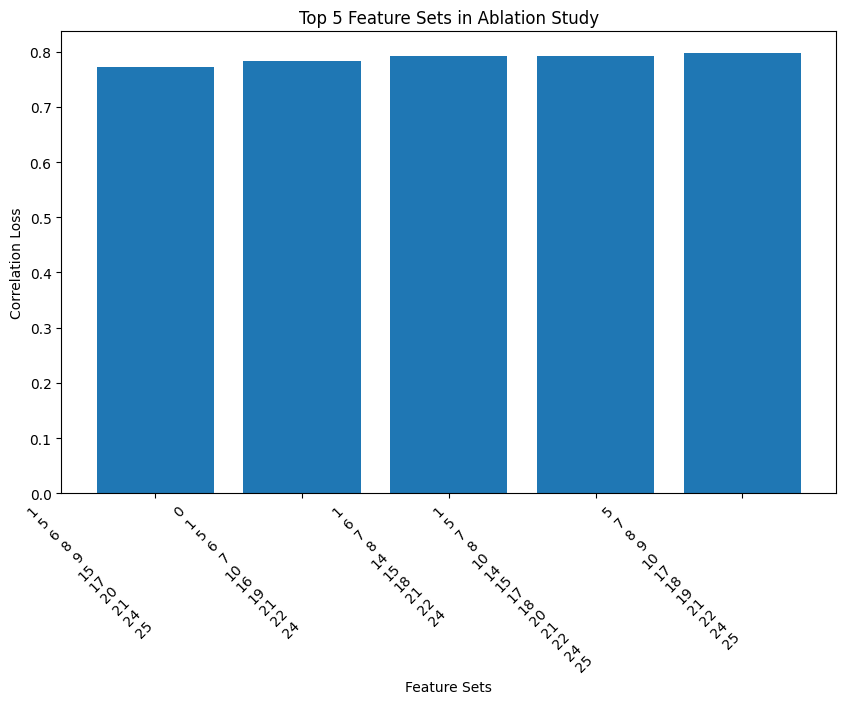

Epochs: 100%|█████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


Best Feature Set (Correlation Loss): 0.7624097168445587, Scalar Indices: (1, 5, 7, 8, 10, 14, 15, 17, 18, 20, 21, 22, 24, 25)


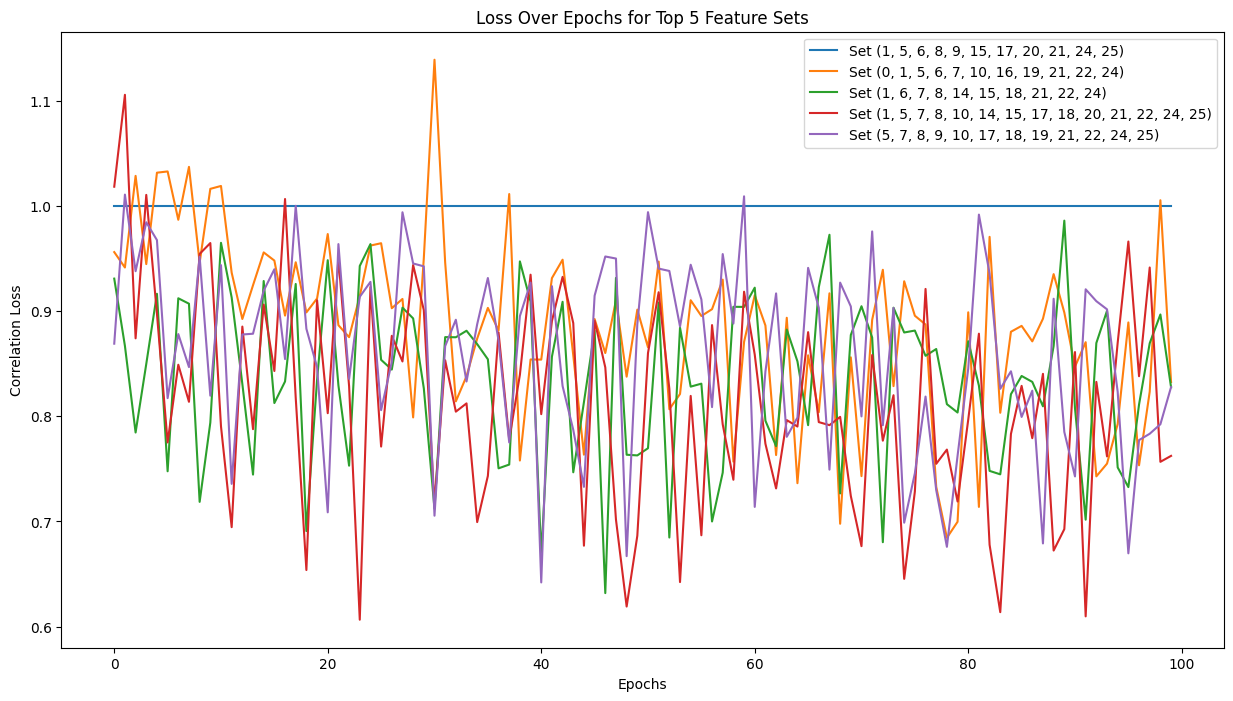

# Forward Selection Ablation

Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.0529


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0717


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0571


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0485


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0380


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0371


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0474


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0383


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0760


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0495


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0535


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.24s/it]

Epoch 12, Loss: 0.0956


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0578


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0763


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0943


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0466


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0504


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.0558


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.1219


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.2341


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0738


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0463


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.1435


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0508


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0910


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.1108


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.17s/it]

Epoch 9, Loss: 0.0524


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0484


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0463


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0790


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0731


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0445


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.17s/it]

Epoch 18, Loss: 0.0500


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 19, Loss: 0.0443


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 0.0805


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0508


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0807


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0692


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0527


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0512


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0383


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0471


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.0474


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.18s/it]

Epoch 11, Loss: 0.0393


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.18s/it]

Epoch 12, Loss: 0.0527


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.17s/it]

Epoch 13, Loss: 0.0489


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0568


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.28s/it]

Epoch 15, Loss: 0.0704


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.33s/it]

Epoch 16, Loss: 0.0529


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.32s/it]

Epoch 17, Loss: 0.0540


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.36s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.1436


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.16s/it]

Epoch 0, Loss: 0.0548


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.4582


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0719


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0529


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0664


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.1053


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.25s/it]

Epoch 7, Loss: 0.0508


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0902


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0956


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0717


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0466


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0578


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0588


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0410


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0535


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0365


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0504


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:19,  1.17s/it]

Epoch 2, Loss: 0.0454


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.17s/it]

Epoch 3, Loss: 0.0664


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0435


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0383


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0371


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.17s/it]

Epoch 7, Loss: 0.0421


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:12,  1.18s/it]

Epoch 8, Loss: 0.0393


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0560


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.1265


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0764


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0790


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.18s/it]

Epoch 13, Loss: 0.0559


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0578


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:18<00:04,  1.19s/it]

Epoch 15, Loss: 0.0669


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.17s/it]

Epoch 16, Loss: 0.0498


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.16s/it]

Epoch 17, Loss: 0.0570


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.16s/it]

Epoch 18, Loss: 0.0570


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 19, Loss: 0.0503


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.35s/it]

Epoch 0, Loss: 1.1216


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0458


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0512


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0371


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.19s/it]

Epoch 4, Loss: 0.1436


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0504


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0428


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.0484


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0619


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0537


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.18s/it]

Epoch 13, Loss: 0.0611


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0660


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.30s/it]

Epoch 15, Loss: 0.0380


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.33s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.30s/it]

Epoch 17, Loss: 0.0454


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.30s/it]

Epoch 18, Loss: 0.0443


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0540


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.17s/it]

Epoch 0, Loss: 8.0436


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.1646


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0512


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0807


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0525


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0396


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0463


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0738


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0622


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0512


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0396


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.23s/it]

Epoch 13, Loss: 0.0570


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0566


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0512


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0445


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0458


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0764


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.0851


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0525


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0573


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0463


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.19s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0790


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.18s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:12,  1.18s/it]

Epoch 8, Loss: 0.0543


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.18s/it]

Epoch 9, Loss: 0.0446


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.18s/it]

Epoch 10, Loss: 0.0928


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0535


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.18s/it]

Epoch 12, Loss: 0.1108


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0396


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0524


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0594


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.23s/it]

Epoch 18, Loss: 0.0766


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0704


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 10.1527


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.1585


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0714


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:20,  1.25s/it]

Epoch 3, Loss: 0.0766


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0492


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0571


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.21s/it]

Epoch 8, Loss: 0.0664


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0379


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.31s/it]

Epoch 10, Loss: 0.0410


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:11,  1.39s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.42s/it]

Epoch 12, Loss: 0.0690


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:08,  1.37s/it]

Epoch 13, Loss: 0.0433


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.32s/it]

Epoch 14, Loss: 0.0588


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0540


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0611


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0383


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0516


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0760


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0669


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0731


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.30s/it]

Epoch 5, Loss: 0.0466


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0503


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.25s/it]

Epoch 7, Loss: 0.0679


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0470


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0582


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0704


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.21s/it]

Epoch 12, Loss: 0.0393


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0505


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0356


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0714


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0669


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.20s/it]

Epoch 17, Loss: 0.0407


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0696


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0665


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.1265


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0537


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.18s/it]

Epoch 2, Loss: 0.0412


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0524


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0679


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0669


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0498


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0379


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0465


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0501


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0384


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0631


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0380


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0471


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.18s/it]

Epoch 16, Loss: 0.0410


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.1108


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0764


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0763


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0413


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.4975


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0660


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.1053


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.20s/it]

Epoch 4, Loss: 0.0503


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0410


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0466


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.24s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0783


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0656


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0738


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0902


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0484


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0535


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0664


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0910


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0690


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0605


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.0575


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0484


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.18s/it]

Epoch 2, Loss: 0.0504


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0619


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.17s/it]

Epoch 4, Loss: 0.0527


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0410


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.18s/it]

Epoch 7, Loss: 0.0443


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:12,  1.18s/it]

Epoch 8, Loss: 0.0463


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0578


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.18s/it]

Epoch 11, Loss: 0.0463


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.18s/it]

Epoch 12, Loss: 0.0749


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0521


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0484


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:18<00:04,  1.19s/it]

Epoch 15, Loss: 0.0477


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.18s/it]

Epoch 16, Loss: 0.0664


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.23s/it]

Epoch 17, Loss: 0.0484


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0421


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 19, Loss: 0.0570


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.0573


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0470


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0484


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.0664


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0485


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0571


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0548


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0766


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.33s/it]

Epoch 11, Loss: 0.0482


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.37s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:08,  1.44s/it]

Epoch 13, Loss: 0.0696


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:07,  1.48s/it]

Epoch 14, Loss: 0.0731


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.48s/it]

Epoch 15, Loss: 0.0412


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:04,  1.44s/it]

Epoch 16, Loss: 0.0484


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.44s/it]

Epoch 17, Loss: 0.0571


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.38s/it]

Epoch 18, Loss: 0.0570


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0500


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.38s/it]

Epoch 0, Loss: 0.0374


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.38s/it]

Epoch 1, Loss: 0.0482


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.44s/it]

Epoch 2, Loss: 0.0956


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.39s/it]

Epoch 3, Loss: 0.0443


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.39s/it]

Epoch 4, Loss: 0.0371


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.43s/it]

Epoch 5, Loss: 0.0731


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.44s/it]

Epoch 6, Loss: 0.0470


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:17,  1.46s/it]

Epoch 7, Loss: 0.0754


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:16,  1.47s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:15,  1.55s/it]

Epoch 9, Loss: 0.0477


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:16<00:14,  1.56s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:17<00:11,  1.47s/it]

Epoch 11, Loss: 0.0433


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.42s/it]

Epoch 12, Loss: 0.0428


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:20<00:08,  1.37s/it]

Epoch 13, Loss: 0.0611


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:21<00:06,  1.33s/it]

Epoch 14, Loss: 0.0412


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.29s/it]

Epoch 15, Loss: 0.0588


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.27s/it]

Epoch 16, Loss: 0.0679


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:25<00:02,  1.29s/it]

Epoch 17, Loss: 0.0508


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:26<00:01,  1.27s/it]

Epoch 18, Loss: 0.0631


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]


Epoch 19, Loss: 0.0611


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.26s/it]

Epoch 0, Loss: 22.0081


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 2.8074


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.1794


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0529


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.40s/it]

Epoch 4, Loss: 0.0559


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.42s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:20,  1.55s/it]

Epoch 6, Loss: 0.0578


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:19,  1.60s/it]

Epoch 7, Loss: 0.0421


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:16,  1.51s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:14,  1.44s/it]

Epoch 9, Loss: 0.0605


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:12,  1.40s/it]

Epoch 10, Loss: 0.0571


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:17<00:11,  1.43s/it]

Epoch 11, Loss: 0.0588


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:10,  1.43s/it]

Epoch 12, Loss: 0.0443


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.39s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.33s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.31s/it]

Epoch 15, Loss: 0.0573


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.28s/it]

Epoch 16, Loss: 0.0807


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.27s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:26<00:01,  1.29s/it]

Epoch 18, Loss: 0.1436


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch 19, Loss: 0.0573


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 3.3186


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0421


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0428


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0466


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0704


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.1053


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.24s/it]

Epoch 7, Loss: 0.0492


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0516


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0446


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0664


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0656


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0499


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0885


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0470


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0474


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.1053


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0499


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 480.7204


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 211.5302


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.32s/it]

Epoch 2, Loss: 70.8040


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 9.7779


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0495


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0619


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0504


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0524


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0943


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0443


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0380


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0665


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0512


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0619


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0380


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0943


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 1.3823


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.1176


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0543


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0665


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0524


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0384


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0407


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0783


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0499


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0694


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.25s/it]

Epoch 11, Loss: 0.0466


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0445


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0717


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0443


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0447


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0763


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0717


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0692


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.4802


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.31s/it]

Epoch 1, Loss: 0.0397


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0489


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.35s/it]

Epoch 3, Loss: 0.0540


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.1053


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0664


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0790


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.1053


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0548


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0512


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0660


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0570


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0506


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0694


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0660


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0749
Added feature 8. Performance: 0.047494562715291976


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.26s/it]

Epoch 0, Loss: 1.8061


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0383


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0566


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0393


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0477


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0410


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0525


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0943


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0412


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0421


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0500


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0694


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0754


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.26s/it]

Epoch 18, Loss: 0.0479


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0656


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.0512


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0749


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0902


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0474


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0384


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0412


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.28s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0692


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.1265


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.25s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0499


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0783


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0393


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0692


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0425


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0396


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0498


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0605


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0566


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0462


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0543


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0527


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0764


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0631


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.22s/it]

Epoch 8, Loss: 0.0619


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0501


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0524


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0902


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0380


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0543


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0588


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0447


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0548


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.27s/it]

Epoch 18, Loss: 0.0605


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0679


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0660


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0559


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0477


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0443


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0447


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0760


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0731


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0537


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0506


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0356


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0527


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.28s/it]

Epoch 15, Loss: 0.0790


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0548


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0582


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.37s/it]

Epoch 0, Loss: 0.6240


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 0.0550


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0713


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0471


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.25s/it]

Epoch 7, Loss: 0.0527


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0458


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0474


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.0943


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0807


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0529


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0760


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0763


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0790


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0379


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0529


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.7632


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0418


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0619


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0484


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0540


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0463


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0383


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0766


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0465


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.27s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.28s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.27s/it]

Epoch 14, Loss: 0.0380


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.26s/it]

Epoch 15, Loss: 0.0421


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0454


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0571


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.0602


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0444


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0694


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0717


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0588


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.1108


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0543


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0764


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0471


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0412


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0754


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0738


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0696


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0407


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0568


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0356


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0371


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.41s/it]

Epoch 0, Loss: 5.9484


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.31s/it]

Epoch 1, Loss: 0.0778


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0692


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0790


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0466


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0714


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0447


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.1053


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0714


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0885


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.25s/it]

Epoch 11, Loss: 0.0763


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0495


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0717


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0582


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0447


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 1.7026


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0907


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0379


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0749


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0663


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0371


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0660


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0484


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0505


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0383


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0421


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0588


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.30s/it]

Epoch 15, Loss: 0.0421


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.29s/it]

Epoch 16, Loss: 0.0660


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0470


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0407


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0485


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0704


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0498


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0474


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0704


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0512


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0463


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0717


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0508


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0694


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0466


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0664


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0783


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0714


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.1108


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0535


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0470


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0443


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0524


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.1265


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0503


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.25s/it]

Epoch 7, Loss: 0.0928


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0443


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0465


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0594


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0527


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0379


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0470


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0356


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 1.7295


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0766


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0471


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0807


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.1108


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0956


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0495


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0470


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0479


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0421


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0571


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0384


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.28s/it]

Epoch 18, Loss: 0.0910


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0535


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.0641


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0435


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0559


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.25s/it]

Epoch 3, Loss: 0.1436


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0694


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0393


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0527


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.24s/it]

Epoch 7, Loss: 0.0669


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0482


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0470


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0578


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0505


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0910


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0527


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0458


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 12.4434


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 0.3442


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0394


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0374


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0466


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0570


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.1265


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0463


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.27s/it]

Epoch 8, Loss: 0.0690


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0448


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.1435


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.34s/it]

Epoch 11, Loss: 0.0446


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.32s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.29s/it]

Epoch 13, Loss: 0.0498


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0714


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0505


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0540


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 33.6003


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 3.7214


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.1322


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.34s/it]

Epoch 3, Loss: 0.0498


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0445


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0783


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0631


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0956


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0540


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0428


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.25s/it]

Epoch 11, Loss: 0.0664


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0692


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0679


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0714


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0588


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0356


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0582


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 63.8202


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 18.1550


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 2.6260


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.1408


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0479


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.30s/it]

Epoch 5, Loss: 0.0619


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0484


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0535


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0412


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0537


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0641


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0384


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0508


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.25s/it]

Epoch 15, Loss: 0.0505


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0425


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0384


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0463


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0506


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.58s/it]

Epoch 0, Loss: 1281.9454


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:28,  1.57s/it]

Epoch 1, Loss: 440.1341


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.46s/it]

Epoch 2, Loss: 138.6815


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.41s/it]

Epoch 3, Loss: 35.7644


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 1.2221


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.33s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.31s/it]

Epoch 6, Loss: 0.0790


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0477


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.28s/it]

Epoch 8, Loss: 0.0454


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0548


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0477


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.31s/it]

Epoch 11, Loss: 0.0371


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.31s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0631


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0578


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.28s/it]

Epoch 15, Loss: 0.0379


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0928


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0516


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0498


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0669


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.4382


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0588


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0470


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0717


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0568


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0690


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0447


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.26s/it]

Epoch 7, Loss: 0.0559


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0396


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.1265


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.1436


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.26s/it]

Epoch 11, Loss: 0.0665


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0498


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0407


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0371


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0474


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0548


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.29s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0594


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0946


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.22s/it]

Epoch 1, Loss: 0.0587


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0587


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0485


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0458


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:17,  1.31s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.30s/it]

Epoch 7, Loss: 0.0447


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0559


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.32s/it]

Epoch 10, Loss: 0.0764


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.30s/it]

Epoch 11, Loss: 0.0435


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0582


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0696


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0694


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.25s/it]

Epoch 15, Loss: 0.0631


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0505


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0570


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0463
Added feature 17. Performance: 0.04286549501121044


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.3738


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0731


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0543


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0462


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0356


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0508


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0421


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0766


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0943


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0540


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0477


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.25s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0594


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.27s/it]

Epoch 18, Loss: 0.1436


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0573


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.3671


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0605


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0371


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0504


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0371


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0443


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0763


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0396


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0694


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0501


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0516


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0807


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0499


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0956


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0571


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0489


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0465


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0512


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0679


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0512


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.33s/it]

Epoch 2, Loss: 0.0956


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.0548


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0665


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0463


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0805


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0512


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0435


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0694


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0482


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0489


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0588


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0479


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0690


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0466


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0679


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0783


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0540


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 0.0812


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0495


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0505


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0466


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0529


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0445


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.32s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0731


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0506


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0560


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0445


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0578


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0492


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0489


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0454


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0885


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.1265


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0766


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.1313


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 0.0764


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 0.0594


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0540


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0568


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0499


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.31s/it]

Epoch 6, Loss: 0.0484


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0641


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.38s/it]

Epoch 8, Loss: 0.0754


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.35s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.34s/it]

Epoch 10, Loss: 0.0665


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0379


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0605


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0560


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.29s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0535


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.29s/it]

Epoch 18, Loss: 0.0619


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0503


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.0529


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0766


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0383


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0501


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0588


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0521


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0783


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0704


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0656


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0760


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0462


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0760


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.31s/it]

Epoch 13, Loss: 0.0714


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.30s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.30s/it]

Epoch 15, Loss: 0.0474


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.29s/it]

Epoch 16, Loss: 0.0500


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.29s/it]

Epoch 17, Loss: 0.0463


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.29s/it]

Epoch 18, Loss: 0.0754


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0568


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0700


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0748


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0437


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.25s/it]

Epoch 3, Loss: 0.0558


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0461


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0560


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0484


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0379


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.1053


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0525


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0540


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0928


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0902


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0521


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.30s/it]

Epoch 17, Loss: 0.0529


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.33s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0805


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.31s/it]

Epoch 0, Loss: 0.0736


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0458


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0717


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0570


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0412


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0396


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0582


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0714


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0498


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0537


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0505


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0521


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.25s/it]

Epoch 15, Loss: 0.0407


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0529


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0506


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0407


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0559


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.29s/it]

Epoch 0, Loss: 0.0511


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.37s/it]

Epoch 1, Loss: 0.0425


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.33s/it]

Epoch 2, Loss: 0.0425


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.31s/it]

Epoch 3, Loss: 0.0477


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.1108


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0548


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0463


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0445


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.41s/it]

Epoch 8, Loss: 0.0463


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.36s/it]

Epoch 9, Loss: 0.0956


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.34s/it]

Epoch 10, Loss: 0.0568


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0516


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0582


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.38s/it]

Epoch 15, Loss: 0.0503


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:04,  1.35s/it]

Epoch 16, Loss: 0.0704


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.32s/it]

Epoch 17, Loss: 0.0383


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.30s/it]

Epoch 18, Loss: 0.0465


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0356


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0570


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.1053


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0462


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0679


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.27s/it]

Epoch 4, Loss: 0.0500


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0956


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0622


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0524


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0717


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0498


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0790


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0485


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0521


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0407


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0410


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.47s/it]

Epoch 0, Loss: 0.0780


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.35s/it]

Epoch 1, Loss: 0.0807


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.29s/it]

Epoch 2, Loss: 0.0393


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0498


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0512


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0479


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0807


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0535


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0669


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.1108


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0356


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.25s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0766


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0928


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0525


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 0.2755


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0435


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0693


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0484


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.34s/it]

Epoch 4, Loss: 0.0577


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0696


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0524


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0492


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0537


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0407


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0783


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0443


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.25s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0568


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0485


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0485


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0396


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 0.0927


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0499


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0444


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0696


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0462


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.32s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.44s/it]

Epoch 6, Loss: 0.1436


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:17,  1.44s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.43s/it]

Epoch 8, Loss: 0.0783


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.39s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.38s/it]

Epoch 10, Loss: 0.0393


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.35s/it]

Epoch 11, Loss: 0.0766


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.37s/it]

Epoch 12, Loss: 0.0559


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:08,  1.33s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.28s/it]

Epoch 14, Loss: 0.0501


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0943


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0669


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0560


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.25s/it]

Epoch 18, Loss: 0.0410


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0764


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 0.0492


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0477


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0731


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0356


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.20s/it]

Epoch 4, Loss: 0.0910


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0535


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0356


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0578


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.26s/it]

Epoch 11, Loss: 0.0407


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0760


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.1436


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0928


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0805


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0380


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.18s/it]

Epoch 17, Loss: 0.0582


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0665


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0619


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 125.5216


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 30.6876


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 5.5308


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:20,  1.26s/it]

Epoch 3, Loss: 0.6009


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0887


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0422


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0543


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0447


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0665


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0512


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.18s/it]

Epoch 10, Loss: 0.0470


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.18s/it]

Epoch 11, Loss: 0.0501


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.17s/it]

Epoch 12, Loss: 0.0501


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:06,  1.17s/it]

Epoch 13, Loss: 0.0504


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.18s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.17s/it]

Epoch 15, Loss: 0.0588


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.17s/it]

Epoch 16, Loss: 0.0525


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.16s/it]

Epoch 17, Loss: 0.0516


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.17s/it]

Epoch 18, Loss: 0.0956


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 19, Loss: 0.0499


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0665


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 2.4126


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0445


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0763


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0943


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0807


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0465


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0694


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0660


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0588


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0521


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0764


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0664


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0380


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0641


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0471


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0763


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 0.7381


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.17s/it]

Epoch 1, Loss: 0.0943


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:19,  1.16s/it]

Epoch 2, Loss: 0.0902


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0956


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0910


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0910


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:12,  1.20s/it]

Epoch 9, Loss: 0.0470


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.1436


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0379


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0660


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:06,  1.20s/it]

Epoch 14, Loss: 0.0764


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0492


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0660


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0704


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.25s/it]

Epoch 18, Loss: 0.0446


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0790


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.2007


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0598


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0548


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0435


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.20s/it]

Epoch 4, Loss: 0.0527


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0471


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0568


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.18s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.18s/it]

Epoch 8, Loss: 0.0559


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.18s/it]

Epoch 9, Loss: 0.0435


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.18s/it]

Epoch 10, Loss: 0.0696


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.17s/it]

Epoch 11, Loss: 0.0548


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.17s/it]

Epoch 12, Loss: 0.0505


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.18s/it]

Epoch 13, Loss: 0.0447


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.18s/it]

Epoch 14, Loss: 0.0503


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:18<00:04,  1.18s/it]

Epoch 15, Loss: 0.0641


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.18s/it]

Epoch 16, Loss: 0.0622


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.18s/it]

Epoch 17, Loss: 0.0704


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.18s/it]

Epoch 18, Loss: 0.0588


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 19, Loss: 0.0458
Added feature 16. Performance: 0.04600208979099989


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 0.7572


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0506


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.18s/it]

Epoch 2, Loss: 0.0738


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0619


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0506


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0690


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0910


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0805


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:12,  1.21s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0412


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.28s/it]

Epoch 11, Loss: 0.0474


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.25s/it]

Epoch 12, Loss: 0.0641


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0664


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0410


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0471


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0943


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0665


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 5.3238


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0535


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0406


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0540


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0660


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.1108


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0474


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.18s/it]

Epoch 9, Loss: 0.0516


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0568


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0679


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.18s/it]

Epoch 13, Loss: 0.0498


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.19s/it]

Epoch 14, Loss: 0.0407


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0764


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0462


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.1265


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0436


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0664


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0410


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0498


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0665


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0807


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0754


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0470


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0910


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0582


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0445


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0525


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.18s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.17s/it]

Epoch 15, Loss: 0.0380


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.17s/it]

Epoch 16, Loss: 0.0484


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0379


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0498


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0504


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 0.0393


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0525


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0503


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0560


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0498


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0371


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.1265


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0559


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0763


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0498


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0479


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0466


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0679


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0578


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0766


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0805


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.22s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0571


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 0.0570


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0521


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0466


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0543


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0543


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0631


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0594


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0749


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0783


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0717


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0383


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0582


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0694


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.1053


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0527


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0489


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0458


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0578


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0458


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 1.6607


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0511


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0656


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.1435


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0731


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0587


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0621


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0500


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.21s/it]

Epoch 8, Loss: 0.0516


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0641


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0447


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.27s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0714


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0410


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0407


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0458


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0537


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0447


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0535


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.0384


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0749


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0656


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:20,  1.26s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0665


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.1265


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0582


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0696


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0943


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.1436


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.18s/it]

Epoch 10, Loss: 0.0383


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0622


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0529


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.1436


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.19s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0474


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0410


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0540


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0588


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0458


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.3402


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0692


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0717


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0495


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0588


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0669


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0665


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.20s/it]

Epoch 9, Loss: 0.0393


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0484


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0783


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0500


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0463


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0641


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0738


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0540


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0433


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.17s/it]

Epoch 0, Loss: 0.0573


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.17s/it]

Epoch 1, Loss: 0.0525


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0477


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.0380


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0566


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0910


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0506


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0694


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:12,  1.20s/it]

Epoch 9, Loss: 0.0462


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0479


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.18s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0738


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:17<00:05,  1.19s/it]

Epoch 14, Loss: 0.0543


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0445


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0466


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0731


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0383


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0462


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0506


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0573


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0495


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0470


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0525


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0489


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0731


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0582


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.0760


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0690


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0783


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.19s/it]

Epoch 14, Loss: 0.0407


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0484


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0543


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0704


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.0764


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0568


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0524


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0619


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0714


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0383


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0566


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0588


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0692


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0543


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.24s/it]

Epoch 12, Loss: 0.0783


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.25s/it]

Epoch 13, Loss: 0.0540


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0500


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0928


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.18s/it]

Epoch 16, Loss: 0.0454


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0690


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0690


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.3305


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0462


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0548


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0660


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0571


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0902


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.19s/it]

Epoch 9, Loss: 0.0548


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0665


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0412


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0690


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0505


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0669


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0477


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0679


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0428


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 6.3107


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0581


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0568


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0660


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0454


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0505


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0470


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0694


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0512


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0571


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0516


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0731


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0479


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0435


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0482


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.17s/it]

Epoch 0, Loss: 0.0529


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0464


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0738


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0396


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.19s/it]

Epoch 4, Loss: 0.0525


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0766


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0506


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0433


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.24s/it]

Epoch 8, Loss: 0.0535


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0495


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0665


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0445


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0573


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0760


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0477


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0641


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0471


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0631


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0928


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0611


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 30.3119


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0692


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0731


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0928


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0485


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0443


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0525


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0641


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0540


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0679


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0571


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0463


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0660


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.1265


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0783


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0660


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0484


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0714


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.0535


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.17s/it]

Epoch 1, Loss: 0.0606


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0907


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0473


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0407


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0764


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0764


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0421


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.29s/it]

Epoch 9, Loss: 0.0356


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.28s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.25s/it]

Epoch 11, Loss: 0.0805


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.24s/it]

Epoch 12, Loss: 0.0445


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0690


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0540


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0421


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0578


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0474


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0704


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 0.0559


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0407


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.0371


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0543


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0885


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0425


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.1436


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0485


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.18s/it]

Epoch 9, Loss: 0.0371


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0622


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0783


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0559


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0665


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0764


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0492


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0446


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0717


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0471


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0462
Added feature 5. Performance: 0.04488899149000645


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 3.1931


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0480


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0508


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0383


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0383


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0885


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0495


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.23s/it]

Epoch 8, Loss: 0.0656


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.22s/it]

Epoch 10, Loss: 0.0605


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0669


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0679


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0465


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0504


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0506


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0560


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0495


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0529


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.1053


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0766


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0463


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:18,  1.20s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0559


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0454


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0479


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0470


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0529


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0641


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.22s/it]

Epoch 13, Loss: 0.0641


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0560


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0622


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0696


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.23s/it]

Epoch 17, Loss: 0.0484


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0566


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0499


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 0.7863


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0383


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0466


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0594


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0754


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0790


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.1053


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0807


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0790


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0764


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0573


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0498


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0470


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.19s/it]

Epoch 14, Loss: 0.0484


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.18s/it]

Epoch 15, Loss: 0.0631


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.17s/it]

Epoch 16, Loss: 0.0521


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.18s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch 19, Loss: 0.0790


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.6688


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0329


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:19,  1.17s/it]

Epoch 2, Loss: 0.0582


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0622


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0704


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.19s/it]

Epoch 5, Loss: 0.0537


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0504


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0696


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0371


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0501


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0704


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0410


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0498


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.27s/it]

Epoch 15, Loss: 0.0371


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.25s/it]

Epoch 16, Loss: 0.0537


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.27s/it]

Epoch 18, Loss: 0.0435


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0763


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.0664


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0948


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0922


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0435


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0928


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0492


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0704


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.19s/it]

Epoch 8, Loss: 0.0512


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.20s/it]

Epoch 9, Loss: 0.0407


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0537


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0512


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0577


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0716


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0428


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0559


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0521


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0577


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.18s/it]

Epoch 18, Loss: 0.0588


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0384


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.4040


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0522


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0956


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.1265


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0482


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0383


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0379


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0578


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0535


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0443


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0482


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0582


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0393


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0471


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0665


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.0512


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0566


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0704


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0463


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0380


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0611


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.19s/it]

Epoch 6, Loss: 0.0499


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0447


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0760


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0622


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0471


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0566


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.23s/it]

Epoch 13, Loss: 0.0605


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0631


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0498


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0754


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0571


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 3.5729


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0724


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0445


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0384


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.1436


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0566


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0692


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0641


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0492


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0641


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0582


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0485


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0527


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0484


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0447


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0484


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 4.9526


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.1863


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0699


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0760


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0731


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0505


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0516


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0504


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0535


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0669


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0669


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0573


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.26s/it]

Epoch 15, Loss: 0.0665


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:04,  1.35s/it]

Epoch 16, Loss: 0.0717


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.34s/it]

Epoch 17, Loss: 0.0524


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.32s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0902


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 3.1791


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0515


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0471


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.1265


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0749


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0529


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0500


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0505


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:11,  1.20s/it]

Epoch 9, Loss: 0.0384


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0471


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0529


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0611


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0790


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0527


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.1053


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0521


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0764


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.7278


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0474


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.0535


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0570


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0447


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0805


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.21s/it]

Epoch 8, Loss: 0.0566


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0619


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0717


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0393


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.19s/it]

Epoch 12, Loss: 0.0412


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.19s/it]

Epoch 13, Loss: 0.0465


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0622


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0504


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.19s/it]

Epoch 16, Loss: 0.0465


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.18s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.18s/it]

Epoch 18, Loss: 0.0407


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0356


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0570


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0508


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0885


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0435


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0503


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0537


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0525


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0717


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0559


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0738


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.25s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0910


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0407


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0611


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0525


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.21s/it]

Epoch 0, Loss: 0.0679


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0679


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0568


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0506


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.20s/it]

Epoch 4, Loss: 0.0383


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.18s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0421


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.18s/it]

Epoch 7, Loss: 0.0454


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0505


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.20s/it]

Epoch 9, Loss: 0.0465


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0665


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.22s/it]

Epoch 13, Loss: 0.0910


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0885


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0525


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0619


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.25s/it]

Epoch 17, Loss: 0.1053


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.23s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0694


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 17.4209


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.22s/it]

Epoch 1, Loss: 0.0571


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0484


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0508


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0910


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0902


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0524


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.35s/it]

Epoch 8, Loss: 0.0484


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:13,  1.31s/it]

Epoch 9, Loss: 0.0669


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0492


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0902


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0766


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0566


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.20s/it]

Epoch 16, Loss: 0.0527


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.20s/it]

Epoch 17, Loss: 0.0543


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0479


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0560


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0656


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0540


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0435


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0807


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.20s/it]

Epoch 4, Loss: 0.0568


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0714


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0805


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0566


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0611


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0885


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0548


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0766


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0500


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0622


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0619


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0383


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0466


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0559


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 4.5458


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0457


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0543


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0356


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.19s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0570


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0463


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0465


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:11<00:11,  1.19s/it]

Epoch 9, Loss: 0.0498


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.19s/it]

Epoch 10, Loss: 0.0501


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.19s/it]

Epoch 11, Loss: 0.0447


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0582


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0501


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.1108


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0477


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0664


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 19, Loss: 0.0474
Added feature 20. Performance: 0.04539679419249296


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.0481


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0485


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0943


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0537


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:17,  1.19s/it]

Epoch 4, Loss: 0.0790


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0559


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0535


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0506


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0508


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0571


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0485


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0885


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0466


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0749


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0570


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.19s/it]

Epoch 15, Loss: 0.0717


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0763


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0807


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.19s/it]

Epoch 18, Loss: 0.0489


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0484


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.21s/it]

Epoch 0, Loss: 1.1216


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0731


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0696


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.19s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.18s/it]

Epoch 4, Loss: 0.0540


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0535


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0396


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0622


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0885


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.25s/it]

Epoch 11, Loss: 0.0928


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.23s/it]

Epoch 12, Loss: 0.0763


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.22s/it]

Epoch 13, Loss: 0.0611


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0503


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0694


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0529


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0631


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0485


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0692


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.18s/it]

Epoch 0, Loss: 0.5102


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.18s/it]

Epoch 1, Loss: 0.0454


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.18s/it]

Epoch 2, Loss: 0.0425


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.18s/it]

Epoch 3, Loss: 0.0443


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:18,  1.21s/it]

Epoch 4, Loss: 0.0669


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0622


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.20s/it]

Epoch 6, Loss: 0.0527


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.29s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0690


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0383


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0540


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0446


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.25s/it]

Epoch 12, Loss: 0.0433


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0540


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.31s/it]

Epoch 14, Loss: 0.0501


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.28s/it]

Epoch 15, Loss: 0.0559


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0588


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0356


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0512


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 5.5782


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0409


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.1053


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0783


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0535


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0500


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0425


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0466


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0407


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.22s/it]

Epoch 10, Loss: 0.0956


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0500


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0902


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0902


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:05,  1.20s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0582


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0738


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0379


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0754


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0466


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.36s/it]

Epoch 0, Loss: 0.7215


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0578


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0465


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0619


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0495


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0665


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0454


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0501


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0462


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0559


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0578


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0503


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.1053


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0764


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.20s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0383


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0428


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.20s/it]

Epoch 17, Loss: 0.0508


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.20s/it]

Epoch 18, Loss: 0.0665


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0521


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0801


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0739


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0696


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.25s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0641


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0499


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.20s/it]

Epoch 7, Loss: 0.0484


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0412


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0605


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.22s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.20s/it]

Epoch 13, Loss: 0.0527


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0605


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0499


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0474


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0501


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0410


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0384


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0941


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0513


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0582


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0910


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0566


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.23s/it]

Epoch 8, Loss: 0.0512


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.30s/it]

Epoch 9, Loss: 0.0622


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.27s/it]

Epoch 11, Loss: 0.0656


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0885


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0582


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.28s/it]

Epoch 14, Loss: 0.0763


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0384


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0540


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0506


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0492


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0537


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0488


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:20,  1.16s/it]

Epoch 1, Loss: 0.4493


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0476


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:05<00:17,  1.20s/it]

Epoch 4, Loss: 0.0521


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.32s/it]

Epoch 5, Loss: 0.0356


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0529


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.25s/it]

Epoch 7, Loss: 0.0578


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0500


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0396


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0594


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0571


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0543


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.1265


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0458


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.21s/it]

Epoch 16, Loss: 0.0433


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0543


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0594


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0407


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.19s/it]

Epoch 0, Loss: 5.6445


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.19s/it]

Epoch 1, Loss: 0.0653


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.19s/it]

Epoch 2, Loss: 0.0559


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:18,  1.19s/it]

Epoch 3, Loss: 0.1436


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0521


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0582


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.21s/it]

Epoch 6, Loss: 0.0495


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0508


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0445


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0435


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0694


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.21s/it]

Epoch 13, Loss: 0.0412


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0717


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.25s/it]

Epoch 15, Loss: 0.0412


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0516


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.24s/it]

Epoch 17, Loss: 0.1265


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0570


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 8.6190


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.1822


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0760


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0525


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0566


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0529


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.1265


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0504


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0471


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0692


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0573


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0690


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.24s/it]

Epoch 12, Loss: 0.0489


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0605


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0766


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0447


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0503


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0521


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.20s/it]

Epoch 18, Loss: 0.0393


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 1.8962


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0484


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0356


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.20s/it]

Epoch 3, Loss: 0.0885


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0760


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.20s/it]

Epoch 5, Loss: 0.0754


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.18s/it]

Epoch 6, Loss: 0.0407


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.19s/it]

Epoch 7, Loss: 0.0484


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0463


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0573


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0384


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.20s/it]

Epoch 11, Loss: 0.0498


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.20s/it]

Epoch 12, Loss: 0.0665


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0928


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0664


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0525


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0622


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:22<00:01,  1.21s/it]

Epoch 18, Loss: 0.0527


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0428


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 45.3028


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 8.6942


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.7973


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0597


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0694


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0660


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0484


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0380


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.1265


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0433


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0485


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0807


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0482


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0956


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0619


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0902


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17, Loss: 0.0690


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0479


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.46s/it]

Epoch 0, Loss: 420.0105


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.49s/it]

Epoch 1, Loss: 19.0903


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.34s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.47s/it]

Epoch 4, Loss: 0.0956


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.39s/it]

Epoch 5, Loss: 0.0611


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0379


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0928


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.28s/it]

Epoch 8, Loss: 0.0641


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.25s/it]

Epoch 9, Loss: 0.0506


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.24s/it]

Epoch 10, Loss: 0.0548


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.1265


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.22s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.22s/it]

Epoch 13, Loss: 0.0763


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.23s/it]

Epoch 14, Loss: 0.0956


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.23s/it]

Epoch 15, Loss: 0.0696


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0458


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.22s/it]

Epoch 17, Loss: 0.0458


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0503


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 1.6797


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0807


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.20s/it]

Epoch 2, Loss: 0.0463


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0535


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0578


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0482


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0764


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.22s/it]

Epoch 7, Loss: 0.0717


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.21s/it]

Epoch 8, Loss: 0.0910


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0910


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0594


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0356


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.1436


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0543


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0492


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0527


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.1108


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.22s/it]

Epoch 17, Loss: 0.0690


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0506


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.3532


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.20s/it]

Epoch 1, Loss: 0.0753


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0664


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0749


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0956


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0383


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.20s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.21s/it]

Epoch 9, Loss: 0.0783


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.20s/it]

Epoch 10, Loss: 0.0760


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0605


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.1265


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:16<00:07,  1.20s/it]

Epoch 13, Loss: 0.0527


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0902


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.23s/it]

Epoch 17, Loss: 0.0474


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0435


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0471
Added feature 10. Performance: 0.045363984256982806


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.0924


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0384


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.1436


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0622


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0631


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0479


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0738


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:10<00:13,  1.22s/it]

Epoch 8, Loss: 0.0956


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0582


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0410


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0570


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0447


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0805


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.20s/it]

Epoch 15, Loss: 0.0573


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0407


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.19s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0407


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.36s/it]

Epoch 0, Loss: 2.9959


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 0.0514


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0382


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.25s/it]

Epoch 3, Loss: 0.0660


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0412


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0587


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0433


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0910


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0425


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0474


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0428


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0499


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0571


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0570


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.0807


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0656


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0573


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 1.0252


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0486


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.38s/it]

Epoch 2, Loss: 0.0763


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.34s/it]

Epoch 3, Loss: 0.0471


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0588


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0379


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0525


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0679


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0384


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.21s/it]

Epoch 11, Loss: 0.0383


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0492


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0622


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0466


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0956


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.21s/it]

Epoch 16, Loss: 0.0717


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0425


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0692


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0910


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.22s/it]

Epoch 0, Loss: 0.7093


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0489


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0641


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0407


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0559


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:16,  1.21s/it]

Epoch 5, Loss: 0.0499


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0380


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0393


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0499


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0412


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0524


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.21s/it]

Epoch 12, Loss: 0.0495


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.1436


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.21s/it]

Epoch 14, Loss: 0.0560


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0433


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0738


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:21<00:02,  1.21s/it]

Epoch 17, Loss: 0.0393


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0495


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 19, Loss: 0.0508


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.2460


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.22s/it]

Epoch 1, Loss: 0.0483


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0660


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0714


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0582


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0393


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0512


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0380


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0578


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0465


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0524


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0548


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0588


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0956


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0622


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0664


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.9355


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0829


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0437


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0412


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0512


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0505


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0495


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0435


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.22s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0458


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0384


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0605


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0543


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0660


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0885


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0928


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0500


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.26s/it]

Epoch 18, Loss: 0.0499


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0665


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.3255


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.0664


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0482


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.24s/it]

Epoch 3, Loss: 0.0489


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0943


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0754


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0356


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0525


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0492


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.1108


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.21s/it]

Epoch 11, Loss: 0.0548


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0446


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.21s/it]

Epoch 13, Loss: 0.0379


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0664


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0524


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.22s/it]

Epoch 16, Loss: 0.0500


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17, Loss: 0.0548


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0714


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0679


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:32,  1.70s/it]

Epoch 0, Loss: 3.3943


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 0.0517


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.33s/it]

Epoch 2, Loss: 0.0763


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0679


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0512


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0445


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.25s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.23s/it]

Epoch 7, Loss: 0.0559


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.22s/it]

Epoch 8, Loss: 0.0462


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.20s/it]

Epoch 9, Loss: 0.0500


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.21s/it]

Epoch 10, Loss: 0.0466


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.20s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.21s/it]

Epoch 12, Loss: 0.0356


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.20s/it]

Epoch 13, Loss: 0.0559


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.20s/it]

Epoch 14, Loss: 0.0928


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.21s/it]

Epoch 15, Loss: 0.0679


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.22s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.21s/it]

Epoch 17, Loss: 0.1108


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.21s/it]

Epoch 18, Loss: 0.0578


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0447


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:22,  1.20s/it]

Epoch 0, Loss: 0.0565


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0807


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0471


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.21s/it]

Epoch 3, Loss: 0.0537


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0537


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0465


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.26s/it]

Epoch 7, Loss: 0.0669


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0446


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0516


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0568


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0428


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0714


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0384


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0570


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0560


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.21s/it]

Epoch 16, Loss: 0.0760


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0470


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.3367


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0754


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.22s/it]

Epoch 2, Loss: 0.0540


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0471


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0524


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0471


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.21s/it]

Epoch 7, Loss: 0.0383


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0371


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0928


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.28s/it]

Epoch 10, Loss: 0.0605


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:10,  1.25s/it]

Epoch 11, Loss: 0.0471


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0500


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0631


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0763


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0783


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.1265


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0356


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0679


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0543


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0356


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0690


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0474


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0479


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.1053


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0943


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0466


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.25s/it]

Epoch 7, Loss: 0.0754


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0428


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0692


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0484


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0504


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:15<00:08,  1.22s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0665


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0760


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0470


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0696


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17, Loss: 0.0521


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0928


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0433


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.0474


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0760


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0433


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0443


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0465


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0566


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0704


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:15,  1.25s/it]

Epoch 7, Loss: 0.0566


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.1053


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0521


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.22s/it]

Epoch 10, Loss: 0.0425


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0714


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0446


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0470


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0508


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.23s/it]

Epoch 16, Loss: 0.0505


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.34s/it]

Epoch 17, Loss: 0.0356


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.32s/it]

Epoch 18, Loss: 0.0470


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0512


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.2658


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0664


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0484


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0529


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.22s/it]

Epoch 4, Loss: 0.0568


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0783


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0665


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0356


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0425


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0754


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0471


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0410


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0383


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0484


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0521


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0943


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 1.7576


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 0.0470


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0760


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.24s/it]

Epoch 3, Loss: 0.0501


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0669


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0463


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0543


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0508


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0619


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.22s/it]

Epoch 11, Loss: 0.0383


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.22s/it]

Epoch 12, Loss: 0.0805


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0524


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0805


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.24s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0885


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0731


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0690
Added feature 23. Performance: 0.04702445678412914


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.45s/it]

Epoch 0, Loss: 593.6272


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.47s/it]

Epoch 1, Loss: 128.9192


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 1.9576


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0407


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0571


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0525


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0529


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0766


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0446


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0393


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0498


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0566


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0503


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0656


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.23s/it]

Epoch 14, Loss: 0.0527


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.23s/it]

Epoch 15, Loss: 0.0696


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0605


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0500


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0462


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.23s/it]

Epoch 0, Loss: 0.1512


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:21,  1.21s/it]

Epoch 1, Loss: 0.0371


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.21s/it]

Epoch 2, Loss: 0.0571


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.22s/it]

Epoch 3, Loss: 0.0559


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.21s/it]

Epoch 4, Loss: 0.0664


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0928


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.22s/it]

Epoch 6, Loss: 0.0656


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.1265


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:13,  1.35s/it]

Epoch 9, Loss: 0.0380


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.30s/it]

Epoch 10, Loss: 0.0393


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0383


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0383


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0764


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.1108


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0474


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0714


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0504


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.0433


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.39s/it]

Epoch 0, Loss: 885.0880


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch 1, Loss: 13.6585


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 0.0510


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.31s/it]

Epoch 3, Loss: 0.0447


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0506


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0512


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0578


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0956


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0443


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0783


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0384


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.32s/it]

Epoch 11, Loss: 0.0641


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:08,  1.37s/it]

Epoch 13, Loss: 0.0454


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.34s/it]

Epoch 14, Loss: 0.0508


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.35s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.33s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0504


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0410


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0731


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 99.4782


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 19.4855


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0650


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.25s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0943


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0568


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0543


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0383


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0566


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0471


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0885


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0764


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.25s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0505


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0605


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:34,  1.81s/it]

Epoch 0, Loss: 1359.8990


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:29,  1.63s/it]

Epoch 1, Loss: 438.8812


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.56s/it]

Epoch 2, Loss: 52.9877


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.42s/it]

Epoch 3, Loss: 0.0383


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 0.0548


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0694


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0412


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0462


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:13,  1.27s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.26s/it]

Epoch 9, Loss: 0.0505


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.25s/it]

Epoch 10, Loss: 0.0371


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.24s/it]

Epoch 11, Loss: 0.0570


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.24s/it]

Epoch 12, Loss: 0.0482


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.1108


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.24s/it]

Epoch 14, Loss: 0.0611


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0694


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.25s/it]

Epoch 16, Loss: 0.0570


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.24s/it]

Epoch 17, Loss: 0.0570


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.23s/it]

Epoch 18, Loss: 0.0484


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0524


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.39s/it]

Epoch 0, Loss: 304.9353


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.40s/it]

Epoch 1, Loss: 14.8936


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0506


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0463


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0910


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0529


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.25s/it]

Epoch 6, Loss: 0.0396


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.23s/it]

Epoch 7, Loss: 0.0605


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0407


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0433


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0754


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.0477


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0631


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0484


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0656


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.22s/it]

Epoch 15, Loss: 0.0928


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.22s/it]

Epoch 16, Loss: 0.0500


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0660


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0537


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.26s/it]

Epoch 0, Loss: 240.3485


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 63.4791


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 4.0619


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0910


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0660


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0383


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0568


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0660


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0738


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0570


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.24s/it]

Epoch 11, Loss: 0.0506


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0660


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0463


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.24s/it]

Epoch 14, Loss: 0.0462


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0379


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.23s/it]

Epoch 16, Loss: 0.0943


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0383


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0704


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 11.9466


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.35s/it]

Epoch 1, Loss: 0.0554


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.30s/it]

Epoch 2, Loss: 0.0619


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0560


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0560


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0482


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.25s/it]

Epoch 7, Loss: 0.0790


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0524


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.37s/it]

Epoch 9, Loss: 0.0714


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.34s/it]

Epoch 10, Loss: 0.0543


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.33s/it]

Epoch 11, Loss: 0.0425


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0571


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0412


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0471


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0482


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0474


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0498


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.48s/it]

Epoch 0, Loss: 234.8518


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.45s/it]

Epoch 1, Loss: 6.6883


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0482


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.0463


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0495


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0535


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0665


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0470


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.24s/it]

Epoch 10, Loss: 0.0573


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.24s/it]

Epoch 11, Loss: 0.0445


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0559


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.28s/it]

Epoch 13, Loss: 0.0738


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0525


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0384


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0605


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0462


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.1265


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0669


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0512


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0512


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.25s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0679


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.24s/it]

Epoch 5, Loss: 0.0805


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0704


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0790


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0384


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0421


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0508


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0749


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0582


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0379


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.22s/it]

Epoch 14, Loss: 0.0582


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.20s/it]

Epoch 16, Loss: 0.0664


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.22s/it]

Epoch 17, Loss: 0.0656


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0622


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0535


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 30.1441


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.1536


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0499


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0665


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0571


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.1108


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.24s/it]

Epoch 6, Loss: 0.0679


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0578


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0529


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.22s/it]

Epoch 9, Loss: 0.0471


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0582


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.24s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0656


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0594


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0410


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:05,  1.25s/it]

Epoch 15, Loss: 0.0717


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0543


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0482


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


Epoch 19, Loss: 0.0694


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0597


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.23s/it]

Epoch 1, Loss: 0.0443


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:20,  1.23s/it]

Epoch 2, Loss: 0.0410


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:20,  1.25s/it]

Epoch 3, Loss: 0.0910


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.0435


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.22s/it]

Epoch 5, Loss: 0.0471


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.23s/it]

Epoch 6, Loss: 0.0535


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.23s/it]

Epoch 7, Loss: 0.0619


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.23s/it]

Epoch 9, Loss: 0.0425


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0790


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:14<00:09,  1.23s/it]

Epoch 11, Loss: 0.0471


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0407


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.22s/it]

Epoch 13, Loss: 0.0505


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0763


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.22s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:20<00:03,  1.24s/it]

Epoch 16, Loss: 0.0503


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.23s/it]

Epoch 17, Loss: 0.0540


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.22s/it]

Epoch 18, Loss: 0.0504


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 19, Loss: 0.0482


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0766


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0695


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0738


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0412


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0466


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:19,  1.49s/it]

Epoch 6, Loss: 0.0471


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:18,  1.50s/it]

Epoch 7, Loss: 0.0714


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.44s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.38s/it]

Epoch 9, Loss: 0.0499


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.33s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.31s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.29s/it]

Epoch 12, Loss: 0.0482


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0482


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0508


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0508


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0717
Added feature 24. Performance: 0.049126413837075236


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 527.8275


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 244.4048


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 87.6148


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.31s/it]

Epoch 3, Loss: 15.4075


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0810


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0508


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0611


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0380


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0471


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0512


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0571


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0704


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0521


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0535


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0548


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0495


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0641


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.29s/it]

Epoch 0, Loss: 4.1170


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0746


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0704


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0383


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.23s/it]

Epoch 4, Loss: 0.0535


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.23s/it]

Epoch 5, Loss: 0.0446


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:15,  1.23s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:09<00:14,  1.24s/it]

Epoch 7, Loss: 0.0543


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0679


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0717


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0525


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.30s/it]

Epoch 11, Loss: 0.0428


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0943


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.23s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


Epoch 19, Loss: 0.0664


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:31,  1.64s/it]

Epoch 0, Loss: 47.7211


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.42s/it]

Epoch 1, Loss: 0.0619


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.34s/it]

Epoch 2, Loss: 0.0805


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0421


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0529


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0754


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0501


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.24s/it]

Epoch 7, Loss: 0.1436


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.23s/it]

Epoch 8, Loss: 0.0407


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.23s/it]

Epoch 10, Loss: 0.0631


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.24s/it]

Epoch 12, Loss: 0.0588


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0479


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.31s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0505


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0588


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0421


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0766


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0356


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.50s/it]

Epoch 0, Loss: 553.5926


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.53s/it]

Epoch 1, Loss: 77.1638


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.41s/it]

Epoch 2, Loss: 3.4914


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.35s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:17,  1.28s/it]

Epoch 5, Loss: 0.0529


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0371


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0731


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0664


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0928


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.24s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0738


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0447


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0489


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0783


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.48s/it]

Epoch 0, Loss: 0.1332


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.45s/it]

Epoch 1, Loss: 0.3922


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 0.0384


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.1108


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0664


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0447


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0443


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0694


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.1265


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.25s/it]

Epoch 10, Loss: 0.0521


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.24s/it]

Epoch 11, Loss: 0.0694


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0731


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0902


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0410


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0910


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.25s/it]

Epoch 17, Loss: 0.0516


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0664


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.34s/it]

Epoch 0, Loss: 335.7028


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.36s/it]

Epoch 1, Loss: 130.5802


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.33s/it]

Epoch 2, Loss: 32.4168


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.7320


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.36s/it]

Epoch 4, Loss: 0.0656


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.33s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0679


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.30s/it]

Epoch 7, Loss: 0.0492


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.26s/it]

Epoch 9, Loss: 0.0679


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0694


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0619


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0525


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0421


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.23s/it]

Epoch 14, Loss: 0.0664


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0410


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0516


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0495


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0454


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.50s/it]

Epoch 0, Loss: 1759.4603


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.53s/it]

Epoch 1, Loss: 394.7941


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.46s/it]

Epoch 2, Loss: 26.8018


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.46s/it]

Epoch 3, Loss: 0.0588


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.50s/it]

Epoch 4, Loss: 0.0943


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.46s/it]

Epoch 5, Loss: 0.0956


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:18,  1.40s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.35s/it]

Epoch 7, Loss: 0.0749


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0371


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0537


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.29s/it]

Epoch 10, Loss: 0.0462


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.28s/it]

Epoch 11, Loss: 0.0543


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.26s/it]

Epoch 12, Loss: 0.0477


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.0902


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.27s/it]

Epoch 14, Loss: 0.0665


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0704


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.25s/it]

Epoch 16, Loss: 0.0407


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0503


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.27s/it]

Epoch 18, Loss: 0.0446


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0498


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.49s/it]

Epoch 0, Loss: 1295.1053


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:27,  1.50s/it]

Epoch 1, Loss: 258.1366


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.49s/it]

Epoch 2, Loss: 8.1940


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.42s/it]

Epoch 3, Loss: 0.0499


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 0.0763


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0410


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0692


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.29s/it]

Epoch 8, Loss: 0.0508


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0477


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0380


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0548


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.24s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.24s/it]

Epoch 13, Loss: 0.0465


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.23s/it]

Epoch 14, Loss: 0.0410


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.25s/it]

Epoch 16, Loss: 0.0465


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0425


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0477


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0454


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.46s/it]

Epoch 0, Loss: 240.5462


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.45s/it]

Epoch 1, Loss: 4.5530


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0356


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0380


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0679


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0393


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.25s/it]

Epoch 6, Loss: 0.0371


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.24s/it]

Epoch 7, Loss: 0.0568


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0807


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0731


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.1053


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0477


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.1108


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0458


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.33s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.36s/it]

Epoch 15, Loss: 0.0568


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.32s/it]

Epoch 16, Loss: 0.0356


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0445


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0524


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 711.7748


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.52s/it]

Epoch 1, Loss: 90.5382


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.41s/it]

Epoch 2, Loss: 10.6345


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0823


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0605


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0902


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0885


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0664


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0407


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.25s/it]

Epoch 9, Loss: 0.0665


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0622


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0384


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0463


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.0446


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.25s/it]

Epoch 14, Loss: 0.0421


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0790


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.31s/it]

Epoch 18, Loss: 0.0458


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0512


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.42s/it]

Epoch 0, Loss: 790.1662


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.38s/it]

Epoch 1, Loss: 99.2932


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.31s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0458


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0611


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0535


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0492


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.23s/it]

Epoch 7, Loss: 0.0447


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.24s/it]

Epoch 8, Loss: 0.0714


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.24s/it]

Epoch 9, Loss: 0.0466


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:10,  1.22s/it]

Epoch 10, Loss: 0.0943


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.23s/it]

Epoch 11, Loss: 0.0885


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.23s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.23s/it]

Epoch 13, Loss: 0.0527


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.23s/it]

Epoch 14, Loss: 0.0619


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:19<00:04,  1.23s/it]

Epoch 15, Loss: 0.0605


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.24s/it]

Epoch 16, Loss: 0.0641


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0548


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.24s/it]

Epoch 18, Loss: 0.0512


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch 19, Loss: 0.1053


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.49s/it]

Epoch 0, Loss: 1147.2724


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.49s/it]

Epoch 1, Loss: 282.7837


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.43s/it]

Epoch 2, Loss: 28.4708


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.39s/it]

Epoch 3, Loss: 0.1322


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.34s/it]

Epoch 4, Loss: 0.0508


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.32s/it]

Epoch 5, Loss: 0.0605


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.31s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0433


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0465


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0446


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0578


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0435


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.26s/it]

Epoch 12, Loss: 0.0470


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0910


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0754


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.25s/it]

Epoch 15, Loss: 0.0582


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0463


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0425


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0540
Added feature 18. Performance: 0.04675721824169159


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 140.7051


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.44s/it]

Epoch 1, Loss: 0.0850


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0500


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0571


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0783


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0503


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0477


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0568


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0446


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0611


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.25s/it]

Epoch 11, Loss: 0.0588


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0501


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.24s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0446


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0560


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0696


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0540


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.26s/it]

Epoch 0, Loss: 0.0501


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.24s/it]

Epoch 1, Loss: 0.0484


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0573


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.23s/it]

Epoch 3, Loss: 0.0482


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.33s/it]

Epoch 4, Loss: 0.0641


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0492


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0498


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0525


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:15,  1.38s/it]

Epoch 8, Loss: 0.0656


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.39s/it]

Epoch 9, Loss: 0.0566


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.35s/it]

Epoch 10, Loss: 0.0594


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0485


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0463


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0396


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0943


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0656


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0956


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0471


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0380


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.56s/it]

Epoch 0, Loss: 1837.5636


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:28,  1.56s/it]

Epoch 1, Loss: 744.5186


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.57s/it]

Epoch 2, Loss: 92.6050


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.43s/it]

Epoch 3, Loss: 0.0664


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 0.0763


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.33s/it]

Epoch 5, Loss: 0.0499


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.31s/it]

Epoch 6, Loss: 0.0410


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0548


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.27s/it]

Epoch 8, Loss: 0.0588


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0499


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.30s/it]

Epoch 11, Loss: 0.0463


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0631


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0692


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0521


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0543


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch 19, Loss: 0.1053


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.43s/it]

Epoch 0, Loss: 34242.1807


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.44s/it]

Epoch 1, Loss: 11485.3470


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.49s/it]

Epoch 2, Loss: 10536.8555


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:24,  1.51s/it]

Epoch 3, Loss: 5754.2128


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:23,  1.56s/it]

Epoch 4, Loss: 3760.2067


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:09<00:21,  1.56s/it]

Epoch 5, Loss: 2407.6204


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:21,  1.64s/it]

Epoch 6, Loss: 2005.8109


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:12<00:19,  1.65s/it]

Epoch 7, Loss: 814.8774


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:14<00:18,  1.65s/it]

Epoch 8, Loss: 390.5031


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:15<00:15,  1.59s/it]

Epoch 9, Loss: 156.9923


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:17<00:13,  1.50s/it]

Epoch 10, Loss: 48.5911


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:18<00:11,  1.43s/it]

Epoch 11, Loss: 5.1361


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:19<00:09,  1.42s/it]

Epoch 12, Loss: 0.0760


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:20<00:08,  1.37s/it]

Epoch 13, Loss: 0.0717


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:22<00:06,  1.36s/it]

Epoch 14, Loss: 0.0465


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:23<00:05,  1.33s/it]

Epoch 15, Loss: 0.0578


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:24<00:03,  1.30s/it]

Epoch 16, Loss: 0.0384


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:26<00:02,  1.31s/it]

Epoch 17, Loss: 0.0928


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:27<00:01,  1.31s/it]

Epoch 18, Loss: 0.0588


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.43s/it]


Epoch 19, Loss: 0.0421


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.47s/it]

Epoch 0, Loss: 469.4542


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:27,  1.50s/it]

Epoch 1, Loss: 45.4000


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.39s/it]

Epoch 2, Loss: 0.0720


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0474


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0749


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.30s/it]

Epoch 5, Loss: 0.0410


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0588


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0500


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.26s/it]

Epoch 9, Loss: 0.0559


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0622


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.25s/it]

Epoch 11, Loss: 0.0766


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0766


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0407


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0566


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0570


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0524


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0573


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0548


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.52s/it]

Epoch 0, Loss: 654.3079


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.50s/it]

Epoch 1, Loss: 128.0671


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.38s/it]

Epoch 2, Loss: 0.4144


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0421


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0754


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.1265


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0731


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0783


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0529


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0535


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0506


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.0371


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.24s/it]

Epoch 14, Loss: 0.0570


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:04,  1.24s/it]

Epoch 15, Loss: 0.0433


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0943


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0559


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0356


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0428


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:34,  1.83s/it]

Epoch 0, Loss: 701.3729


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:30,  1.69s/it]

Epoch 1, Loss: 137.5063


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.56s/it]

Epoch 2, Loss: 3.8735


Epochs:  20%|███████████████▊                                                               | 4/20 [00:06<00:22,  1.41s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.35s/it]

Epoch 4, Loss: 0.0524


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.32s/it]

Epoch 5, Loss: 0.0485


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0605


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0696


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:13,  1.27s/it]

Epoch 8, Loss: 0.0412


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0805


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0447


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.26s/it]

Epoch 11, Loss: 0.0578


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.26s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0690


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0738


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0696


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0516


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0371


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0379


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch 19, Loss: 0.0396


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.40s/it]

Epoch 0, Loss: 2786.0682


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.38s/it]

Epoch 1, Loss: 1638.5888


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 823.6390


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.50s/it]

Epoch 3, Loss: 196.1399


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.47s/it]

Epoch 4, Loss: 19.4923


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.41s/it]

Epoch 5, Loss: 0.0500


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.35s/it]

Epoch 6, Loss: 0.0498


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:15,  1.32s/it]

Epoch 7, Loss: 0.0498


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.30s/it]

Epoch 8, Loss: 0.0500


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0527


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.28s/it]

Epoch 11, Loss: 0.0566


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.28s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0790


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0588


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0717


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0641


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0445


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0465


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 1.5052


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0451


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0462


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.1436


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0749


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0524


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0527


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0508


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0605


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0529


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0521


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.25s/it]

Epoch 14, Loss: 0.0660


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0466


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0760


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0380


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0559


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 0.2563


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0380


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0484


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0631


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0512


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.29s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0902


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0371


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0525


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0505


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0482


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.27s/it]

Epoch 14, Loss: 0.0568


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0641


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0371


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.24s/it]

Epoch 17, Loss: 0.0421


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:23<00:01,  1.25s/it]

Epoch 18, Loss: 0.0943


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0447


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.38s/it]

Epoch 0, Loss: 3526.5191


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 1960.5112


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.46s/it]

Epoch 2, Loss: 1001.5919


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.49s/it]

Epoch 3, Loss: 470.6143


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.52s/it]

Epoch 4, Loss: 108.2563


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:21,  1.51s/it]

Epoch 5, Loss: 4.8832


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:18,  1.42s/it]

Epoch 6, Loss: 0.0489


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.36s/it]

Epoch 7, Loss: 0.0594


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.33s/it]

Epoch 8, Loss: 0.0379


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0548


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.29s/it]

Epoch 10, Loss: 0.0482


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.28s/it]

Epoch 11, Loss: 0.0717


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.35s/it]

Epoch 12, Loss: 0.0498


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.42s/it]

Epoch 13, Loss: 0.0492


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:07,  1.42s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.38s/it]

Epoch 15, Loss: 0.0512


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:04,  1.34s/it]

Epoch 16, Loss: 0.0471


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.34s/it]

Epoch 17, Loss: 0.0704


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:26<00:01,  1.30s/it]

Epoch 18, Loss: 0.0458


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch 19, Loss: 0.0512
Added feature 15. Performance: 0.04713814277201891


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 17.9577


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0465


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0499


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.25s/it]

Epoch 3, Loss: 0.0485


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.24s/it]

Epoch 4, Loss: 0.1108


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0548


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0540


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0783


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0594


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0594


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0504


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:09,  1.25s/it]

Epoch 11, Loss: 0.0380


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0560


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0524


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0548


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.32s/it]

Epoch 15, Loss: 0.0446


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.32s/it]

Epoch 16, Loss: 0.0717


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.29s/it]

Epoch 17, Loss: 0.0764


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0568


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0559


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 2.9778


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0738


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0470


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0356


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0525


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0660


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0527


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0611


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0503


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0619


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0548


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0471


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0641


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.29s/it]

Epoch 16, Loss: 0.0669


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.29s/it]

Epoch 17, Loss: 0.0393


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0412


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0717


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 0.8715


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 0.0693


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0694


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0527


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0482


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0622


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.25s/it]

Epoch 7, Loss: 0.0485


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0790


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0690


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.27s/it]

Epoch 10, Loss: 0.0477


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0506


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0664


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0396


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0393


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0605


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0885


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.33s/it]

Epoch 17, Loss: 0.0543


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0885


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0525


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.35s/it]

Epoch 0, Loss: 0.4784


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 0.0704


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0380


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0447


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0731


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0543


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0690


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0500


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0570


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0807


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0410


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0516


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0535


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.25s/it]

Epoch 13, Loss: 0.0462


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.1265


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0566


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.30s/it]

Epoch 17, Loss: 0.1053


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0578


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0412


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 2172.6975


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:28,  1.57s/it]

Epoch 1, Loss: 765.5473


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.55s/it]

Epoch 2, Loss: 191.8287


Epochs:  20%|███████████████▊                                                               | 4/20 [00:06<00:23,  1.49s/it]

Epoch 3, Loss: 9.1588


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.40s/it]

Epoch 4, Loss: 0.0537


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.37s/it]

Epoch 5, Loss: 0.0660


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.34s/it]

Epoch 6, Loss: 0.0428


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:17,  1.47s/it]

Epoch 7, Loss: 0.0380


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.41s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:13,  1.36s/it]

Epoch 9, Loss: 0.0764


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.33s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.34s/it]

Epoch 11, Loss: 0.0692


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.31s/it]

Epoch 12, Loss: 0.0605


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:07,  1.30s/it]

Epoch 13, Loss: 0.0537


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.28s/it]

Epoch 14, Loss: 0.0560


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.29s/it]

Epoch 15, Loss: 0.0524


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.28s/it]

Epoch 16, Loss: 0.0690


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.28s/it]

Epoch 17, Loss: 0.0692


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.29s/it]

Epoch 18, Loss: 0.0433


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]


Epoch 19, Loss: 0.0956


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 7.6830


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0577


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0537


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0537


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0902


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0435


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0690


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:13,  1.31s/it]

Epoch 9, Loss: 0.0704


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.29s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0588


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0495


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.28s/it]

Epoch 13, Loss: 0.0407


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.1108


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0396


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0764


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0537


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0425


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0664


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.51s/it]

Epoch 0, Loss: 7708.8107


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 5974.7346


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.47s/it]

Epoch 2, Loss: 4265.8392


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.46s/it]

Epoch 3, Loss: 1713.5073


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.47s/it]

Epoch 4, Loss: 778.2922


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.50s/it]

Epoch 5, Loss: 282.3825


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:19,  1.48s/it]

Epoch 6, Loss: 44.6194


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.41s/it]

Epoch 7, Loss: 0.2961


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.35s/it]

Epoch 8, Loss: 0.0692


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:13,  1.33s/it]

Epoch 9, Loss: 0.0766


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.31s/it]

Epoch 10, Loss: 0.0492


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.34s/it]

Epoch 11, Loss: 0.0568


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.31s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:07,  1.30s/it]

Epoch 13, Loss: 0.0482


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.29s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.28s/it]

Epoch 15, Loss: 0.0669


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.26s/it]

Epoch 16, Loss: 0.0943


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.27s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.26s/it]

Epoch 18, Loss: 0.0463


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


Epoch 19, Loss: 0.0738


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.47s/it]

Epoch 0, Loss: 3.8496


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.34s/it]

Epoch 1, Loss: 0.1038


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0509


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0525


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0393


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0471


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.25s/it]

Epoch 6, Loss: 0.0383


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:14,  1.25s/it]

Epoch 7, Loss: 0.0540


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.25s/it]

Epoch 8, Loss: 0.0393


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0537


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.1436


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0540


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0485


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.25s/it]

Epoch 14, Loss: 0.0692


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0477


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0383


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0471


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.24s/it]

Epoch 18, Loss: 0.0508


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Epoch 19, Loss: 0.0537


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.63s/it]

Epoch 0, Loss: 5325.0377


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.52s/it]

Epoch 1, Loss: 3738.3542


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.47s/it]

Epoch 2, Loss: 39984.5581


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.45s/it]

Epoch 3, Loss: 5259.9000


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.46s/it]

Epoch 4, Loss: 529.9265


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.44s/it]

Epoch 5, Loss: 247.3998


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:10<00:18,  1.42s/it]

Epoch 6, Loss: 92.9238


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:17,  1.45s/it]

Epoch 7, Loss: 28.4618


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:15,  1.38s/it]

Epoch 8, Loss: 5.8098


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:14<00:13,  1.35s/it]

Epoch 9, Loss: 0.5791


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:12,  1.36s/it]

Epoch 10, Loss: 0.0642


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.33s/it]

Epoch 11, Loss: 0.0503


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:18<00:09,  1.31s/it]

Epoch 12, Loss: 0.0760


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.37s/it]

Epoch 13, Loss: 0.0466


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.35s/it]

Epoch 14, Loss: 0.0690


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:22<00:05,  1.33s/it]

Epoch 15, Loss: 0.0622


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:23<00:03,  1.32s/it]

Epoch 16, Loss: 0.0421


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.30s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.29s/it]

Epoch 18, Loss: 0.0664


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.39s/it]


Epoch 19, Loss: 0.0665


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.40s/it]

Epoch 0, Loss: 1463.1718


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.47s/it]

Epoch 1, Loss: 333.5359


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.51s/it]

Epoch 2, Loss: 26.0335


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.43s/it]

Epoch 3, Loss: 0.0764


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.36s/it]

Epoch 4, Loss: 0.0660


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.39s/it]

Epoch 5, Loss: 0.1436


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.41s/it]

Epoch 6, Loss: 0.0499


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.37s/it]

Epoch 7, Loss: 0.0499


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.35s/it]

Epoch 8, Loss: 0.0540


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.32s/it]

Epoch 9, Loss: 0.0380


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.31s/it]

Epoch 10, Loss: 0.0529


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.29s/it]

Epoch 11, Loss: 0.0690


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0566


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.1108


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.28s/it]

Epoch 14, Loss: 0.0504


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0690


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0506


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.27s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0548
Added feature 21. Performance: 0.047512796334922315


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.58s/it]

Epoch 0, Loss: 77.6571


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.40s/it]

Epoch 1, Loss: 0.1825


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 0.0508


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0458


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0356


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.35s/it]

Epoch 6, Loss: 0.0505


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0760


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.32s/it]

Epoch 8, Loss: 0.0928


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.31s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0499


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0435


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.29s/it]

Epoch 12, Loss: 0.0548


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0885


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0433


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.31s/it]

Epoch 15, Loss: 0.0435


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0484


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.0754


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0619


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0570


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 924.6952


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 591.2619


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 252.7179


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 78.9452


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 10.0858


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0664


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0679


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.30s/it]

Epoch 7, Loss: 0.1265


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0527


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0371


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0356


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0445


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0529


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0499


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0764


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0807


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0485


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0380


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.34s/it]

Epoch 0, Loss: 0.1714


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.0464


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0956


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0783


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0384


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0754


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0573


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0540


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0594


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0425


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.1265


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0458


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0622


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.25s/it]

Epoch 17, Loss: 0.0396


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0527


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0504


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.51s/it]

Epoch 0, Loss: 1191.0387


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.44s/it]

Epoch 1, Loss: 428.6907


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.42s/it]

Epoch 2, Loss: 91.8003


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.38s/it]

Epoch 3, Loss: 1.7750


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.33s/it]

Epoch 4, Loss: 0.0529


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.29s/it]

Epoch 5, Loss: 0.0396


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.32s/it]

Epoch 6, Loss: 0.0690


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0485


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0479


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0805


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:11,  1.42s/it]

Epoch 11, Loss: 0.0466


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:10,  1.45s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.39s/it]

Epoch 13, Loss: 0.0512


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.34s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.34s/it]

Epoch 15, Loss: 0.0501


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.31s/it]

Epoch 16, Loss: 0.0619


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.29s/it]

Epoch 17, Loss: 0.0501


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.28s/it]

Epoch 18, Loss: 0.0443


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


Epoch 19, Loss: 0.0484


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.1192


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0410


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0499


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0783


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0516


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.1265


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.29s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0956


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0559


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0421


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0573


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0435


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.30s/it]

Epoch 13, Loss: 0.0470


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0489


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.1053


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.1053


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0445


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0754


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.55s/it]

Epoch 0, Loss: 242.8312


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.40s/it]

Epoch 1, Loss: 64.9863


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.35s/it]

Epoch 2, Loss: 9.6446


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0665


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0543


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0665


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.26s/it]

Epoch 6, Loss: 0.0384


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0749


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.1265


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0943


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.31s/it]

Epoch 13, Loss: 0.0477


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.32s/it]

Epoch 14, Loss: 0.0484


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.30s/it]

Epoch 15, Loss: 0.0570


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.30s/it]

Epoch 16, Loss: 0.0489


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.0508


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0631


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0749


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.57s/it]

Epoch 0, Loss: 1484.3592


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.53s/it]

Epoch 1, Loss: 605.2561


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.57s/it]

Epoch 2, Loss: 118.9334


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.46s/it]

Epoch 3, Loss: 2.1360


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:20,  1.39s/it]

Epoch 4, Loss: 0.0790


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.35s/it]

Epoch 5, Loss: 0.0656


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.32s/it]

Epoch 6, Loss: 0.0499


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0902


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:13,  1.27s/it]

Epoch 8, Loss: 0.0499


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0664


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.26s/it]

Epoch 10, Loss: 0.0656


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.27s/it]

Epoch 11, Loss: 0.1265


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.26s/it]

Epoch 12, Loss: 0.0660


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.32s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.28s/it]

Epoch 15, Loss: 0.0559


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0463


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.0458


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.27s/it]

Epoch 18, Loss: 0.0501


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0754


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 59.4584


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 0.0819


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.0492


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0660


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0527


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0611


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0543


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0379


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.27s/it]

Epoch 8, Loss: 0.0447


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0396


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0512


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0660


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.28s/it]

Epoch 13, Loss: 0.0535


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.31s/it]

Epoch 14, Loss: 0.0588


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.31s/it]

Epoch 15, Loss: 0.0462


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.30s/it]

Epoch 16, Loss: 0.0559


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0504


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0619


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0446


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.0548


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.3157


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0574


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.37s/it]

Epoch 3, Loss: 0.0495


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:22,  1.53s/it]

Epoch 4, Loss: 0.0462


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.48s/it]

Epoch 5, Loss: 0.0458


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.44s/it]

Epoch 6, Loss: 0.0717


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.38s/it]

Epoch 7, Loss: 0.0764


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.35s/it]

Epoch 8, Loss: 0.0588


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.34s/it]

Epoch 9, Loss: 0.0407


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.31s/it]

Epoch 10, Loss: 0.0763


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.30s/it]

Epoch 11, Loss: 0.0578


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.31s/it]

Epoch 12, Loss: 0.0807


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.27s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0499


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0498


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0421


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.25s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0503
Added feature 25. Performance: 0.04803816005587578


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.31s/it]

Epoch 0, Loss: 1.5384


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0563


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0380


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.26s/it]

Epoch 3, Loss: 0.0508


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0537


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0446


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.32s/it]

Epoch 6, Loss: 0.0622


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0704


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.31s/it]

Epoch 8, Loss: 0.0482


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0664


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0504


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0462


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0463


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0570


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0482


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.29s/it]

Epoch 16, Loss: 0.0410


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0525


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.29s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0428


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.37s/it]

Epoch 0, Loss: 288.2101


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.36s/it]

Epoch 1, Loss: 109.9070


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.33s/it]

Epoch 2, Loss: 28.0905


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.7143


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.32s/it]

Epoch 4, Loss: 0.0696


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.34s/it]

Epoch 5, Loss: 0.0407


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.31s/it]

Epoch 6, Loss: 0.0717


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0692


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0379


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0516


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0371


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0485


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0588


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.25s/it]

Epoch 13, Loss: 0.0465


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0885


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0928


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0611


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0594


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0704


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0516


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 0.8436


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0905


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0660


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.0503


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.34s/it]

Epoch 4, Loss: 0.0501


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.33s/it]

Epoch 5, Loss: 0.0393


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0537


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0454


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0760


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0443


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0588


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0578


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.30s/it]

Epoch 12, Loss: 0.0660


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0656


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0383


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0560


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0566


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0529


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0885


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.57s/it]

Epoch 0, Loss: 1234.0292


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.54s/it]

Epoch 1, Loss: 817.2782


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:26,  1.55s/it]

Epoch 2, Loss: 64.7168


Epochs:  20%|███████████████▊                                                               | 4/20 [00:06<00:24,  1.51s/it]

Epoch 3, Loss: 0.0471


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.42s/it]

Epoch 4, Loss: 0.0396


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.37s/it]

Epoch 5, Loss: 0.0482


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.35s/it]

Epoch 6, Loss: 0.0559


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.34s/it]

Epoch 7, Loss: 0.0660


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.30s/it]

Epoch 8, Loss: 0.0506


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0928


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:15<00:11,  1.32s/it]

Epoch 10, Loss: 0.0560


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.30s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.28s/it]

Epoch 12, Loss: 0.0588


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:19<00:08,  1.34s/it]

Epoch 13, Loss: 0.0548


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.32s/it]

Epoch 14, Loss: 0.0380


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.31s/it]

Epoch 15, Loss: 0.0704


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.31s/it]

Epoch 16, Loss: 0.0738


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.42s/it]

Epoch 17, Loss: 0.0505


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.39s/it]

Epoch 18, Loss: 0.1436


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


Epoch 19, Loss: 0.0763


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 200.8359


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.39s/it]

Epoch 1, Loss: 0.3226


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.33s/it]

Epoch 2, Loss: 0.0619


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0525


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0571


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0445


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0535


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0454


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0664


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0477


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0489


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0470


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0738


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0783


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0477


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0433


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0458


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0660


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.28s/it]

Epoch 0, Loss: 11.9789


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0466


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.0559


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0516


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0783


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0503


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0465


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0484


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.29s/it]

Epoch 9, Loss: 0.0696


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0489


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0568


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0605


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.29s/it]

Epoch 13, Loss: 0.0410


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0433


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0407


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0485


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0543


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.1436


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 53.1107


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.28s/it]

Epoch 1, Loss: 1.6358


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0445


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0371


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0714


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0503


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0371


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.1108


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0943


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0543


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.24s/it]

Epoch 10, Loss: 0.0421


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0566


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0527


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0543


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.25s/it]

Epoch 14, Loss: 0.0594


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0560


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0885


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0754


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.31s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.24s/it]

Epoch 0, Loss: 0.2543


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0669


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.26s/it]

Epoch 2, Loss: 0.0516


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:19,  1.24s/it]

Epoch 3, Loss: 0.0573


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0484


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0570


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0495


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0393


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0466


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.29s/it]

Epoch 9, Loss: 0.0521


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.28s/it]

Epoch 10, Loss: 0.0425


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0524


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0790


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.29s/it]

Epoch 13, Loss: 0.0717


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0384


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0790


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0484


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.27s/it]

Epoch 17, Loss: 0.0582


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.32s/it]

Epoch 18, Loss: 0.0503


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0465
Added feature 0. Performance: 0.048091155290603635


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.32s/it]

Epoch 0, Loss: 189.1961


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 48.3966


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 3.3898


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0658


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.26s/it]

Epoch 4, Loss: 0.0679


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0508


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0495


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0790


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0679


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0482


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0754


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:11,  1.40s/it]

Epoch 11, Loss: 0.0910


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.37s/it]

Epoch 12, Loss: 0.0578


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.33s/it]

Epoch 13, Loss: 0.0356


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.30s/it]

Epoch 14, Loss: 0.0485


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0477


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0543


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0421


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0535


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0548


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.44s/it]

Epoch 0, Loss: 78.9667


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch 1, Loss: 11.0033


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 0.0669


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0393


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0421


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.27s/it]

Epoch 5, Loss: 0.0588


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0407


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0805


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0807


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.26s/it]

Epoch 9, Loss: 0.0570


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0425


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.32s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.30s/it]

Epoch 12, Loss: 0.0524


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0588


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0690


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0548


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0731


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0529


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0492


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 543.5752


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.40s/it]

Epoch 1, Loss: 177.2287


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 61.8119


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.34s/it]

Epoch 3, Loss: 10.0617


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0767


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.1053


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0807


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0495


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0435


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.26s/it]

Epoch 9, Loss: 0.0512


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.31s/it]

Epoch 10, Loss: 0.0383


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0692


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0512


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0537


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0692


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0479


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0521


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0588


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 444.4598


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.43s/it]

Epoch 1, Loss: 180.9520


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.38s/it]

Epoch 2, Loss: 55.3488


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:22,  1.38s/it]

Epoch 3, Loss: 3.2999


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.33s/it]

Epoch 4, Loss: 0.0571


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0471


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0384


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0805


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.0535


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.28s/it]

Epoch 9, Loss: 0.0594


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.32s/it]

Epoch 10, Loss: 0.0664


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0928


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.28s/it]

Epoch 12, Loss: 0.1436


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0527


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0525


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0498


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0489


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0489


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0454


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0594


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.54s/it]

Epoch 0, Loss: 20.8402


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.37s/it]

Epoch 1, Loss: 0.1432


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.31s/it]

Epoch 2, Loss: 0.0567


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0599


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0394


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0690


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0471


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.28s/it]

Epoch 8, Loss: 0.1108


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.1053


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.31s/it]

Epoch 10, Loss: 0.0656


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.31s/it]

Epoch 11, Loss: 0.0660


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0516


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0503


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0594


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0421


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0594


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0631


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0435


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0410


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.56s/it]

Epoch 0, Loss: 283.6309


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.44s/it]

Epoch 1, Loss: 32.1603


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 0.0679


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.30s/it]

Epoch 3, Loss: 0.0566


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.46s/it]

Epoch 4, Loss: 0.0605


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.40s/it]

Epoch 5, Loss: 0.0885


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.36s/it]

Epoch 6, Loss: 0.0462


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:16,  1.36s/it]

Epoch 7, Loss: 0.0407


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.32s/it]

Epoch 8, Loss: 0.0943


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0566


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0611


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:11,  1.40s/it]

Epoch 11, Loss: 0.0540


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.37s/it]

Epoch 12, Loss: 0.0466


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.33s/it]

Epoch 13, Loss: 0.0766


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:20<00:06,  1.30s/it]

Epoch 14, Loss: 0.0631


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.30s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.30s/it]

Epoch 16, Loss: 0.0380


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.30s/it]

Epoch 17, Loss: 0.0641


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.29s/it]

Epoch 18, Loss: 0.0479


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]


Epoch 19, Loss: 0.1436


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:29,  1.53s/it]

Epoch 0, Loss: 2602.5773


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:26,  1.48s/it]

Epoch 1, Loss: 1368.6364


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:25,  1.48s/it]

Epoch 2, Loss: 693.8684


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.46s/it]

Epoch 3, Loss: 193.9677


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.45s/it]

Epoch 4, Loss: 24.6928


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.38s/it]

Epoch 5, Loss: 0.2167


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0696


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:15,  1.31s/it]

Epoch 7, Loss: 0.0384


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.30s/it]

Epoch 8, Loss: 0.0477


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.27s/it]

Epoch 9, Loss: 0.0379


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0943


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.29s/it]

Epoch 11, Loss: 0.0498


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.28s/it]

Epoch 12, Loss: 0.0484


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0749


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0566


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.27s/it]

Epoch 15, Loss: 0.0512


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.26s/it]

Epoch 16, Loss: 0.0504


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0805


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0428


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0443
Added feature 14. Performance: 0.04983545523136854


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.34s/it]

Epoch 0, Loss: 28.7196


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.28s/it]

Epoch 1, Loss: 0.0704


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0454


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0731


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0500


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0506


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0665


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0902


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.30s/it]

Epoch 9, Loss: 0.0754


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0559


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0454


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0783


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0578


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0489


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0446


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0605


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0445


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0470


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0943


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 13.5200


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch 1, Loss: 0.0544


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.34s/it]

Epoch 2, Loss: 0.0454


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.33s/it]

Epoch 3, Loss: 0.0763


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0477


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0622


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0506


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0503


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0529


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.32s/it]

Epoch 9, Loss: 0.0471


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.32s/it]

Epoch 10, Loss: 0.0504


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0443


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0559


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0484


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0560


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0525


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0763


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0760


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0525


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.0621


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.32s/it]

Epoch 1, Loss: 0.0482


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.40s/it]

Epoch 2, Loss: 0.0421


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.37s/it]

Epoch 3, Loss: 0.0498


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.33s/it]

Epoch 4, Loss: 0.0573


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0516


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0548


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:16,  1.35s/it]

Epoch 7, Loss: 0.0407


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.31s/it]

Epoch 8, Loss: 0.0356


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.31s/it]

Epoch 9, Loss: 0.0560


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.32s/it]

Epoch 10, Loss: 0.0503


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.30s/it]

Epoch 11, Loss: 0.0764


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0764


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.31s/it]

Epoch 13, Loss: 0.0731


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.30s/it]

Epoch 14, Loss: 0.1108


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0521


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0503


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:24<00:02,  1.43s/it]

Epoch 17, Loss: 0.0717


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.43s/it]

Epoch 18, Loss: 0.0492


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


Epoch 19, Loss: 0.0503


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.33s/it]

Epoch 0, Loss: 0.0754


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.27s/it]

Epoch 1, Loss: 0.0588


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.29s/it]

Epoch 2, Loss: 0.0704


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.27s/it]

Epoch 3, Loss: 0.0396


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.28s/it]

Epoch 4, Loss: 0.0622


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.27s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0559


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0463


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.29s/it]

Epoch 9, Loss: 0.0463


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0380


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0764


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0694


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0943


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0578


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0566


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.26s/it]

Epoch 16, Loss: 0.0471


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.26s/it]

Epoch 17, Loss: 0.0516


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.25s/it]

Epoch 18, Loss: 0.0474


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0783


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.39s/it]

Epoch 0, Loss: 0.5695


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 0.0910


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0483


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0956


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0717


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.1436


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0462


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0704


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.25s/it]

Epoch 9, Loss: 0.0573


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.25s/it]

Epoch 10, Loss: 0.0766


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0482


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.28s/it]

Epoch 12, Loss: 0.0807


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.26s/it]

Epoch 13, Loss: 0.0956


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0605


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0690


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.31s/it]

Epoch 17, Loss: 0.0529


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.31s/it]

Epoch 18, Loss: 0.0631


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.27s/it]

Epoch 0, Loss: 0.0477


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.26s/it]

Epoch 1, Loss: 0.0573


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.25s/it]

Epoch 2, Loss: 0.0524


Epochs:  20%|███████████████▊                                                               | 4/20 [00:04<00:19,  1.24s/it]

Epoch 3, Loss: 0.0477


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:18,  1.25s/it]

Epoch 4, Loss: 0.0529


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.26s/it]

Epoch 5, Loss: 0.0535


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.26s/it]

Epoch 6, Loss: 0.0477


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.26s/it]

Epoch 7, Loss: 0.0529


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0489


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0492


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:13<00:11,  1.26s/it]

Epoch 10, Loss: 0.0594


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0763


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.26s/it]

Epoch 12, Loss: 0.0471


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.27s/it]

Epoch 13, Loss: 0.0573


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:18<00:06,  1.26s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0631


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0731


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.35s/it]

Epoch 17, Loss: 0.0477


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.32s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0503
Added feature 7. Performance: 0.05470320321619511


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.51s/it]

Epoch 0, Loss: 241.1860


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.37s/it]

Epoch 1, Loss: 22.0916


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.34s/it]

Epoch 2, Loss: 0.0470


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.31s/it]

Epoch 3, Loss: 0.0499


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.27s/it]

Epoch 4, Loss: 0.0516


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.25s/it]

Epoch 5, Loss: 0.0594


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.25s/it]

Epoch 6, Loss: 0.0594


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0512


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.26s/it]

Epoch 8, Loss: 0.0380


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0619


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0454


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0505


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.24s/it]

Epoch 13, Loss: 0.0573


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0679


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0447


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.30s/it]

Epoch 16, Loss: 0.0435


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0471


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0559


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.1108


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.30s/it]

Epoch 0, Loss: 0.0498


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.0521


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0588


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.1265


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0605


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.28s/it]

Epoch 6, Loss: 0.0471


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0619


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0466


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0537


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0679


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:11,  1.50s/it]

Epoch 11, Loss: 0.0692


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:10,  1.45s/it]

Epoch 12, Loss: 0.0566


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:08,  1.39s/it]

Epoch 13, Loss: 0.0559


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.35s/it]

Epoch 14, Loss: 0.0421


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.33s/it]

Epoch 15, Loss: 0.0458


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.33s/it]

Epoch 16, Loss: 0.0477


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.31s/it]

Epoch 17, Loss: 0.0605


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.30s/it]

Epoch 18, Loss: 0.0619


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0471


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:27,  1.44s/it]

Epoch 0, Loss: 36.3242


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.36s/it]

Epoch 1, Loss: 0.0672


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 0.0479


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.31s/it]

Epoch 3, Loss: 0.0421


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0641


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.31s/it]

Epoch 5, Loss: 0.0731


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0506


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.1436


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:13,  1.27s/it]

Epoch 8, Loss: 0.0766


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0447


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:12,  1.34s/it]

Epoch 10, Loss: 0.0956


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.32s/it]

Epoch 11, Loss: 0.0560


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.31s/it]

Epoch 12, Loss: 0.0506


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0466


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0559


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.30s/it]

Epoch 15, Loss: 0.0619


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0380


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.1265


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0516


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch 19, Loss: 0.0529


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:24,  1.31s/it]

Epoch 0, Loss: 151.2387


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.30s/it]

Epoch 1, Loss: 47.1074


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.31s/it]

Epoch 2, Loss: 7.0662


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.0512


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0731


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0641


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.29s/it]

Epoch 6, Loss: 0.0516


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.30s/it]

Epoch 7, Loss: 0.0477


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0559


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.34s/it]

Epoch 9, Loss: 0.0485


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0516


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.30s/it]

Epoch 11, Loss: 0.0479


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0540


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0605


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0754


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0548


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.30s/it]

Epoch 16, Loss: 0.0529


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.1053


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch 19, Loss: 0.0495


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.37s/it]

Epoch 0, Loss: 326.7503


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.32s/it]

Epoch 1, Loss: 27.4595


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.5662


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0930


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0476


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.29s/it]

Epoch 5, Loss: 0.0619


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.28s/it]

Epoch 6, Loss: 0.0384


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0477


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0548


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0489


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.27s/it]

Epoch 10, Loss: 0.0470


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0559


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.25s/it]

Epoch 12, Loss: 0.0943


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0578


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.28s/it]

Epoch 14, Loss: 0.0665


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0527


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.27s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0717


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0445


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Epoch 19, Loss: 0.0631
Added feature 6. Performance: 0.05259774774312973


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.48s/it]

Epoch 0, Loss: 23.8784


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.35s/it]

Epoch 1, Loss: 0.1387


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:22,  1.30s/it]

Epoch 2, Loss: 0.0383


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0465


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.31s/it]

Epoch 4, Loss: 0.0766


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:17,  1.28s/it]

Epoch 5, Loss: 0.0527


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.27s/it]

Epoch 6, Loss: 0.0466


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0665


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.32s/it]

Epoch 8, Loss: 0.0506


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.31s/it]

Epoch 9, Loss: 0.0458


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.31s/it]

Epoch 10, Loss: 0.0407


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.32s/it]

Epoch 11, Loss: 0.0485


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0421


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0571


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0902


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0690


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:04,  1.35s/it]

Epoch 16, Loss: 0.0512


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.34s/it]

Epoch 17, Loss: 0.0380


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.32s/it]

Epoch 18, Loss: 0.0902


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0656


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.35s/it]

Epoch 0, Loss: 0.0717


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.29s/it]

Epoch 1, Loss: 0.0477


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.27s/it]

Epoch 2, Loss: 0.0407


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.29s/it]

Epoch 3, Loss: 0.1265


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:23,  1.54s/it]

Epoch 4, Loss: 0.0559


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:20,  1.45s/it]

Epoch 5, Loss: 0.0749


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:18,  1.39s/it]

Epoch 6, Loss: 0.0714


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:16,  1.35s/it]

Epoch 7, Loss: 0.0421


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.33s/it]

Epoch 8, Loss: 0.0495


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0477


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.31s/it]

Epoch 10, Loss: 0.0462


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.29s/it]

Epoch 11, Loss: 0.0622


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.29s/it]

Epoch 12, Loss: 0.0559


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.1053


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0516


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.28s/it]

Epoch 15, Loss: 0.0559


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0501


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.27s/it]

Epoch 17, Loss: 0.0428


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.27s/it]

Epoch 18, Loss: 0.0568


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0445


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.32s/it]

Epoch 0, Loss: 217.2657


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:24,  1.34s/it]

Epoch 1, Loss: 58.5359


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:22,  1.35s/it]

Epoch 2, Loss: 4.0953


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.32s/it]

Epoch 3, Loss: 0.0477


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.33s/it]

Epoch 4, Loss: 0.0619


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.32s/it]

Epoch 5, Loss: 0.0421


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0764


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.30s/it]

Epoch 8, Loss: 0.0516


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0501


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0696


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0484


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.31s/it]

Epoch 12, Loss: 0.0714


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0458


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0470


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0482


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.29s/it]

Epoch 16, Loss: 0.0641


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0356


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0594


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.30s/it]


Epoch 19, Loss: 0.0477


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:23,  1.25s/it]

Epoch 0, Loss: 0.0412


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:22,  1.25s/it]

Epoch 1, Loss: 0.0543


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.24s/it]

Epoch 2, Loss: 0.0506


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0790


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.30s/it]

Epoch 4, Loss: 0.0447


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.29s/it]

Epoch 5, Loss: 0.0447


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:08<00:16,  1.29s/it]

Epoch 6, Loss: 0.0498


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.27s/it]

Epoch 7, Loss: 0.0524


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.27s/it]

Epoch 8, Loss: 0.0764


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.27s/it]

Epoch 9, Loss: 0.0622


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0501


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.27s/it]

Epoch 11, Loss: 0.0690


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0611


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:17<00:07,  1.29s/it]

Epoch 13, Loss: 0.0622


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0766


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.26s/it]

Epoch 15, Loss: 0.0664


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.25s/it]

Epoch 16, Loss: 0.0489


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:22<00:02,  1.28s/it]

Epoch 17, Loss: 0.0482


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0482


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 19, Loss: 0.0588
Added feature 9. Performance: 0.0500030692666769


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:32,  1.69s/it]

Epoch 0, Loss: 865.3429


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:26,  1.47s/it]

Epoch 1, Loss: 436.8364


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.40s/it]

Epoch 2, Loss: 243.1599


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:23,  1.47s/it]

Epoch 3, Loss: 120.4907


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:07<00:21,  1.42s/it]

Epoch 4, Loss: 47.7069


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:19,  1.39s/it]

Epoch 5, Loss: 11.1606


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.35s/it]

Epoch 6, Loss: 0.3464


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:11<00:15,  1.31s/it]

Epoch 7, Loss: 0.0516


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0611


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0540


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.28s/it]

Epoch 10, Loss: 0.0619


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.28s/it]

Epoch 11, Loss: 0.0573


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.27s/it]

Epoch 12, Loss: 0.0594


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0516


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.26s/it]

Epoch 14, Loss: 0.0512


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.26s/it]

Epoch 15, Loss: 0.0543


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0611


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.26s/it]

Epoch 17, Loss: 0.0588


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.26s/it]

Epoch 18, Loss: 0.0524


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


Epoch 19, Loss: 0.0714


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:25,  1.36s/it]

Epoch 0, Loss: 27.9077


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.31s/it]

Epoch 1, Loss: 0.0687


Epochs:  15%|███████████▊                                                                   | 3/20 [00:03<00:21,  1.28s/it]

Epoch 2, Loss: 0.0570


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:20,  1.28s/it]

Epoch 3, Loss: 0.0499


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0446


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.32s/it]

Epoch 5, Loss: 0.0501


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.30s/it]

Epoch 6, Loss: 0.0446


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0656


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0956


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:12<00:12,  1.28s/it]

Epoch 9, Loss: 0.0588


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0492


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0470


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:09,  1.29s/it]

Epoch 12, Loss: 0.0425


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0696


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0696


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.28s/it]

Epoch 15, Loss: 0.0435


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:21<00:03,  1.28s/it]

Epoch 16, Loss: 0.0694


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.48s/it]

Epoch 17, Loss: 0.0380


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.42s/it]

Epoch 18, Loss: 0.0805


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.1436


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:28,  1.50s/it]

Epoch 0, Loss: 482.7141


Epochs:  10%|███████▉                                                                       | 2/20 [00:03<00:27,  1.54s/it]

Epoch 1, Loss: 65.5816


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:24,  1.42s/it]

Epoch 2, Loss: 0.1265


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.36s/it]

Epoch 3, Loss: 0.0714


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.36s/it]

Epoch 4, Loss: 0.0692


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0484


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.31s/it]

Epoch 6, Loss: 0.0433


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.32s/it]

Epoch 7, Loss: 0.0463


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0508


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0664


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0505


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.28s/it]

Epoch 11, Loss: 0.0611


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:08,  1.27s/it]

Epoch 12, Loss: 0.0498


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.27s/it]

Epoch 13, Loss: 0.0690


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0568


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.29s/it]

Epoch 15, Loss: 0.0516


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.28s/it]

Epoch 16, Loss: 0.0885


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0690


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.30s/it]

Epoch 18, Loss: 0.0524


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0717
Added feature 1. Performance: 0.059569291025400165


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.59s/it]

Epoch 0, Loss: 14.6209


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.41s/it]

Epoch 1, Loss: 0.0738


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.36s/it]

Epoch 2, Loss: 0.0447


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.35s/it]

Epoch 3, Loss: 0.1265


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.34s/it]

Epoch 4, Loss: 0.1436


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.31s/it]

Epoch 5, Loss: 0.0445


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.31s/it]

Epoch 6, Loss: 0.0664


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.29s/it]

Epoch 7, Loss: 0.0525


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0760


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:12,  1.29s/it]

Epoch 9, Loss: 0.0631


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0506


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.29s/it]

Epoch 11, Loss: 0.0660


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.29s/it]

Epoch 12, Loss: 0.0447


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.29s/it]

Epoch 13, Loss: 0.0622


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.27s/it]

Epoch 14, Loss: 0.0356


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.27s/it]

Epoch 15, Loss: 0.0428


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.27s/it]

Epoch 16, Loss: 0.0749


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.29s/it]

Epoch 17, Loss: 0.0447


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.29s/it]

Epoch 18, Loss: 0.0525


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.30s/it]


Epoch 19, Loss: 0.0435


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:30,  1.62s/it]

Epoch 0, Loss: 269.3074


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:25,  1.44s/it]

Epoch 1, Loss: 97.1634


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.37s/it]

Epoch 2, Loss: 21.0807


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.37s/it]

Epoch 3, Loss: 0.2306


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:20,  1.33s/it]

Epoch 4, Loss: 0.0466


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:08<00:18,  1.33s/it]

Epoch 5, Loss: 0.0588


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:17,  1.33s/it]

Epoch 6, Loss: 0.0525


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.31s/it]

Epoch 7, Loss: 0.0471


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:12<00:14,  1.31s/it]

Epoch 8, Loss: 0.0749


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.31s/it]

Epoch 9, Loss: 0.0492


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.30s/it]

Epoch 10, Loss: 0.0484


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:16<00:10,  1.30s/it]

Epoch 11, Loss: 0.0471


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:17<00:09,  1.30s/it]

Epoch 12, Loss: 0.0902


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.30s/it]

Epoch 13, Loss: 0.0380


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.30s/it]

Epoch 14, Loss: 0.0479


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:21<00:05,  1.29s/it]

Epoch 15, Loss: 0.0749


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.32s/it]

Epoch 16, Loss: 0.0433


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.30s/it]

Epoch 17, Loss: 0.0482


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:25<00:01,  1.29s/it]

Epoch 18, Loss: 0.0690


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]


Epoch 19, Loss: 0.0578
Added feature 19. Performance: 0.051691667176783085


Epochs:   5%|███▉                                                                           | 1/20 [00:01<00:26,  1.40s/it]

Epoch 0, Loss: 6.1926


Epochs:  10%|███████▉                                                                       | 2/20 [00:02<00:23,  1.33s/it]

Epoch 1, Loss: 0.0435


Epochs:  15%|███████████▊                                                                   | 3/20 [00:04<00:23,  1.35s/it]

Epoch 2, Loss: 0.0717


Epochs:  20%|███████████████▊                                                               | 4/20 [00:05<00:21,  1.31s/it]

Epoch 3, Loss: 0.0410


Epochs:  25%|███████████████████▊                                                           | 5/20 [00:06<00:19,  1.29s/it]

Epoch 4, Loss: 0.0458


Epochs:  30%|███████████████████████▋                                                       | 6/20 [00:07<00:18,  1.33s/it]

Epoch 5, Loss: 0.0454


Epochs:  35%|███████████████████████████▋                                                   | 7/20 [00:09<00:16,  1.31s/it]

Epoch 6, Loss: 0.0679


Epochs:  40%|███████████████████████████████▌                                               | 8/20 [00:10<00:15,  1.28s/it]

Epoch 7, Loss: 0.0482


Epochs:  45%|███████████████████████████████████▌                                           | 9/20 [00:11<00:14,  1.29s/it]

Epoch 8, Loss: 0.0465


Epochs:  50%|███████████████████████████████████████                                       | 10/20 [00:13<00:13,  1.30s/it]

Epoch 9, Loss: 0.0384


Epochs:  55%|██████████████████████████████████████████▉                                   | 11/20 [00:14<00:11,  1.29s/it]

Epoch 10, Loss: 0.0479


Epochs:  60%|██████████████████████████████████████████████▊                               | 12/20 [00:15<00:10,  1.26s/it]

Epoch 11, Loss: 0.0943


Epochs:  65%|██████████████████████████████████████████████████▋                           | 13/20 [00:16<00:08,  1.27s/it]

Epoch 12, Loss: 0.0384


Epochs:  70%|██████████████████████████████████████████████████████▌                       | 14/20 [00:18<00:07,  1.28s/it]

Epoch 13, Loss: 0.0656


Epochs:  75%|██████████████████████████████████████████████████████████▌                   | 15/20 [00:19<00:06,  1.29s/it]

Epoch 14, Loss: 0.0477


Epochs:  80%|██████████████████████████████████████████████████████████████▍               | 16/20 [00:20<00:05,  1.29s/it]

Epoch 15, Loss: 0.0754


Epochs:  85%|██████████████████████████████████████████████████████████████████▎           | 17/20 [00:22<00:03,  1.30s/it]

Epoch 16, Loss: 0.0383


Epochs:  90%|██████████████████████████████████████████████████████████████████████▏       | 18/20 [00:23<00:02,  1.28s/it]

Epoch 17, Loss: 0.0588


Epochs:  95%|██████████████████████████████████████████████████████████████████████████    | 19/20 [00:24<00:01,  1.28s/it]

Epoch 18, Loss: 0.0568


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]

Epoch 19, Loss: 0.0754
Added feature 22. Performance: 0.06091727036982775
Feature Set: [8], Performance: 0.047494562715291976
Feature Set: [8, 17], Performance: 0.04286549501121044
Feature Set: [8, 17, 16], Performance: 0.04600208979099989
Feature Set: [8, 17, 16, 5], Performance: 0.04488899149000645
Feature Set: [8, 17, 16, 5, 20], Performance: 0.04539679419249296
Feature Set: [8, 17, 16, 5, 20, 10], Performance: 0.045363984256982806
Feature Set: [8, 17, 16, 5, 20, 10, 23], Performance: 0.04702445678412914
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24], Performance: 0.049126413837075236
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18], Performance: 0.04675721824169159
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18, 15], Performance: 0.04713814277201891
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18, 15, 21], Performance: 0.047512796334922315
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18, 15, 21, 25], Performance: 0.04803816005587578
Feature Set: [8, 17, 16, 5, 20, 10, 23, 24, 18, 15, 21,

# Using Cross validation (k=5)

Fold 1, Test Loss: 85.0381
Fold 2, Test Loss: 0.1245
Fold 3, Test Loss: 263.1291
Fold 4, Test Loss: 0.9317
Fold 5, Test Loss: 10.7777
Average Test Loss: 72.0002


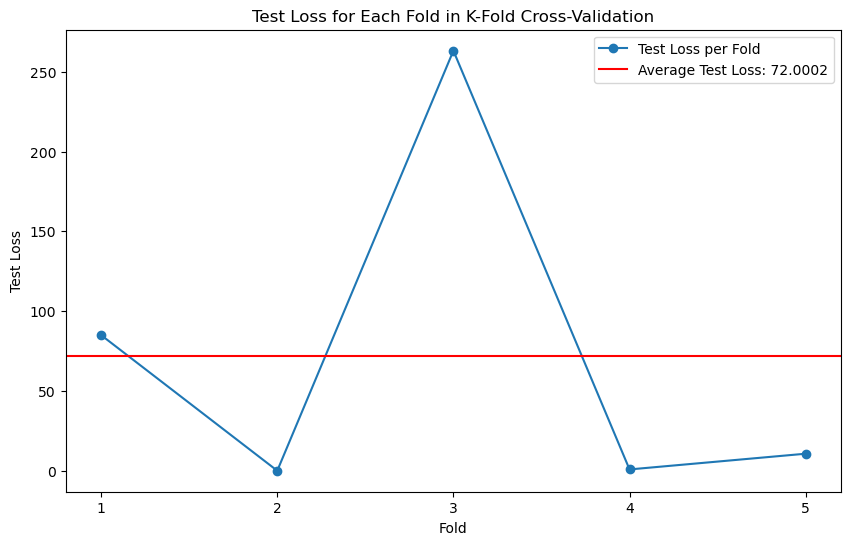

# GNN Model with Cross Validation k=5

Fold 1, Test Loss: 1.4123
Fold 2, Test Loss: 2.2979
Fold 3, Test Loss: 11.4833
Fold 4, Test Loss: 0.5339
Fold 5, Test Loss: 5.8493
Average Test Loss: 4.3154


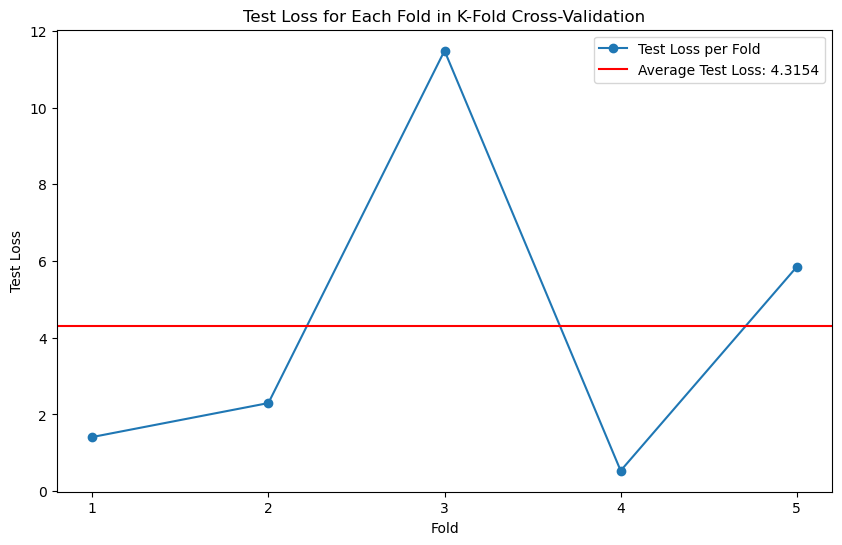

# Atom to Residue Pooling

Create a new dataset which includes residue_index

All graphs have been saved in the directory: saved_graphs_wr


# GNN With Pooling (To Fix)

/Users/ariel.flahaut/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([36803])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (16) must match the size of tensor b (36803) at non-singleton dimension 0